In [6]:
# Import section libraries

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import statsmodels.api as sm

from matplotlib.pyplot import rcParams
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [7]:
# not sure about this

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Some parameters

# Size of the plots
rcParams['figure.figsize'] = 20,6

### Sensitive parameters ###



# Copy them from env file.

In [9]:
# Connection settings

connection = psycopg2.connect(user=aws_db_user,
                            password=aws_db_password,
                            host=aws_db_host,
                            port=aws_db_port,
                            database=aws_db_name)


In [10]:
# Querying all the info.
query = '''
    SELECT *
    FROM raw_table
    '''
# Querying the info that could be of interest to be labeled.

query_retail = '''
        SELECT *
        FROM retail_stats
        WHERE max_date >= '2019-01-01'::date
        AND std > 0
        '''

query_wholesale = '''
        SELECT *
        FROM wholesale_stats
        WHERE max_date >= '2019-01-01'::date
        AND std > 0
        '''
pulled_info = pd.read_sql(query, con=connection)

retail_df = pd.read_sql(query_retail, con=connection)
retail_df = retail_df.drop(labels='index', axis=1)

wholesale_df = pd.read_sql(query_wholesale, con=connection)
wholesale_df = wholesale_df.drop(labels='index', axis=1)

connection.close()

In [11]:
print(pulled_info.dtypes)
print(pulled_info.shape)
display(pulled_info.describe())
pulled_info.head()

id                            int64
product_name                 object
market_id                    object
unit_scale                   object
source_id                     int64
currency_code                object
date_price                   object
retail_observed_price       float64
wholesale_observed_price    float64
dtype: object
(99119, 9)


,id,source_id,retail_observed_price,wholesale_observed_price
count,99119.000000,99119.000000,99119.000000,99119.000000
mean,49560.000000,2.719015,1785.848495,1621.271895
std,28613.335003,2.390416,8369.123493,4471.951023
min,1.000000,1.000000,0.000000,0.000000
25%,24780.500000,1.000000,58.000000,50.000000
50%,49560.000000,1.000000,101.000000,93.000000
75%,74339.500000,4.000000,1174.000000,1500.000000
max,99119.000000,8.000000,946531.000000,100000.000000


,id,product_name,market_id,unit_scale,source_id,currency_code,date_price,retail_observed_price,wholesale_observed_price
0,1,Green Gram,Tororo : UGA,kg,1,KES,2019-02-11,68.0,63.0
1,2,Imported Rice,Kampala : UGA,kg,1,KES,2019-02-11,96.0,85.0
2,3,Maize Flour,Kampala : UGA,kg,1,KES,2019-02-11,41.0,33.0
3,4,Maize Flour,Owino : UGA,kg,1,KES,2019-02-11,41.0,34.0
4,5,Dry Maize,Busia : UGA,kg,1,KES,2019-02-10,24.0,20.0


In [12]:
retail_df.head()

,product_name,market_id,source_id,currency_code,min_date,max_date,ADF Statistic,p-value,Critical value 0.01,Critical value 0.05,...,data_points,mean,std,min,0.25,0.50,0.75,max,data_length,completeness
0,Morogoro Rice,Dar Es Salaam : TZA,1,KES,2014-08-20,2019-06-14,-4.0153,0.0013,-3.453670,-2.871808,...,298.0,129.369128,187.499346,65.0,85.00,88.0,92.0,1045.0,1760,0.169318
1,Morogoro Rice,Arusha : TZA,1,KES,2014-08-20,2019-05-29,-8.0406,0.0000,-3.468062,-2.878106,...,177.0,124.666667,165.441066,0.0,86.00,88.0,97.0,958.0,1744,0.101491
2,Kahama Rice,Arusha : TZA,1,KES,2014-08-22,2019-05-29,-3.9164,0.0019,-3.458366,-2.873866,...,247.0,136.643725,175.606020,0.0,74.00,88.0,98.0,975.0,1742,0.141791
3,Kilombero Rice,Arusha : TZA,1,KES,2014-08-25,2019-05-29,-4.4572,0.0002,-3.490131,-2.887712,...,113.0,171.796460,231.027099,0.0,74.00,78.0,89.0,784.0,1739,0.064980
4,Sunflower Seed,Mombasa : KEN,1,KES,2015-12-17,2019-07-25,-6.8687,0.0000,-3.466201,-2.877293,...,186.0,200.747312,276.118063,72.0,109.25,110.0,120.0,1106.0,1317,0.141230


In [13]:
# From the product/market pairs that have standard deviation positive and last observed prices is after January 1st 2019, we select series that are stationary and with some lenght.

possible_rt = retail_df[(retail_df['data_length'] >= 180) & (retail_df['ADF Statistic'] < retail_df['Critical value 0.1'])].sort_values(by=['data_length'], ascending=False)
display(possible_rt.head())
possible_rt = possible_rt[['product_name','market_id','source_id','currency_code']].values.tolist()
possible_rt[:5]

,product_name,market_id,source_id,currency_code,min_date,max_date,ADF Statistic,p-value,Critical value 0.01,Critical value 0.05,...,data_points,mean,std,min,0.25,0.50,0.75,max,data_length,completeness
0,Morogoro Rice,Dar Es Salaam : TZA,1,KES,2014-08-20,2019-06-14,-4.0153,0.0013,-3.453670,-2.871808,...,298.0,129.369128,187.499346,65.0,85.00,88.0,92.0,1045.0,1760,0.169318
1,Morogoro Rice,Arusha : TZA,1,KES,2014-08-20,2019-05-29,-8.0406,0.0000,-3.468062,-2.878106,...,177.0,124.666667,165.441066,0.0,86.00,88.0,97.0,958.0,1744,0.101491
2,Kahama Rice,Arusha : TZA,1,KES,2014-08-22,2019-05-29,-3.9164,0.0019,-3.458366,-2.873866,...,247.0,136.643725,175.606020,0.0,74.00,88.0,98.0,975.0,1742,0.141791
3,Kilombero Rice,Arusha : TZA,1,KES,2014-08-25,2019-05-29,-4.4572,0.0002,-3.490131,-2.887712,...,113.0,171.796460,231.027099,0.0,74.00,78.0,89.0,784.0,1739,0.064980
4,Sunflower Seed,Mombasa : KEN,1,KES,2015-12-17,2019-07-25,-6.8687,0.0000,-3.466201,-2.877293,...,186.0,200.747312,276.118063,72.0,109.25,110.0,120.0,1106.0,1317,0.141230


[['Morogoro Rice', 'Dar Es Salaam : TZA', 1, 'KES'],
 ['Morogoro Rice', 'Arusha : TZA', 1, 'KES'],
 ['Kahama Rice', 'Arusha : TZA', 1, 'KES'],
 ['Kilombero Rice', 'Arusha : TZA', 1, 'KES'],
 ['Sunflower Seed', 'Mombasa : KEN', 1, 'KES']]

In [14]:
# Same for wholesale.

possible_ws = wholesale_df[(wholesale_df['data_length'] >= 180) & (wholesale_df['ADF Statistic'] < wholesale_df['Critical value 0.1'])].sort_values(by=['data_length'], ascending=False)
display(possible_ws.head())
possible_ws = possible_ws[['product_name','market_id','source_id','currency_code']].values.tolist()
possible_ws[:5]

,product_name,market_id,source_id,currency_code,min_date,max_date,ADF Statistic,p-value,Critical value 0.01,Critical value 0.05,...,data_points,mean,std,min,0.25,0.50,0.75,max,data_length,completeness
0,Morogoro Rice,Dar Es Salaam : TZA,1,KES,2014-08-20,2019-06-14,-4.0213,0.0013,-3.453670,-2.871808,...,298.0,116.704698,171.070269,59.0,75.0,79.0,84.0,958.0,1760,0.169318
1,Morogoro Rice,Arusha : TZA,1,KES,2014-08-20,2019-05-29,-8.0167,0.0000,-3.468062,-2.878106,...,177.0,105.050847,140.132659,53.0,69.0,78.0,83.0,784.0,1744,0.101491
2,Kahama Rice,Arusha : TZA,1,KES,2014-08-22,2019-05-29,-4.0694,0.0011,-3.458366,-2.873866,...,247.0,103.514170,119.417075,44.0,56.0,75.0,84.0,566.0,1742,0.141791
3,Kilombero Rice,Arusha : TZA,1,KES,2014-08-25,2019-05-29,-4.4450,0.0002,-3.490131,-2.887712,...,113.0,137.008850,181.719638,51.0,60.0,61.0,69.0,653.0,1739,0.064980
4,Sunflower Seed,Mombasa : KEN,1,KES,2015-12-17,2019-07-25,-6.9377,0.0000,-3.466201,-2.877293,...,186.0,182.129032,260.998094,50.0,90.0,105.0,105.0,1055.0,1317,0.141230


[['Morogoro Rice', 'Dar Es Salaam : TZA', 1, 'KES'],
 ['Morogoro Rice', 'Arusha : TZA', 1, 'KES'],
 ['Kahama Rice', 'Arusha : TZA', 1, 'KES'],
 ['Kilombero Rice', 'Arusha : TZA', 1, 'KES'],
 ['Sunflower Seed', 'Mombasa : KEN', 1, 'KES']]

### The next class is our master class that collects almost every method we need.

In [15]:
class Clean_and_classify_class:
    def __init__(self):
        self.description = ''' This class groups the main functions that are used to clean, 
                                prepare the data, build  the ALPS bands and also label the
                                maize prices.'''

    def basic_cleanning(self,df):
        
        ''' 
        Removes duplicates in dates column. 
        Verify unique unit scale.
        Try to correct typos.

        Returns the metric and the dataframe with the basic cleaned data.
        '''

        cfd = df.copy()    

        # Set dates into date format.

        cfd['date_price'] =  pd.to_datetime(cfd['date_price'])

        # Remove duplicates in dates column.

        cfd = cfd.sort_values(by=['date_price',cfd.columns[-1]])

        drop_index = list(cfd[cfd.duplicated(['date_price'], keep='first')].index)

        cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)

        # Drop values with prices zero.

        drop_index = list(cfd[cfd.iloc[:,-1] == 0].index)

        cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True) 

        if cfd.empty:

            return None, cfd
        
        else:

            # Consider the mode of unit scale as the one.

            metric = stats.mode(cfd.iloc[:,1])[0][0]

            discording_scale = list(cfd[cfd['unit_scale'] != metric].index)

            if discording_scale:

                cfd = cfd.drop(labels=discording_scale, axis=0).reset_index(drop=True)  
            
            # Try to correct typos that seems to be missing a decimal point.
            
            if 9 <= cfd.describe().T['max'].values[0] / cfd.describe().T['75%'].values[0] <= 11:
                
                Q99 = cfd.quantile(0.99).values[0]
                selected_indices = list(cfd[cfd.iloc[:,-1] > Q99].index)
                for i in selected_indices:
                    cfd.iloc[i,-1] = cfd.iloc[i,-1] / 10
            
            # Drop typos we can't solve.
            
            drop_index = cfd[(cfd.iloc[:,-1].rolling(window=1, min_periods= 1).max() / cfd.iloc[:,-1].rolling(window=30, min_periods= 10).quantile(0.75) ) > 5].index
            
            cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)  
            
            
            Q01 = cfd.iloc[:,-1].quantile(.1)
            
            if cfd.describe().T['min'].values[0] < Q01:              

                drop_index = list(cfd[cfd.iloc[:,-1] < Q01].index)

                cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)
    
            # Drop outliers.

            if (cfd.describe().T['max'].values[0]) > (cfd.describe().T['75%'].values[0] + cfd.describe().T['std'].values[0]):

                # First round

                z = np.abs(stats.zscore(cfd.iloc[:,-1], nan_policy='omit'))

                drop_index = list(np.where(z>4)[0])

                cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)

            if (cfd.describe().T['max'].values[0]) > (cfd.describe().T['75%'].values[0] + cfd.describe().T['std'].values[0]):                
                
                # Second round.

                z = np.abs(stats.zscore(cfd.iloc[:,-1], nan_policy='omit'))

                drop_index = list(np.where(z>5)[0])

                cfd = cfd.drop(labels=drop_index, axis=0).reset_index(drop=True)            
                                
            return metric, cfd
    
    def limit_2019_and_later(self,df):

        ''' 
        Limit the info to the 2020 or later and assigns its month, so the price could be compared with the bands.
        '''


        df = df[df['date_price'] > datetime.date(2018,12,31)]
        df['date_price'] = df['date_price'].astype('datetime64')
        df['month'] = [str(df.iloc[i,0])[:8] + '01' for i in range(len(df))]
        df = df.reset_index(drop=True)

        return df

    ### ALPS bands Model ###

    def prepare_data_to_ALPS(self,df):
    
        ''' 
        Make a dataframe with the last Sunday before the dates of the input dataframe, and the saturday of the last week in within the dates.
        Then Merge both dataframes to have one with all the possible weeks within the dates of the original dataframe.
        Interpolate the missing values.
        '''      
        
        cfd = df.copy()
        

        # Turn the dataframe into a calendar.

        if cfd['date_price'].min().day == 1:
            start = cfd['date_price'].min()
        else:
            start = cfd['date_price'].min() - datetime.timedelta(days=cfd['date_price'].min().day + 1)
        if cfd['date_price'].max().day >= 28:
            end = cfd['date_price'].max()
        else:
            end = cfd['date_price'].max() - datetime.timedelta(days=cfd['date_price'].max().day +1)

        dummy = pd.DataFrame()
        dummy['date_price'] = pd.date_range(start=start, end=end)
        dummy = dummy.set_index('date_price')
        cfd = cfd.set_index('date_price')
        cfd = dummy.merge(cfd,how='outer',left_index=True, right_index=True)
        del dummy


        cfd['max_price_30days'] = cfd.iloc[:,-1].rolling(window=30,min_periods=1).max()

        cfd['max_price_30days'] = cfd['max_price_30days'].shift(-1)

        cfd = cfd[cfd.index.day == 1]

        cfd = cfd[['max_price_30days']].interpolate()

        cfd = cfd.dropna()

        return cfd
    
    def inmediate_forecast_ALPS_based(self,df):

        forecasted_prices = []
        mqerrors = []

        basesetyear = df.index.max().year - 2

        stop_0 = datetime.date(year=basesetyear,month=12,day=31)

        baseset = df.iloc[:len(df.loc[:stop_0]),:].copy()   

        future_length = len(df)-len(baseset)

        # For all the past months:
        for i in range(future_length):

            workset = df.copy()

            # What month are we?

            workset['month'] = workset.index.month

            # Build dummy variables for the months.

            dummies_df = pd.get_dummies(workset['month'])
            dummies_df = dummies_df.T.reindex(range(1,13)).T.fillna(0)

            workset = workset.join(dummies_df)
            workset = workset.drop(labels=['month'], axis=1)

            futureset = workset.iloc[len(workset.loc[:stop_0]) + i:,:]
            workset = workset.iloc[:len(workset.loc[:stop_0]) + i,:]


            features = workset.columns[1:]
            target = workset.columns[0]

            X = workset[features]
            y = workset[target]

            reg = LinearRegression()

            reg = reg.fit(X,y)

            forecasting = reg.predict(futureset[features])


            forecasted_prices.append(forecasting[0])

            mqerrors.append(mean_squared_error(futureset.iloc[:1,0],forecasting[:1]))
            
        
        # For the current month.
        
        next_month = futureset.iloc[-1,:].name

        raw_next_month = [0 if j != next_month.month + 1 else 1 for j in range(1,13)]

        next_month_array = np.array(raw_next_month).reshape(1,-1)

        forecasted_prices.append(reg.predict(next_month_array)[0])    
        
        mqerrors.append(None)

        return stop_0, forecasted_prices, mqerrors
           
    
    ### ARIMA bands Model ###
    
    def prepare_data_to_ARIMA(self,df):
    
        ''' 
        Make a pandas series with the maximun observed prices within the month.
        If the latest observed prices is before the 25th of the month, that month
        is considered as incomplete: on course.
        Interpolate the missing values.
        '''      
        
        cfd = df.copy()
        
        cfd = cfd.set_index(pd.to_datetime(cfd['date_price'])).groupby(pd.Grouper(freq='M')).max().interpolate('linear')
        cfd = cfd.iloc[:,-1]
        
        if df['date_price'].max().day < 25:
            cfd = cfd[:-1]
        
        result_adft = adfuller(cfd)
        if result_adft[0] < result_adft[4]['10%']:
            
            error = None
        else:
            error = 'Not Stationary'
        
        return cfd, error
    
    # Evaluate an ARIMA model for a given order (p,d,q)

    def evaluate_arima_model(self,X, arima_order):

        # Train/test split

        train_size = int(len(X)*.65)
        X_train, X_test = X[0:train_size], X[train_size:]
        history = [x for x in X_train]

        # forecast

        forecast = []
        for t in range(len(X_test)):
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit()
            y_pred = model_fit.predict()[0]
            forecast.append(y_pred)
            history.append(X_test[t])

        # Calculate the mean squared error

        error = mean_squared_error(X_test,forecast)

        return error

    def evaluate_models(self,timeseries, p_values, d_values, q_values):

        timeseries = timeseries.astype('float32')
        best_score, best_params = float('inf'), None
        possible_params = [(p,d,q) for p in p_values for d in d_values for q in q_values]
        for params in possible_params:
            try:
                mse = self.evaluate_arima_model(timeseries, params)
                if mse < best_score:
                    best_score, best_params = mse, params

            except:
                continue
        return best_score, best_params
    
    
    def find_best_possible_ARIMA_params(self,df):
        
        res = sm.tsa.arma_order_select_ic(df, ic='aic', trend='c')
        prop_params = res.aic_min_order
        
        # Parameters for evaluation.

        p_values = range(0,prop_params[0]+1)
        d_values = range(0,3)
        q_values = range(0,prop_params[1] + 1)
        
        best_score, best_params = self.evaluate_models(df, p_values, d_values, q_values)
        
        return best_score, best_params
        
    def inmediate_forecast_ARIMA_based(self,df, params):

        forecasted_prices = []
        trend_prices = []
        mqerrors = []


        stop_0 = datetime.date(2018,12,31) 

        baseset = df[:stop_0]

        future_length = len(df)-len(baseset)

        history = [x for x in baseset]

        # we are predicting the next month.
        for i in range(future_length + 1):

            model = ARIMA(history, params)
            model_fit = model.fit()#start_ar_lags=None)
            y_pred = model_fit.predict()[0]
            forecasted_prices.append(y_pred)
            try:
                history.append(df[len(df[:stop_0])+i])
                mqerrors.append(mean_squared_error([history[-1]],[y_pred]))
            except:
                mqerrors.append(None) 
        
        return stop_0,forecasted_prices, mqerrors
    
    def build_bands_wfp_forecast(self,df, stop_0, forecasted_prices, mqerrors):

        ''' 
        Takes the forecasted prices and build a dataframe with the ALPS bands,
        and calculates the stressness of them.
        '''
        
        if isinstance(df, pd.Series):
            
            df = pd.DataFrame(df)
        
        
        errorstable = pd.DataFrame(index=pd.date_range(df.loc[stop_0:].index[0],datetime.date(df.index[-1].year,df.index[-1].month + 1, 1), freq='MS'),
                        columns=['observed_price','forecast']) 
        errorstable.iloc[:,0] = None
        errorstable.iloc[:-1,0] =  [x[0] for x in df.iloc[len(df.loc[:stop_0]):,:].values.tolist()]
        errorstable.iloc[:,1] =  forecasted_prices
        
        errorstable['residuals'] = errorstable.iloc[:,0] - errorstable['forecast']
        errorstable['cum_residual_std'] = [np.std(errorstable.iloc[:i,2]) for i in range(1,len(errorstable)+1)]
        errorstable['ALPS'] = [None] + list(errorstable.iloc[1:,2]  / errorstable.iloc[1:,3])
        errorstable['Price Status'] = None
        errorstable['Stressness'] = None
        errorstable['normal_limit'] = None
        errorstable['stress_limit'] = None
        errorstable['alert_limit'] = None
        errorstable['mse'] = mqerrors
        
        errorstable['normal_limit'] = errorstable['forecast'] + 0.25 * errorstable['cum_residual_std']
        errorstable['stress_limit'] = errorstable['forecast'] + errorstable['cum_residual_std']
        errorstable['alert_limit'] = errorstable['forecast'] + 2 * errorstable['cum_residual_std']

        for date in range(len(errorstable)-1):

            if errorstable.iloc[date,4] < 0.25:
                errorstable.iloc[date,5] = 'Normal'
                errorstable.iloc[date,6] =  errorstable.iloc[date,0] / errorstable.iloc[date,7]
                
            elif errorstable.iloc[date,4] < 1:
                errorstable.iloc[date,5] = 'Stress'
                errorstable.iloc[date,6] =  errorstable.iloc[date,0] / errorstable.iloc[date,8]
                
            elif errorstable.iloc[date,4] < 2:
                errorstable.iloc[date,5] = 'Alert'
                errorstable.iloc[date,6] =  errorstable.iloc[date,0] / errorstable.iloc[date,9]
                
            else:
                errorstable.iloc[date,5] = 'Crisis'
                errorstable.iloc[date,6] =  errorstable.iloc[date,0] / errorstable.iloc[date,9]
                

        mse = mean_squared_error(errorstable.iloc[:-1,0],errorstable.iloc[:-1,1])
                
        return errorstable, mse

    def set_columns_bands_df(self,bands):

        '''
        Builds a dataframe from the raw data for the bands, from the db.
        '''

        bands= pd.DataFrame(bands)
        bands = bands.rename(columns={0:'date_price',1:'normal_band_limit',2:'stress_band_limit',3:'alert_band_limit', 4: 'class_method'})

        return bands 

    def assign_classification(self,data,bands):

        '''
        Combine the data from the prices and the bands to classify the price in its status.
        '''

        results = data.copy()

        results['Observed_class'] = None
        results['Stressness'] = None

        for i in range(len(results)):

            bands_limits = bands[bands['date_price'] == datetime.date.fromisoformat(data.iloc[i,3])]

            if results.iloc[i,2] < bands_limits.iloc[0,1]:

                results.iloc[i,4] = 'Normal'
                results.iloc[i,5] = results.iloc[i,2] / bands_limits.iloc[0,1]

            elif results.iloc[i,2] < bands_limits.iloc[0,2]:

                results.iloc[i,4] = 'Stress'
                results.iloc[i,5] = results.iloc[i,2] / bands_limits.iloc[0,2]
            
            elif results.iloc[i,2] < bands_limits.iloc[0,3]:

                results.iloc[i,4] = 'Alert'
                results.iloc[i,5] = results.iloc[i,2] / bands_limits.iloc[0,3]

            else:

                results.iloc[i,4] = 'Crisis'
                results.iloc[i,5] = results.iloc[i,2] / bands_limits.iloc[0,3]

        results = results.drop(labels=['month'], axis=1)

        return results
  
    def run_build_bands(self,data):

        '''
        A method that runs in a line the methods required.
        '''
        
        metric, cleaned = self.basic_cleanning(data)
        try:
            stop_0, forecasted_prices, mqerrors = self.inmediate_forecast_ALPS_based(self.prepare_data_to_ALPS(cleaned))
            result, mse = self.build_bands_wfp_forecast(self.prepare_data_to_ALPS(cleaned),stop_0,forecasted_prices, mqerrors)

            return metric, stop_0, result, mse
        
        except:

            return None, None, None, None

    def test_run_build_bands(self,data):

        '''
        A method that runs in a line the methods required.
        '''
        
        metric, cleaned = self.basic_cleanning(data)

        stop_0, forecasted_prices, mqerrors = self.inmediate_forecast_ALPS_based(self.prepare_data_to_ALPS(cleaned))
        result, mse = self.build_bands_wfp_forecast(self.prepare_data_to_ALPS(cleaned),stop_0,forecasted_prices, mqerrors)

        return metric, stop_0, result, mse

    
    def test_run_build_ARIMA_based_bands(self,data):

        '''
        A method that runs in a line the methods required.
        '''
        
        metric, cleaned = self.basic_cleanning(data)

        cfd, error = self.prepare_data_to_ARIMA(cleaned)
        
        if not error:            
                
            _, best_params = self.find_best_possible_ARIMA_params(cfd)

            stop_0, forecasted_prices, mqerrors = self.inmediate_forecast_ARIMA_based(cfd, best_params)
            result, mse = self.build_bands_wfp_forecast(cfd,stop_0,forecasted_prices, mqerrors)

            return metric, stop_0, result, mse
        
        else:
                           
            return None, None, None, None

In [16]:
# We select a product/market pair to try the class.
test_1 = pulled_info[(pulled_info['product_name'] == 'Morogoro Rice') & (pulled_info['market_id'] == 'Dar Es Salaam : TZA') & (pulled_info['source_id'] == 1) & (pulled_info['currency_code'] == 'KES')].sort_values(by=['date_price'])
print(test_1.shape)
print(set(test_1['unit_scale']))
test_1.head()

(298, 9)
{'kg'}


,id,product_name,market_id,unit_scale,source_id,currency_code,date_price,retail_observed_price,wholesale_observed_price
68325,68326,Morogoro Rice,Dar Es Salaam : TZA,kg,1,KES,2014-08-20,75.0,69.0
66909,66910,Morogoro Rice,Dar Es Salaam : TZA,kg,1,KES,2014-08-26,73.0,63.0
67952,67953,Morogoro Rice,Dar Es Salaam : TZA,kg,1,KES,2014-09-10,75.0,64.0
71097,71098,Morogoro Rice,Dar Es Salaam : TZA,kg,1,KES,2014-09-16,75.0,64.0
66641,66642,Morogoro Rice,Dar Es Salaam : TZA,kg,1,KES,2014-09-22,74.0,64.0


,date_price,unit_scale,retail_observed_price
0,2014-08-20,kg,75.0
1,2014-08-26,kg,73.0
2,2014-09-10,kg,75.0
3,2014-09-16,kg,75.0
4,2014-09-22,kg,74.0
...,...,...,...
293,2019-06-04,kg,87.0
294,2019-06-06,kg,87.0
295,2019-06-10,kg,87.0
296,2019-06-11,kg,87.0


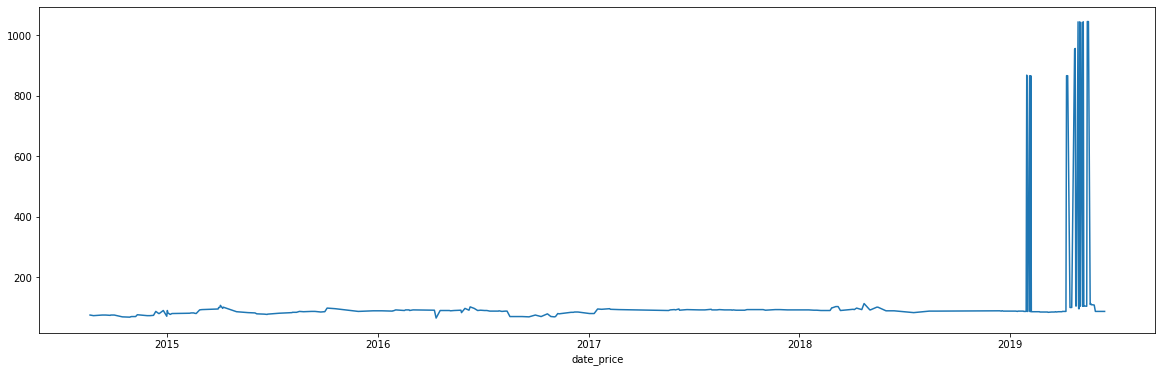

In [17]:
test_1_rt = test_1[['date_price','unit_scale','retail_observed_price']].reset_index(drop=True)
display(test_1_rt)
test_1_rt.set_index('date_price')['retail_observed_price'].plot()

In [18]:
test_1.describe()

,id,source_id,retail_observed_price,wholesale_observed_price
count,298.000000,298.0,298.000000,298.000000
mean,66114.466443,1.0,129.369128,116.704698
std,4549.182261,0.0,187.499346,171.070269
min,54027.000000,1.0,65.000000,59.000000
25%,66483.000000,1.0,85.000000,75.000000
50%,67309.500000,1.0,88.000000,79.000000
75%,68429.750000,1.0,92.000000,84.000000
max,71110.000000,1.0,1045.000000,958.000000


,date_price,unit_scale,retail_observed_price
0,2014-12-12,kg,87.0
1,2014-12-17,kg,80.0
2,2014-12-18,kg,80.0
3,2014-12-25,kg,90.0
4,2015-01-01,kg,90.0
...,...,...,...
250,2019-06-04,kg,87.0
251,2019-06-06,kg,87.0
252,2019-06-10,kg,87.0
253,2019-06-11,kg,87.0


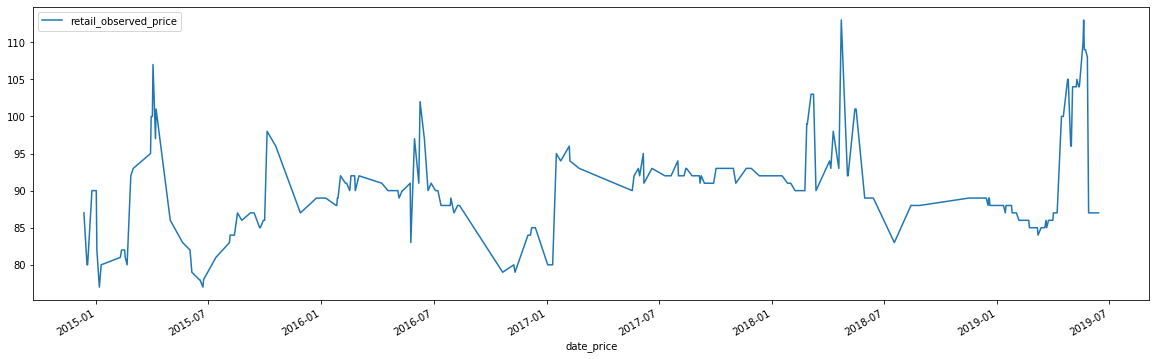

In [19]:
# this is how the cleaning is working
test_class = Clean_and_classify_class()
metric, cfd = test_class.basic_cleanning(test_1_rt)
display(cfd)
cfd[['date_price','retail_observed_price']].set_index('date_price').plot()

In [20]:
display(test_1_rt.describe())
cfd.describe()

,retail_observed_price
count,298.000000
mean,129.369128
std,187.499346
min,65.000000
25%,85.000000
50%,88.000000
75%,92.000000
max,1045.000000


,retail_observed_price
count,255.000000
mean,89.901961
std,6.802775
min,77.000000
25%,86.000000
50%,88.000000
75%,92.000000
max,113.000000


In [21]:
# The (original ALPS) 
test_class = Clean_and_classify_class()
metric, cleaned = test_class.basic_cleanning(test_1_rt)
stop_0, forecasted_prices, mqerrors = test_class.inmediate_forecast_ALPS_based(test_class.prepare_data_to_ALPS(cleaned))
result, mse = test_class.build_bands_wfp_forecast(test_class.prepare_data_to_ALPS(cleaned),stop_0,forecasted_prices, mqerrors)
result

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,92,88.000000,4,0.000000,NaN,Crisis,1.04545,88.000000,88.000000,88.000000,16.000000
2018-02-01,92,89.000000,3,0.500000,6.000000,Crisis,1.02222,89.125000,89.500000,90.000000,9.000000
2018-03-01,99,93.666667,5.33333,0.955814,5.579887,Crisis,1.0358,93.905620,94.622481,95.578295,28.444444
2018-04-01,103,95.500000,7.5,1.684797,4.451574,Crisis,1.04178,95.921199,97.184797,98.869594,56.250000
2018-05-01,113,97.333333,15.6667,4.540680,3.450291,Crisis,1.06188,98.468503,101.874014,106.414694,245.444444
2018-06-01,101,91.000000,10,4.283636,2.334465,Crisis,1.01439,92.070909,95.283636,99.567272,100.000000
2018-07-01,89,92.000000,-3,5.426169,-0.552876,Normal,0.953334,93.356542,97.426169,102.852338,9.000000
2018-08-01,83,88.333333,-5.33333,6.323697,-0.843388,Normal,0.923102,89.914258,94.657031,100.980728,28.444444
2018-09-01,88,89.333333,-1.33333,6.251145,-0.213294,Normal,0.968138,90.896120,95.584479,101.835624,1.777778
2018-10-01,88.3333,87.833333,0.5,6.021628,0.083034,Normal,0.988746,89.338740,93.854961,99.876589,0.250000


In [22]:
test_class = Clean_and_classify_class()
metric, stop_0, result, mse = test_class.test_run_build_ARIMA_based_bands(test_1_rt)
result

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,88,91.590381,-3.59038,0.000000,NaN,Crisis,0.9608,91.590381,91.590381,91.590381,12.890836
2019-02-01,87,91.501372,-4.50137,0.455495,-9.882366,Normal,0.949624,91.615246,91.956867,92.412362,20.262348
2019-03-01,86,91.406245,-5.40624,0.741325,-7.292682,Normal,0.938951,91.591576,92.147569,92.888894,29.227481
2019-04-01,105,91.289046,13.711,7.911378,1.733068,Alert,0.980284,93.266891,99.200424,107.111801,187.990249
2019-05-01,113,91.933403,21.0666,10.987343,1.917351,Alert,0.992028,94.680238,102.920746,113.908089,443.801530
2019-06-01,None,92.313498,NaN,10.987343,NaN,None,None,95.060334,103.300841,114.288185,NaN


# The ALPS method

The World Food Program has developed an indicator to measure stress on the product / market pair known as Alert for Price Spikes (ALPS).
Thir methodology uses a linnear regression to forecast the expected following montly price. The formula is like this:

 $\hat{Price_t} = \hat{\alpha} * T_t +  \sum_{i=1}^{12} \hat{\beta_m} * D_{mt}  $

Where:

$\hat{Price_t}$ is the estimated market price at time t
    
    
$\hat{\alpha}$ is the coefficient of the trend

$\hat{\beta_m}$ is the coefficient of the monthly dummies

$T$ is the trend

$D_{mt}$ are the monthly dummies, $m$ is the number of the month, e.g. $D_1$ corresponds to January dummy.





Since the price of the stakeholders are on a daily base but not consistent, I decided to take the maximum observed price of the month, to be fixed as the monthly price.

Because this is a estimation, there would be difference to the real observed price, so we calculate this difference and named it $\hat{\epsilon_t}$.
In math notation: $\hat{\epsilon_t} = Price_t - \hat{Price_t}$

Where:

$Price_t$ is the real market price at time t

$\hat{Price_t}$ is the estimated market price at time t

The ALPS is calculated by the following formula.

  Alert for Price Spikes (ALPS) = $ \frac{Price_t - \hat{Price_t}}{\sigma_{\hat{\epsilon}}}$

where:

$\sigma_{\hat{\epsilon}}$ is the standard deviation of the residuals

The other variables are known at this point.

So ALPS categories are given by the following chart:

| Situation on a given market | ALPS |
| --- | --- |
| Normal | ALPS < 0.25 | 
| Stress | 0.25 $\leq$ ALPS < 1 | 
| Alert | 1 $\leq$ ALPS < 2 | 
| Crisis | ALPS $\geq 2$ |

I decided to take January 1st, 2019 as the breakpoint. The points before there all are considerered as historical data to start the predictions to the monthly maxima.
So expect that the first price will have a bigger (cumulative) standard deviation and should not considered in the ALPS analysis.

Also, to be considered:

   - As this is a linnear regression model, it requires sufficient historical data. ALPS requires at least 3 years of data. 
   - Requires stationarity in the time series as well.
   
As will be shown in the next cells, only a few product market places satifies this requirements, so I decided to run a weak version of the ALPS. 
I considered a weak ALPS if the time series is stationary but the historical data is less than 4 years but longer than 2 years.

Finally, waiving this requirements to the weak version we were still getting a few of product/market pairs that satifies this. 

Looking into the stakeholders database, I discovered that the most of the data have arround 1.5 years of historical data, so we had to figure out another method for the required forecasting. 
There is where I suggested to work with the ARIMA model for forcasting. Because this is going to be in automatic, and there are more than a thousand  we cannot be be knowing how much past we need at the start of this.
So I decided to require at least six months of historical data before the breakpoint I chose. And the next are the results:

In [23]:
# First for the pure ALPS, we need that the historical data is from more than 4 years and the series is stationary.

retail_df[retail_df['data_length'] > 1460]

# As we can see, the four of them are stationary.

,product_name,market_id,source_id,currency_code,min_date,max_date,ADF Statistic,p-value,Critical value 0.01,Critical value 0.05,...,data_points,mean,std,min,0.25,0.50,0.75,max,data_length,completeness
0,Morogoro Rice,Dar Es Salaam : TZA,1,KES,2014-08-20,2019-06-14,-4.0153,0.0013,-3.453670,-2.871808,...,298.0,129.369128,187.499346,65.0,85.0,88.0,92.0,1045.0,1760,0.169318
1,Morogoro Rice,Arusha : TZA,1,KES,2014-08-20,2019-05-29,-8.0406,0.0000,-3.468062,-2.878106,...,177.0,124.666667,165.441066,0.0,86.0,88.0,97.0,958.0,1744,0.101491
2,Kahama Rice,Arusha : TZA,1,KES,2014-08-22,2019-05-29,-3.9164,0.0019,-3.458366,-2.873866,...,247.0,136.643725,175.606020,0.0,74.0,88.0,98.0,975.0,1742,0.141791
3,Kilombero Rice,Arusha : TZA,1,KES,2014-08-25,2019-05-29,-4.4572,0.0002,-3.490131,-2.887712,...,113.0,171.796460,231.027099,0.0,74.0,78.0,89.0,784.0,1739,0.064980


In [26]:
retail_alps = retail_df[retail_df['data_length'] > 1460][['product_name','market_id','source_id','currency_code']]
retail_alps = retail_alps.values.tolist()
retail_alps

[['Morogoro Rice', 'Dar Es Salaam : TZA', 1, 'KES'],
 ['Morogoro Rice', 'Arusha : TZA', 1, 'KES'],
 ['Kahama Rice', 'Arusha : TZA', 1, 'KES'],
 ['Kilombero Rice', 'Arusha : TZA', 1, 'KES']]

In [35]:
# The (original ALPS) 

for combination in retail_alps:
    
    temp_df = pulled_info[(pulled_info['product_name'] == combination[0]) & (pulled_info['market_id'] == combination[1]) & (pulled_info['source_id'] == combination[2]) & (pulled_info['currency_code'] == combination[3])]
    temp_df = temp_df[['date_price','unit_scale','retail_observed_price']]
    alps_class = Clean_and_classify_class()
    _, _, result, mse= alps_class.run_build_bands(temp_df)
    print(combination, round(mse,2))
    display(result)
    


['Morogoro Rice', 'Dar Es Salaam : TZA', 1, 'KES'] 40.36


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,92,88.000000,4,0.000000,NaN,Crisis,1.04545,88.000000,88.000000,88.000000,16.000000
2018-02-01,92,89.000000,3,0.500000,6.000000,Crisis,1.02222,89.125000,89.500000,90.000000,9.000000
2018-03-01,99,93.666667,5.33333,0.955814,5.579887,Crisis,1.0358,93.905620,94.622481,95.578295,28.444444
2018-04-01,103,95.500000,7.5,1.684797,4.451574,Crisis,1.04178,95.921199,97.184797,98.869594,56.250000
2018-05-01,113,97.333333,15.6667,4.540680,3.450291,Crisis,1.06188,98.468503,101.874014,106.414694,245.444444
2018-06-01,101,91.000000,10,4.283636,2.334465,Crisis,1.01439,92.070909,95.283636,99.567272,100.000000
2018-07-01,89,92.000000,-3,5.426169,-0.552876,Normal,0.953334,93.356542,97.426169,102.852338,9.000000
2018-08-01,83,88.333333,-5.33333,6.323697,-0.843388,Normal,0.923102,89.914258,94.657031,100.980728,28.444444
2018-09-01,88,89.333333,-1.33333,6.251145,-0.213294,Normal,0.968138,90.896120,95.584479,101.835624,1.777778
2018-10-01,88.3333,87.833333,0.5,6.021628,0.083034,Normal,0.988746,89.338740,93.854961,99.876589,0.250000


['Morogoro Rice', 'Arusha : TZA', 1, 'KES'] 104.23


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,106.25,95.375000,10.875,0.000000,NaN,Crisis,1.11402,95.375000,95.375000,95.375000,118.265625
2018-02-01,108,95.377778,12.6222,0.873611,14.448331,Crisis,1.11197,95.596181,96.251389,97.125000,159.320494
2018-03-01,108,94.622222,13.3778,1.048149,12.763241,Crisis,1.11664,94.884259,95.670371,96.718520,178.964938
2018-04-01,107,94.900000,12.1,0.911510,13.274678,Crisis,1.10625,95.127877,95.811510,96.723020,146.410000
2018-05-01,108,95.222222,12.7778,0.842799,15.161124,Crisis,1.11446,95.432922,96.065021,96.907820,163.271605
2018-06-01,106,93.000000,13,0.806539,16.118253,Crisis,1.12035,93.201635,93.806539,94.613078,169.000000
2018-07-01,97,94.000000,3,3.393073,0.884154,Stress,0.995964,94.848268,97.393073,100.786145,9.000000
2018-08-01,88,96.188889,-8.18889,7.127401,-1.148931,Normal,0.898227,97.970739,103.316290,110.443690,67.057901
2018-09-01,88,95.383333,-7.38333,8.407680,-0.878165,Normal,0.902701,97.485253,103.791014,112.198694,54.513611
2018-10-01,88,95.500000,-7.5,9.072254,-0.826696,Normal,0.900089,97.768063,104.572254,113.644507,56.250000


['Kahama Rice', 'Arusha : TZA', 1, 'KES'] 357.92


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,111.182,96.000000,15.1818,0.000000,NaN,Crisis,1.15814,96.000000,96.000000,96.000000,230.487603
2018-02-01,113,97.666667,15.3333,0.075758,202.400000,Crisis,1.1552,97.685606,97.742424,97.818182,235.111111
2018-03-01,113,98.000000,15,0.136270,110.075524,Crisis,1.14986,98.034068,98.136270,98.272540,225.000000
2018-04-01,103,98.606061,4.39394,4.668407,0.941208,Stress,0.997342,99.773162,103.274467,107.942874,19.306703
2018-05-01,103,98.545455,4.45455,5.266259,0.845865,Stress,0.992181,99.862019,103.811713,109.077972,19.842975
2018-06-01,100,97.500000,2.5,5.731291,0.436202,Stress,0.968699,98.932823,103.231291,108.962583,6.250000
2018-07-01,97,92.875000,4.125,5.626984,0.733075,Stress,0.984752,94.281746,98.501984,104.128968,17.015625
2018-08-01,79.4,93.141414,-13.7414,9.102218,-1.509678,Normal,0.832137,95.416969,102.243632,111.345850,188.826463
2018-09-01,70,95.893939,-25.8939,13.172674,-1.965731,Normal,0.705737,99.187108,109.066613,122.239287,670.496097
2018-10-01,70.6667,95.875000,-25.2083,14.987697,-1.681935,Normal,0.709349,99.621924,110.862697,125.850393,635.460069


['Kilombero Rice', 'Arusha : TZA', 1, 'KES'] 242.28


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,82.1053,94.000000,-11.8947,0.000000,NaN,Crisis,0.87346,94.000000,94.000000,94.000000,141.484765
2018-02-01,80.8947,94.037037,-13.1423,0.623782,-21.068750,Normal,0.858819,94.192982,94.660819,95.284600,172.720054
2018-03-01,79.6842,93.962963,-14.2788,0.973623,-14.665593,Normal,0.845847,94.206369,94.936586,95.910208,203.882771
2018-04-01,78.4737,93.888889,-15.4152,1.308214,-11.783397,Normal,0.832913,94.215942,95.197103,96.505317,237.628535
2018-05-01,77.2632,93.435997,-16.1728,1.536629,-10.524885,Normal,0.823524,93.820155,94.972626,96.509255,261.560738
2018-06-01,76.0526,93.500000,-17.4474,1.857345,-9.393716,Normal,0.809378,93.964336,95.357345,97.214689,304.410665
2018-07-01,74.8421,92.500000,-17.6579,2.002513,-8.817869,Normal,0.804748,93.000628,94.502513,96.505026,311.801247
2018-08-01,73.6316,92.077323,-18.4457,2.168188,-8.507446,Normal,0.794991,92.619370,94.245511,96.413699,340.245471
2018-09-01,72.4211,91.718324,-19.2973,2.358071,-8.183497,Normal,0.78456,92.307841,94.076395,96.434466,372.384666
2018-10-01,71.2105,91.000000,-19.7895,2.513109,-7.874499,Normal,0.777168,91.628277,93.513109,96.026218,391.623269


In [36]:
# Second for the weak ALPS, we need that the historical data is from more than 2 years but shorter than 4 years and the series is stationary.

retail_df[(retail_df['data_length'] > 730) & (retail_df['data_length'] <= 1460)]

# As we can see, the four of them are stationary.

,product_name,market_id,source_id,currency_code,min_date,max_date,ADF Statistic,p-value,Critical value 0.01,Critical value 0.05,...,data_points,mean,std,min,0.25,0.50,0.75,max,data_length,completeness
4,Sunflower Seed,Mombasa : KEN,1,KES,2015-12-17,2019-07-25,-6.8687,0.0000,-3.466201,-2.877293,...,186.0,200.747312,276.118063,72.0,109.25,110.0,120.00,1106.0,1317,0.141230
5,Kidney Bean,Nairobi : KEN,1,KES,2016-06-23,2019-08-06,-4.5338,0.0002,-3.480888,-2.883697,...,137.0,147.890511,212.475766,20.0,80.00,80.0,90.00,902.0,1140,0.120175
6,Maize Bran,Masindi : UGA,1,KES,2016-08-12,2019-08-14,-6.2525,0.0000,-3.626652,-2.945951,...,37.0,28.837838,42.446380,7.0,14.00,14.0,21.00,213.0,1098,0.033698
7,Kidney Bean,Mbeya : TZA,1,KES,2017-02-08,2019-06-19,-5.2380,0.0000,-3.473830,-2.880623,...,156.0,99.641026,123.380029,55.0,66.00,70.0,72.00,671.0,862,0.180974
8,Mbeya Rice,Mbeya : TZA,1,KES,2017-02-15,2019-06-19,-4.6246,0.0001,-3.460428,-2.874769,...,226.0,106.376106,132.434085,66.0,74.00,78.0,89.00,927.0,855,0.264327
9,Mbeya Rice,Iringa : TZA,1,KES,2017-02-16,2019-06-17,-3.9697,0.0016,-3.467632,-2.877918,...,186.0,119.354839,145.642149,77.0,86.25,88.0,96.00,873.0,852,0.218310
10,Mbeya Rice,Dar Es Salaam : TZA,1,KES,2017-03-20,2019-06-14,-3.1893,0.0206,-3.468952,-2.878495,...,179.0,174.469274,248.085847,87.0,101.00,108.0,113.00,1089.0,817,0.219094
11,Maize Bran,Mbale : UGA,1,KES,2017-03-07,2019-05-30,-4.9169,0.0000,-3.491818,-2.888444,...,111.0,22.675676,31.364184,8.0,11.00,14.0,19.00,188.0,815,0.136196
12,Chic Pea,Juba : SSD,1,KES,2017-02-13,2019-05-02,-5.0420,0.0000,-3.512738,-2.897490,...,84.0,466.107143,1047.416673,149.0,192.00,206.5,222.00,5113.0,809,0.103832
13,Mbeya Rice,Arusha : TZA,1,KES,2017-03-20,2019-05-29,-8.2054,0.0000,-3.473259,-2.880374,...,156.0,167.500000,238.475548,0.0,92.00,98.0,105.25,1002.0,801,0.194757


In [37]:
retail_weak_alps = retail_df[(retail_df['data_length'] > 730) & (retail_df['data_length'] <= 1460)][['product_name','market_id','source_id','currency_code']]
retail_weak_alps = retail_weak_alps.values.tolist()
retail_weak_alps

[['Sunflower Seed', 'Mombasa : KEN', 1, 'KES'],
 ['Kidney Bean', 'Nairobi : KEN', 1, 'KES'],
 ['Maize Bran', 'Masindi : UGA', 1, 'KES'],
 ['Kidney Bean', 'Mbeya : TZA', 1, 'KES'],
 ['Mbeya Rice', 'Mbeya : TZA', 1, 'KES'],
 ['Mbeya Rice', 'Iringa : TZA', 1, 'KES'],
 ['Mbeya Rice', 'Dar Es Salaam : TZA', 1, 'KES'],
 ['Maize Bran', 'Mbale : UGA', 1, 'KES'],
 ['Chic Pea', 'Juba : SSD', 1, 'KES'],
 ['Mbeya Rice', 'Arusha : TZA', 1, 'KES']]

In [43]:
for combination in retail_weak_alps:
    
    temp_df = pulled_info[(pulled_info['product_name'] == combination[0]) & (pulled_info['market_id'] == combination[1]) & (pulled_info['source_id'] == combination[2]) & (pulled_info['currency_code'] == combination[3])]
    temp_df = temp_df[['date_price','unit_scale','retail_observed_price']]
    alps_class = Clean_and_classify_class()
    _, _, result, mse= alps_class.run_build_bands(temp_df)
    if mse:
        print(combination, round(mse,2))
        display(result)
    else:
        print('This combination has problems: ', combination)
    

['Sunflower Seed', 'Mombasa : KEN', 1, 'KES'] 166.54


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,130,133.000000,-3,0.000000,NaN,Crisis,0.977444,133.000000,133.000000,133.000000,9.0000
2018-02-01,140,126.500000,13.5,8.250000,1.636364,Alert,0.979021,128.562500,134.750000,143.000000,182.2500
2018-03-01,120,127.500000,-7.5,9.027735,-0.830773,Normal,0.924806,129.756934,136.527735,145.555470,56.2500
2018-04-01,120,126.000000,-6,8.385255,-0.715542,Normal,0.936795,128.096314,134.385255,142.770510,36.0000
2018-05-01,120,122.250000,-2.25,7.523962,-0.299045,Normal,0.966721,124.130990,129.773962,137.297923,5.0625
2018-06-01,120,123.000000,-3,6.906745,-0.434358,Normal,0.962104,124.726686,129.906745,136.813490,9.0000
2018-07-01,115,119.750000,-4.75,6.502551,-0.730483,Normal,0.947472,121.375638,126.252551,132.755101,22.5625
2018-08-01,111.5,115.000000,-3.5,6.106797,-0.573132,Normal,0.956862,116.526699,121.106797,127.213594,12.2500
2018-09-01,108,105.000000,3,5.973320,0.502233,Stress,0.973207,106.493330,110.973320,116.946641,9.0000
2018-10-01,104.5,102.000000,2.5,5.792452,0.431596,Stress,0.969456,103.448113,107.792452,113.584904,6.2500


This combination has problems:  ['Kidney Bean', 'Nairobi : KEN', 1, 'KES']
['Maize Bran', 'Masindi : UGA', 1, 'KES'] 36.18


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,14.0714,19.000000,-4.92857,0.000000,NaN,Crisis,0.740602,19.000000,19.000000,19.000000,24.290816
2018-02-01,14.1429,20.000000,-5.85714,0.464286,-12.615385,Normal,0.703063,20.116071,20.464286,20.928571,34.306122
2018-03-01,14.2143,21.000000,-6.78571,0.758175,-8.950059,Normal,0.670816,21.189544,21.758175,22.516351,46.045918
2018-04-01,14.2857,32.250000,-17.9643,5.283504,-3.400070,Normal,0.425539,33.570876,37.533504,42.817009,322.715561
2018-05-01,14.3571,21.714286,-7.35714,4.765009,-1.543994,Normal,0.626798,22.905538,26.479294,31.244303,54.127551
2018-06-01,14.4286,20.750000,-6.32143,4.430427,-1.426821,Normal,0.660117,21.857607,25.180427,29.610854,39.960459
2018-07-01,14.5,19.142857,-4.64286,4.286729,-1.083077,Normal,0.717305,20.214539,23.429586,27.716314,21.556122
2018-08-01,14.5714,17.750000,-3.17857,4.278899,-0.742848,Normal,0.774264,18.819725,22.028899,26.307797,10.103316
2018-09-01,14.6429,16.000000,-1.35714,4.423288,-0.306818,Normal,0.856016,17.105822,20.423288,24.846576,1.841837
2018-10-01,14.7143,15.642857,-0.928571,4.515604,-0.205636,Normal,0.877325,16.771758,20.158461,24.674064,0.862245


['Kidney Bean', 'Mbeya : TZA', 1, 'KES'] 79.76


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,73,78.650000,-5.65,0.000000,NaN,Crisis,0.928163,78.650000,78.650000,78.650000,31.92250
2018-02-01,80,78.136364,1.86364,3.756818,0.496068,Stress,0.976882,79.075568,81.893182,85.650000,3.47314
2018-03-01,78,91.000000,-13,6.068177,-2.142324,Normal,0.843088,92.517044,97.068177,103.136353,169.00000
2018-04-01,78,69.000000,9,8.219470,1.094961,Alert,0.912933,71.054868,77.219470,85.438941,81.00000
2018-05-01,71,69.000000,2,7.519298,0.265982,Stress,0.927871,70.879825,76.519298,84.038597,4.00000
2018-06-01,87,77.000000,10,8.025340,1.246053,Alert,0.934974,79.006335,85.025340,93.050681,100.00000
2018-07-01,88,73.000000,15,8.957502,1.674574,Alert,0.967937,75.239376,81.957502,90.915005,225.00000
2018-08-01,79,90.000000,-11,9.532593,-1.153936,Normal,0.855134,92.383148,99.532593,109.065186,121.00000
2018-09-01,70,85.500000,-15.5,10.380252,-1.493220,Normal,0.794596,88.095063,95.880252,106.260503,240.25000
2018-10-01,69,81.000000,-12,10.404082,-1.153393,Normal,0.825349,83.601021,91.404082,101.808164,144.00000


['Mbeya Rice', 'Mbeya : TZA', 1, 'KES'] 199.54


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,88,90.800000,-2.8,0.000000,NaN,Crisis,0.969163,90.800000,90.800000,90.800000,7.840000
2018-02-01,92,90.545455,1.45455,2.127273,0.683761,Stress,0.992741,91.077273,92.672727,94.800000,2.115702
2018-03-01,90,107.000000,-17,7.890299,-2.154544,Normal,0.825896,108.972575,114.890299,122.780599,289.000000
2018-04-01,98,104.000000,-6,6.833382,-0.878043,Normal,0.927079,105.708345,110.833382,117.666763,36.000000
2018-05-01,101,94.000000,7,8.047145,0.869874,Stress,0.989739,96.011786,102.047145,110.094291,49.000000
2018-06-01,98,88.000000,10,8.897219,1.123947,Alert,0.926325,90.224305,96.897219,105.794439,100.000000
2018-07-01,91,81.000000,10,9.125702,1.095806,Alert,0.916864,83.281425,90.125702,99.251404,100.000000
2018-08-01,84,78.000000,6,8.736368,0.686784,Stress,0.968452,80.184092,86.736368,95.472737,36.000000
2018-09-01,77,81.000000,-4,8.390130,-0.476751,Normal,0.926622,83.097532,89.390130,97.780260,16.000000
2018-10-01,77,89.000000,-12,8.800910,-1.363495,Normal,0.844296,91.200227,97.800910,106.601820,144.000000


['Mbeya Rice', 'Iringa : TZA', 1, 'KES'] 50.7


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,101,99.700000,1.3,0.000000,NaN,Crisis,1.01304,99.700000,99.700000,99.700000,1.690000
2018-02-01,101,99.818182,1.18182,0.059091,20.000000,Crisis,1.01064,99.832955,99.877273,99.936364,1.396694
2018-03-01,99,103.000000,-4,2.471059,-1.618739,Normal,0.955435,103.617765,105.471059,107.942119,16.000000
2018-04-01,98,102.000000,-4,2.620788,-1.526259,Normal,0.954652,102.655197,104.620788,107.241575,16.000000
2018-05-01,99,103.000000,-4,2.567783,-1.557764,Normal,0.955212,103.641946,105.567783,108.135565,16.000000
2018-06-01,105,98.000000,7,4.062631,1.723021,Alert,0.989397,99.015658,102.062631,106.125262,49.000000
2018-07-01,97,103.000000,-6,4.237942,-1.415782,Normal,0.932159,104.059485,107.237942,111.475884,36.000000
2018-08-01,95.75,95.000000,0.75,4.017246,0.186695,Normal,0.997351,96.004311,99.017246,103.034492,0.562500
2018-09-01,94.5,92.000000,2.5,3.941453,0.634284,Stress,0.984976,92.985363,95.941453,99.882905,6.250000
2018-10-01,93.25,97.000000,-3.75,3.857835,-0.972048,Normal,0.951876,97.964459,100.857835,104.715671,14.062500


['Mbeya Rice', 'Dar Es Salaam : TZA', 1, 'KES'] 45.86


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,116,112.888889,3.11111,0.000000,NaN,Crisis,1.02756,112.888889,112.888889,112.888889,9.679012e+00
2018-02-01,115,113.200000,1.8,0.655556,2.745763e+00,Crisis,1.00427,113.363889,113.855556,114.511111,3.240000e+00
2018-03-01,112,113.363636,-1.36364,1.878267,-7.260078e-01,Normal,0.983896,113.833203,115.241903,117.120170,1.859504e+00
2018-04-01,116,111.000000,5,2.319142,2.155969e+00,Crisis,1.00313,111.579786,113.319142,115.638285,2.500000e+01
2018-05-01,116,104.000000,12,4.457326,2.692197e+00,Crisis,1.02732,105.114331,108.457326,112.914652,1.440000e+02
2018-06-01,114,116.000000,-2,4.662684,-4.289375e-01,Normal,0.972981,117.165671,120.662684,125.325367,4.000000e+00
2018-07-01,110,118.000000,-8,5.804995,-1.378123e+00,Normal,0.920878,119.451249,123.804995,129.609990,6.400000e+01
2018-08-01,106,117.000000,-11,6.825988,-1.611488e+00,Normal,0.892959,118.706497,123.825988,130.651976,1.210000e+02
2018-09-01,106,103.000000,3,6.506898,4.610492e-01,Stress,0.967976,104.626724,109.506898,116.013795,9.000000e+00
2018-10-01,106,115.000000,-9,6.772112,-1.328980e+00,Normal,0.908366,116.693028,121.772112,128.544224,8.100000e+01


['Maize Bran', 'Mbale : UGA', 1, 'KES'] 43.1


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,11,18.000000,-7,0.000000,NaN,Crisis,0.611111,18.000000,18.000000,18.000000,4.900000e+01
2018-02-01,11,17.300000,-6.3,0.350000,-1.800000e+01,Normal,0.632638,17.387500,17.650000,18.000000,3.969000e+01
2018-03-01,11,16.727273,-5.72727,0.520454,-1.100438e+01,Normal,0.652533,16.857386,17.247727,17.768181,3.280165e+01
2018-04-01,11,20.000000,-9,1.235885,-7.282230e+00,Normal,0.541633,20.308971,21.235885,22.471770,8.100000e+01
2018-05-01,11,21.000000,-10,1.629537,-6.136711e+00,Normal,0.513841,21.407384,22.629537,24.259075,1.000000e+02
2018-06-01,11,22.000000,-11,1.952751,-5.633080e+00,Normal,0.489146,22.488188,23.952751,25.905501,1.210000e+02
2018-07-01,11,23.000000,-12,2.250232,-5.332785e+00,Normal,0.466842,23.562558,25.250232,27.500463,1.440000e+02
2018-08-01,11,20.000000,-9,2.106961,-4.271554e+00,Normal,0.535886,20.526740,22.106961,24.213923,8.100000e+01
2018-09-01,11,17.000000,-6,2.166748,-2.769126e+00,Normal,0.627078,17.541687,19.166748,21.333497,3.600000e+01
2018-10-01,11,17.000000,-6,2.182758,-2.748816e+00,Normal,0.626935,17.545689,19.182758,21.365515,3.600000e+01


['Chic Pea', 'Juba : SSD', 1, 'KES'] 27002.46


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,446,282.100000,163.9,0.000000,NaN,Crisis,1.581,282.100000,282.100000,282.100000,2.686321e+04
2018-02-01,446,297.000000,149,7.450000,2.000000e+01,Crisis,1.42995,298.862500,304.450000,311.900000,2.220100e+04
2018-03-01,446,230.000000,216,28.723626,7.519942e+00,Crisis,1.55159,237.180906,258.723626,287.447251,4.665600e+04
2018-04-01,446,226.000000,220,31.254630,7.038957e+00,Crisis,1.54588,233.813657,257.254630,288.509259,4.840000e+04
2018-05-01,446,220.000000,226,31.969385,7.069263e+00,Crisis,1.57076,227.992346,251.969385,283.938771,5.107600e+04
2018-06-01,446,227.000000,219,30.525968,7.174220e+00,Crisis,1.54833,234.631492,257.525968,288.051936,4.796100e+04
2018-07-01,446,196.000000,250,33.427735,7.478820e+00,Crisis,1.69675,204.356934,229.427735,262.855470,6.250000e+04
2018-08-01,446,192.000000,254,35.027059,7.251537e+00,Crisis,1.70194,200.756765,227.027059,262.054117,6.451600e+04
2018-09-01,446,276.666667,169.333,35.670399,4.747167e+00,Crisis,1.28158,285.584267,312.337066,348.007465,2.867378e+04
2018-10-01,446,361.333333,84.6667,50.024065,1.692519e+00,Alert,0.966662,373.839350,411.357399,461.381464,7.168444e+03


['Mbeya Rice', 'Arusha : TZA', 1, 'KES'] 76.85


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2018-01-01,108.25,105.916667,2.33333,0.000000,NaN,Crisis,1.02203,105.916667,105.916667,105.916667,5.444444
2018-02-01,109,106.150000,2.85,0.258333,11.032258,Crisis,1.02187,106.214583,106.408333,106.666667,8.122500
2018-03-01,108,106.409091,1.59091,0.516769,3.078571,Crisis,1.00519,106.538283,106.925860,107.442628,2.530992
2018-04-01,107,111.000000,-4,2.746536,-1.456380,Normal,0.958038,111.686634,113.746536,116.493071,16.000000
2018-05-01,108,115.000000,-7,3.937678,-1.777698,Normal,0.93116,115.984419,118.937678,122.875356,49.000000
2018-06-01,111,102.000000,9,5.136455,1.752181,Alert,0.988662,103.284114,107.136455,112.272911,81.000000
2018-07-01,97,103.000000,-6,5.316864,-1.128485,Normal,0.929749,104.329216,108.316864,113.633728,36.000000
2018-08-01,88,101.000000,-13,6.536450,-1.988847,Normal,0.857415,102.634112,107.536450,114.072900,169.000000
2018-09-01,91,101.000000,-10,6.682383,-1.496472,Normal,0.88633,102.670596,107.682383,114.364767,100.000000
2018-10-01,94,106.000000,-12,6.927246,-1.732290,Normal,0.872537,107.731812,112.927246,119.854492,144.000000


In [47]:
# Third. If we reduce the lenght of the historical data to less than two years but more than 1.5 years and the series being stationary.
# I feel very weird about this. It is a linnear regression, with montly variables, we need historical data to build the coeficients of the dummy monthly variables.

retail_df[(retail_df['data_length'] <= 730) & (retail_df['data_length'] >= 547) & (retail_df['ADF Statistic'] < retail_df['Critical value 0.1'])]

# As we can see, the four of them are stationary.

,product_name,market_id,source_id,currency_code,min_date,max_date,ADF Statistic,p-value,Critical value 0.01,Critical value 0.05,...,data_points,mean,std,min,0.25,0.50,0.75,max,data_length,completeness
14,Pigeon Pea,Meru : KEN,1,KES,2017-12-11,2019-10-14,-5.0275,0.0000,-3.492996,-2.888955,...,109.0,98.532110,142.431567,41.0,50.00,55.0,65.00,651.0,673,0.161961
15,Green Pea,Masindi : UGA,1,KES,2018-01-01,2019-10-17,-5.2119,0.0000,-3.699608,-2.976430,...,28.0,149.071429,185.316931,111.0,112.00,112.0,113.00,1094.0,655,0.042748
16,Pigeon Pea,Makueni : KEN,1,KES,2017-12-14,2019-09-24,-8.1781,0.0000,-3.521980,-2.901470,...,75.0,68.813333,71.499328,0.0,50.00,60.0,70.50,665.0,650,0.115385
17,Green Pea,Nairobi : KEN,1,KES,2018-01-04,2019-10-11,-11.8472,0.0000,-3.467005,-2.877644,...,182.0,103.236264,124.517962,0.0,70.00,70.0,90.00,803.0,646,0.281734
18,Green Pea,Eldoret : KEN,1,KES,2018-01-05,2019-10-11,-4.8138,0.0001,-3.468062,-2.878106,...,183.0,174.530055,201.472104,0.0,156.00,163.0,173.00,1703.0,645,0.283721
19,Green Pea,Gitega : BDI,1,KES,2018-01-11,2019-10-16,-9.6940,0.0000,-3.461136,-2.875079,...,216.0,150.064815,176.707077,57.0,102.00,120.0,140.00,1320.0,644,0.335404
20,Green Pea,Ngozi : BDI,1,KES,2018-01-12,2019-10-16,-4.1050,0.0010,-3.460708,-2.874891,...,226.0,155.473451,182.080621,67.0,109.00,133.0,145.00,1495.0,643,0.351477
21,Green Pea,Bujumbura : BDI,1,KES,2018-01-16,2019-10-16,-12.2153,0.0000,-3.472703,-2.880132,...,158.0,158.392405,145.189480,13.0,137.25,146.0,166.00,1424.0,639,0.247261
22,Green Pea,Arusha : TZA,1,KES,2018-01-29,2019-10-17,-5.7980,0.0000,-3.484667,-2.885340,...,124.0,127.959677,200.544884,5.0,60.00,69.0,86.00,871.0,627,0.197767
23,Dry Pea,Gitega : BDI,1,KES,2018-02-01,2019-10-16,-10.7787,0.0000,-3.468280,-2.878202,...,176.0,139.346591,156.646205,93.0,105.00,114.0,126.00,1429.0,623,0.282504


In [55]:
retail_extra_weak_alps = retail_df[(retail_df['data_length'] <= 730) & (retail_df['data_length'] >= 547) & (retail_df['ADF Statistic'] < retail_df['Critical value 0.1'])]
retail_extra_weak_alps = retail_extra_weak_alps[['product_name','market_id','source_id','currency_code']]
retail_extra_weak_alps = retail_extra_weak_alps.values.tolist()
retail_extra_weak_alps

[['Pigeon Pea', 'Meru : KEN', 1, 'KES'],
 ['Green Pea', 'Masindi : UGA', 1, 'KES'],
 ['Pigeon Pea', 'Makueni : KEN', 1, 'KES'],
 ['Green Pea', 'Nairobi : KEN', 1, 'KES'],
 ['Green Pea', 'Eldoret : KEN', 1, 'KES'],
 ['Green Pea', 'Gitega : BDI', 1, 'KES'],
 ['Green Pea', 'Ngozi : BDI', 1, 'KES'],
 ['Green Pea', 'Bujumbura : BDI', 1, 'KES'],
 ['Green Pea', 'Arusha : TZA', 1, 'KES'],
 ['Dry Pea', 'Gitega : BDI', 1, 'KES'],
 ['Green Pea', 'Mombasa : KEN', 1, 'KES'],
 ['Pigeon Pea', 'Machakos : KEN', 1, 'KES'],
 ['Maize Flour', 'Juba : SSD', 1, 'KES'],
 ['Dry Pea', 'Ngozi : BDI', 1, 'KES'],
 ['Green Pea', 'Nakuru : KEN', 1, 'KES'],
 ['Green Pea', 'Rubavu : RWA', 1, 'KES'],
 ['Maize Flour', 'Kabale : UGA', 1, 'KES'],
 ['Maize Flour', 'Arusha : TZA', 1, 'KES'],
 ['Pigeon Pea', 'Ngozi : BDI', 1, 'KES'],
 ['Maize Flour', 'Kampala : UGA', 1, 'KES'],
 ['Maize Flour', 'Lira : UGA', 1, 'KES'],
 ['Green Pea', 'Kamembe : RWA', 1, 'KES']]

In [56]:
for combination in retail_extra_weak_alps:
    
    temp_df = pulled_info[(pulled_info['product_name'] == combination[0]) & (pulled_info['market_id'] == combination[1]) & (pulled_info['source_id'] == combination[2]) & (pulled_info['currency_code'] == combination[3])]
    temp_df = temp_df[['date_price','unit_scale','retail_observed_price']]
    alps_class = Clean_and_classify_class()
    _, _, result, mse= alps_class.run_build_bands(temp_df)
    if mse:
        print(combination, round(mse,2))
        display(result)
    else:
        print('This combination has problems: ', combination)

This combination has problems:  ['Pigeon Pea', 'Meru : KEN', 1, 'KES']
This combination has problems:  ['Green Pea', 'Masindi : UGA', 1, 'KES']
This combination has problems:  ['Pigeon Pea', 'Makueni : KEN', 1, 'KES']
This combination has problems:  ['Green Pea', 'Nairobi : KEN', 1, 'KES']
This combination has problems:  ['Green Pea', 'Eldoret : KEN', 1, 'KES']
This combination has problems:  ['Green Pea', 'Gitega : BDI', 1, 'KES']
This combination has problems:  ['Green Pea', 'Ngozi : BDI', 1, 'KES']
This combination has problems:  ['Green Pea', 'Bujumbura : BDI', 1, 'KES']
This combination has problems:  ['Green Pea', 'Arusha : TZA', 1, 'KES']
This combination has problems:  ['Dry Pea', 'Gitega : BDI', 1, 'KES']
This combination has problems:  ['Green Pea', 'Mombasa : KEN', 1, 'KES']
This combination has problems:  ['Pigeon Pea', 'Machakos : KEN', 1, 'KES']
This combination has problems:  ['Maize Flour', 'Juba : SSD', 1, 'KES']
This combination has problems:  ['Dry Pea', 'Ngozi : BDI

### A try to the possible combinations on retail

In [59]:
# Recall possible_rt, are the possible product/market pairs that are stationary 
# and has at least 6 months before January 1st, 2019. So are considered worth to 
# work on.


possible_rt[:3]

[['Morogoro Rice', 'Dar Es Salaam : TZA', 1, 'KES'],
 ['Morogoro Rice', 'Arusha : TZA', 1, 'KES'],
 ['Kahama Rice', 'Arusha : TZA', 1, 'KES']]

In [62]:
pairs_ok = []
pairs_with_problems = []

test_class = Clean_and_classify_class()
for combination in possible_rt:

    print(combination)
    try:
        print('tried combination:', combination)
        temp_df = pulled_info[(pulled_info['product_name'] == combination[0]) & (pulled_info['market_id'] == combination[1]) & (pulled_info['source_id'] == combination[2]) & (pulled_info['currency_code'] == combination[3])][['date_price','unit_scale','retail_observed_price']].reset_index(drop=True)
        metric, stop_0, result, mse = test_class.test_run_build_ARIMA_based_bands(temp_df)
        if not result.empty:
            pairs_ok.append(combination)
            display(result)
    except:
        pairs_with_problems.append(combination)
        pass

['Morogoro Rice', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Morogoro Rice', 'Dar Es Salaam : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,88,91.590381,-3.59038,0.000000,NaN,Crisis,0.9608,91.590381,91.590381,91.590381,12.890836
2019-02-01,87,91.501372,-4.50137,0.455495,-9.882366,Normal,0.949624,91.615246,91.956867,92.412362,20.262348
2019-03-01,86,91.406245,-5.40624,0.741325,-7.292682,Normal,0.938951,91.591576,92.147569,92.888894,29.227481
2019-04-01,105,91.289046,13.711,7.911378,1.733068,Alert,0.980284,93.266891,99.200424,107.111801,187.990249
2019-05-01,113,91.933403,21.0666,10.987343,1.917351,Alert,0.992028,94.680238,102.920746,113.908089,443.801530
2019-06-01,None,92.313498,NaN,10.987343,NaN,None,None,95.060334,103.300841,114.288185,NaN


['Morogoro Rice', 'Arusha : TZA', 1, 'KES']
tried combination: ['Morogoro Rice', 'Arusha : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,88,95.912575,-7.91258,0.000000,NaN,Crisis,0.917502,95.912575,95.912575,95.912575,62.608846
2019-02-01,87,94.867345,-7.86734,0.022615,-347.879167,Normal,0.917015,94.872999,94.889960,94.912575,61.895115
2019-03-01,86,94.558812,-8.55881,0.315840,-27.098567,Normal,0.908728,94.637772,94.874652,95.190492,73.253260
2019-04-01,88,94.221695,-6.2217,0.863392,-7.206103,Normal,0.931833,94.437543,95.085088,95.948480,38.709492
2019-05-01,96,94.423856,1.57614,3.766516,0.418462,Stress,0.977693,95.365485,98.190372,101.956888,2.484229
2019-06-01,None,95.413380,NaN,3.766516,NaN,None,None,96.355009,99.179895,102.946411,NaN


['Kahama Rice', 'Arusha : TZA', 1, 'KES']
tried combination: ['Kahama Rice', 'Arusha : TZA', 1, 'KES']
['Kilombero Rice', 'Arusha : TZA', 1, 'KES']
tried combination: ['Kilombero Rice', 'Arusha : TZA', 1, 'KES']
['Sunflower Seed', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Sunflower Seed', 'Mombasa : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,100,117.689189,-17.6892,0.000000,NaN,Crisis,0.849696,117.689189,117.689189,117.689189,312.907414
2019-02-01,115,117.223684,-2.22368,7.732752,-0.287567,Normal,0.965114,119.156872,124.956437,132.689189,4.944771
2019-03-01,110,117.166667,-7.16667,6.449276,-1.111236,Normal,0.92609,118.778986,123.615942,130.065218,51.361111
2019-04-01,110,116.987500,-6.9875,5.654592,-1.235721,Normal,0.929045,118.401148,122.642092,128.296684,48.825156
2019-05-01,115,116.817074,-1.81707,5.723745,-0.317462,Normal,0.972532,118.248010,122.540819,128.264564,3.301757
2019-06-01,118,116.773810,1.22619,6.091640,0.201291,Normal,0.997492,118.296720,122.865450,128.957090,1.503543
2019-07-01,115,116.802326,-1.80233,5.808676,-0.310282,Normal,0.972479,118.254495,122.611002,128.419678,3.248378
2019-08-01,None,116.761364,NaN,5.808676,NaN,None,None,118.213533,122.570040,128.378716,NaN


['Kidney Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Kidney Bean', 'Nairobi : KEN', 1, 'KES']
['Maize Bran', 'Masindi : UGA', 1, 'KES']
tried combination: ['Maize Bran', 'Masindi : UGA', 1, 'KES']
['Kidney Bean', 'Mbeya : TZA', 1, 'KES']
tried combination: ['Kidney Bean', 'Mbeya : TZA', 1, 'KES']
['Mbeya Rice', 'Mbeya : TZA', 1, 'KES']
tried combination: ['Mbeya Rice', 'Mbeya : TZA', 1, 'KES']
['Mbeya Rice', 'Iringa : TZA', 1, 'KES']
tried combination: ['Mbeya Rice', 'Iringa : TZA', 1, 'KES']
['Mbeya Rice', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Mbeya Rice', 'Dar Es Salaam : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110,111.521581,-1.52158,0.000000,NaN,Crisis,0.986356,111.521581,111.521581,111.521581,2.315210
2019-02-01,108,111.417626,-3.41763,0.948022,-3.605006,Normal,0.967268,111.654631,112.365648,113.313670,11.680164
2019-03-01,108,111.262313,-3.26231,0.859538,-3.795426,Normal,0.968808,111.477198,112.121851,112.981389,10.642686
2019-04-01,110,111.143219,-1.14322,1.014147,-1.127272,Normal,0.987461,111.396756,112.157366,113.171512,1.306950
2019-05-01,114,111.129082,2.87092,2.271788,1.263726,Alert,0.98554,111.697029,113.400871,115.672659,8.242168
2019-06-01,None,111.283264,NaN,2.271788,NaN,None,None,111.851211,113.555053,115.826841,NaN


['Maize Bran', 'Mbale : UGA', 1, 'KES']
tried combination: ['Maize Bran', 'Mbale : UGA', 1, 'KES']
['Chic Pea', 'Juba : SSD', 1, 'KES']
tried combination: ['Chic Pea', 'Juba : SSD', 1, 'KES']
['Mbeya Rice', 'Arusha : TZA', 1, 'KES']
tried combination: ['Mbeya Rice', 'Arusha : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,106,104.116528,1.88347,0.000000,NaN,Crisis,1.01809,104.116528,104.116528,104.116528,3.547466
2019-02-01,94,103.956196,-9.9562,5.919834,-1.681837,Normal,0.891535,105.436154,109.876030,115.795864,99.125836
2019-03-01,94,103.363391,-9.36339,5.446926,-1.719023,Normal,0.897588,104.725122,108.810317,114.257244,87.673088
2019-04-01,104,103.087571,0.912429,5.543484,0.164595,Normal,0.995468,104.473442,108.631055,114.174540,0.832526
2019-05-01,101,103.330789,-2.33079,5.010254,-0.465204,Normal,0.965737,104.583352,108.341043,113.351297,5.432575
2019-06-01,None,103.047550,NaN,5.010254,NaN,None,None,104.300114,108.057805,113.068059,NaN


['Pigeon Pea', 'Meru : KEN', 1, 'KES']
tried combination: ['Pigeon Pea', 'Meru : KEN', 1, 'KES']
['Green Pea', 'Masindi : UGA', 1, 'KES']
tried combination: ['Green Pea', 'Masindi : UGA', 1, 'KES']
['Pigeon Pea', 'Makueni : KEN', 1, 'KES']
tried combination: ['Pigeon Pea', 'Makueni : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,50,64.715150,-14.7151,0.000000,NaN,Crisis,0.772617,64.715150,64.715150,64.715150,216.535628
2019-02-01,55,64.218525,-9.21852,2.748313,-3.354249,Normal,0.847384,64.905603,66.966837,69.715150,84.981196
2019-03-01,60,65.955225,-5.95522,3.614758,-1.647475,Normal,0.897412,66.858914,69.569983,73.184741,35.464703
2019-04-01,65,67.268633,-2.26863,4.571693,-0.496235,Normal,0.950132,68.411556,71.840326,76.412019,5.146696
2019-05-01,65,68.394726,-3.39473,4.491320,-0.755842,Normal,0.935016,69.517556,72.886046,77.377366,11.524166
2019-06-01,70,68.312421,1.68758,5.249829,0.321454,Stress,0.951575,69.624878,73.562250,78.812079,2.847924
2019-07-01,75,69.433166,5.56683,6.246079,0.891253,Stress,0.991025,70.994685,75.679245,81.925324,30.989645
2019-08-01,70,70.733882,-0.733882,5.944256,-0.123461,Normal,0.969261,72.219946,76.678138,82.622394,0.538583
2019-09-01,None,69.483215,NaN,5.944256,NaN,None,None,70.969279,75.427471,81.371726,NaN


['Green Pea', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Green Pea', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,80,105.077278,-25.0773,0.000000,NaN,Crisis,0.761344,105.077278,105.077278,105.077278,628.869861
2019-02-01,70,103.136548,-33.1365,4.029635,-8.223213,Normal,0.672147,104.143957,107.166183,111.195818,1098.030809
2019-03-01,80,100.519628,-20.5196,5.216541,-3.933570,Normal,0.785671,101.823763,105.736169,110.952709,421.055130
2019-04-01,90,99.818851,-9.81885,8.425971,-1.165308,Normal,0.882999,101.925344,108.244822,116.670794,96.409839
2019-05-01,80,99.244127,-19.2441,7.624801,-2.523886,Normal,0.790902,101.150328,106.868928,114.493729,370.336442
2019-06-01,123,97.808642,25.1914,18.761842,1.342691,Alert,0.908874,102.499102,116.570483,135.332325,634.604535
2019-07-01,151,100.695256,50.3047,28.362020,1.773666,Alert,0.959222,107.785761,129.057276,157.419297,2530.567299
2019-08-01,80,103.293548,-23.2935,27.239972,-0.855124,Normal,0.726589,110.103541,130.533520,157.773491,542.589392
2019-09-01,74,99.964228,-25.9642,26.368171,-0.984681,Normal,0.694469,106.556271,126.332399,152.700570,674.141153
2019-10-01,None,100.005486,NaN,26.368171,NaN,None,None,106.597529,126.373657,152.741828,NaN


['Green Pea', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Green Pea', 'Eldoret : KEN', 1, 'KES']
['Green Pea', 'Gitega : BDI', 1, 'KES']
tried combination: ['Green Pea', 'Gitega : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,115,143.750000,-28.75,0.000000,NaN,Crisis,0.8,143.750000,143.750000,143.750000,826.562500
2019-02-01,113,141.538462,-28.5385,0.105769,-269.818182,Normal,0.79822,141.564904,141.644231,141.750000,814.443787
2019-03-01,139,139.500000,-0.5,13.267599,-0.037686,Normal,0.973274,142.816900,152.767599,166.035197,0.250000
2019-04-01,145,139.466667,5.53333,15.725969,0.351860,Stress,0.934323,143.398159,155.192636,170.918606,30.617778
2019-05-01,121,139.812500,-18.8125,14.252457,-1.319948,Normal,0.843937,143.375614,154.064957,168.317414,353.910156
2019-06-01,123,138.705882,-15.7059,13.022536,-1.206054,Normal,0.866432,141.961516,151.728418,164.750954,246.674740
2019-07-01,131.5,137.833333,-6.33333,12.387540,-0.511266,Normal,0.933086,140.930218,150.220873,162.608413,40.111111
2019-08-01,140,137.500000,2.5,12.711314,0.196675,Normal,0.995182,140.677829,150.211314,162.922628,6.250000
2019-09-01,146,137.625000,8.375,13.489168,0.620869,Stress,0.966157,140.997292,151.114168,164.603336,70.140625
2019-10-01,None,138.023810,NaN,13.489168,NaN,None,None,141.396102,151.512978,165.002146,NaN


['Green Pea', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Green Pea', 'Ngozi : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,115,148.572521,-33.5725,0.000000,NaN,Crisis,0.774033,148.572521,148.572521,148.572521,1127.114143
2019-02-01,138,144.324565,-6.32457,13.623978,-0.464223,Normal,0.934133,147.730560,157.948543,171.572521,40.000125
2019-03-01,139,144.882286,-5.88229,12.950314,-0.454220,Normal,0.938429,148.119864,157.832600,170.782915,34.601287
2019-04-01,150,144.534416,5.46558,14.363911,0.380508,Stress,0.944,148.125394,158.898327,173.262239,29.872610
2019-05-01,149.5,145.227797,4.2722,14.071537,0.303606,Stress,0.938485,148.745681,159.299333,173.370870,18.251721
2019-06-01,143,145.444364,-2.44436,12.967610,-0.188498,Normal,0.961757,148.686266,158.411974,171.379583,5.974914
2019-07-01,112,145.126870,-33.1269,15.215482,-2.177182,Normal,0.752027,148.930740,160.342352,175.557835,1097.389499
2019-08-01,157,142.554080,14.4459,16.406485,0.880501,Stress,0.987666,146.655701,158.960566,175.367051,208.684603
2019-09-01,158,144.517471,13.4825,16.771773,0.803882,Stress,0.979607,148.710415,161.289245,178.061018,181.778577
2019-10-01,None,145.150528,NaN,16.771773,NaN,None,None,149.343471,161.922301,178.694075,NaN


['Green Pea', 'Bujumbura : BDI', 1, 'KES']
tried combination: ['Green Pea', 'Bujumbura : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,86,164.366995,-78.367,0.000000,NaN,Crisis,0.523219,164.366995,164.366995,164.366995,6141.385842
2019-02-01,96,156.857024,-60.857,8.754985,-6.951128,Normal,0.6036,159.045771,165.612009,174.366995,3703.577402
2019-03-01,167,154.767686,12.2323,39.238424,0.311743,Stress,0.860798,164.577292,194.006110,233.244534,149.629516
2019-04-01,166,158.122578,7.87742,40.341026,0.195271,Normal,0.986874,168.207834,198.463604,238.804630,62.053779
2019-05-01,157.333,156.373535,0.959798,38.119474,0.025179,Normal,0.948343,165.903404,194.493009,232.612482,0.921213
2019-06-01,148.667,157.620207,-8.95354,35.225445,-0.254178,Normal,0.893287,166.426569,192.845653,228.071098,80.165892
2019-07-01,140,155.766951,-15.767,32.667482,-0.482650,Normal,0.854003,163.933822,188.434433,221.101915,248.596757
2019-08-01,168,155.625935,12.3741,32.424213,0.381630,Stress,0.893379,163.731988,188.050148,220.474362,153.117483
2019-09-01,174,156.862275,17.1377,32.326867,0.530139,Stress,0.919715,164.943992,189.189142,221.516009,293.701616
2019-10-01,None,157.430773,NaN,32.326867,NaN,None,None,165.512490,189.757640,222.084507,NaN


['Green Pea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Green Pea', 'Arusha : TZA', 1, 'KES']
['Dry Pea', 'Gitega : BDI', 1, 'KES']
tried combination: ['Dry Pea', 'Gitega : BDI', 1, 'KES']
['Green Pea', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Green Pea', 'Mombasa : KEN', 1, 'KES']
['Pigeon Pea', 'Machakos : KEN', 1, 'KES']
tried combination: ['Pigeon Pea', 'Machakos : KEN', 1, 'KES']
['Maize Flour', 'Juba : SSD', 1, 'KES']
tried combination: ['Maize Flour', 'Juba : SSD', 1, 'KES']
['Dry Pea', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Dry Pea', 'Ngozi : BDI', 1, 'KES']
['Green Pea', 'Nakuru : KEN', 1, 'KES']
tried combination: ['Green Pea', 'Nakuru : KEN', 1, 'KES']
['Green Pea', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Green Pea', 'Rubavu : RWA', 1, 'KES']
['Maize Flour', 'Kabale : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Kabale : UGA', 1, 'KES']
['Maize Flour', 'Arusha : TZA', 1, 'KES']
tried combination: ['Maize Flour', 'Arusha : TZA', 1, 'KES']
['Pi

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,104,81.102054,22.8979,0.000000,NaN,Crisis,1.28233,81.102054,81.102054,81.102054,524.315953
2019-02-01,85,82.876432,2.12357,10.387189,0.204441,Normal,0.994463,85.473230,93.263622,103.650811,4.509539
2019-03-01,89,79.512559,9.48744,8.600020,1.103188,Alert,0.920252,81.662564,88.112579,96.712599,90.011534
2019-04-01,89,80.450733,8.54927,7.556857,1.131326,Alert,0.931309,82.339947,88.007590,95.564447,73.089974
2019-05-01,94.1,80.854174,13.2458,6.831541,1.938922,Alert,0.995585,82.562059,87.685715,94.517255,175.451901
2019-06-01,None,82.053878,NaN,6.831541,NaN,None,None,83.761763,88.885419,95.716959,NaN


['Maize Flour', 'Kampala : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Kampala : UGA', 1, 'KES']
['Maize Flour', 'Lira : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Lira : UGA', 1, 'KES']
['Green Pea', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Green Pea', 'Kamembe : RWA', 1, 'KES']
['Cowpea', 'Iringa : TZA', 1, 'KES']
tried combination: ['Cowpea', 'Iringa : TZA', 1, 'KES']
['Cowpea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Cowpea', 'Arusha : TZA', 1, 'KES']
['Dry Pea', 'Meru : KEN', 1, 'KES']
tried combination: ['Dry Pea', 'Meru : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,70,79.897132,-9.89713,0.000000,NaN,Crisis,0.876127,79.897132,79.897132,79.897132,97.953231
2019-02-01,75,79.040277,-4.04028,2.928428,-1.379674,Normal,0.940175,79.772384,81.968705,84.897132,16.323837
2019-03-01,70,78.910488,-8.91049,2.560277,-3.480282,Normal,0.879944,79.550557,81.470765,84.031043,79.396795
2019-04-01,75,78.152342,-3.15234,2.941429,-1.071705,Normal,0.950719,78.887700,81.093771,84.035200,9.937263
2019-05-01,80.2,78.121760,2.07824,4.323836,0.480647,Stress,0.972763,79.202719,82.445596,86.769432,4.319081
2019-06-01,80,78.397491,1.60251,4.609259,0.347672,Stress,0.963777,79.549806,83.006750,87.616010,2.568036
2019-07-01,75,78.474826,-3.47483,4.268207,-0.814118,Normal,0.9429,79.541877,82.743032,87.011239,12.074413
2019-08-01,None,78.170309,NaN,4.268207,NaN,None,None,79.237360,82.438515,86.706722,NaN


['Pigeon Pea', 'Gitega : BDI', 1, 'KES']
tried combination: ['Pigeon Pea', 'Gitega : BDI', 1, 'KES']
['Cowpea', 'Meru : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Meru : KEN', 1, 'KES']
['Cowpea', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Eldoret : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,132,130.223312,1.77669,0.000000,NaN,Crisis,1.01364,130.223312,130.223312,130.223312,3.156621
2019-02-01,138,132.479097,5.5209,1.872107,2.949031,Crisis,1.01304,132.947124,134.351204,136.223312,30.480372
2019-03-01,140,133.708976,6.29102,1.971786,3.190521,Crisis,1.01705,134.201922,135.680762,137.652548,39.576986
2019-04-01,150,134.515355,15.4846,5.041691,3.071320,Crisis,1.03735,135.775778,139.557046,144.598737,239.774216
2019-05-01,157,137.365569,19.6344,6.693448,2.933381,Crisis,1.04144,139.038931,144.059017,150.752465,385.510874
2019-06-01,158,140.734801,17.2652,6.722877,2.568127,Crisis,1.02477,142.415520,147.457678,154.180555,298.087111
2019-07-01,154.333,142.234143,12.0992,6.236146,1.940171,Alert,0.997588,143.793179,148.470289,154.706435,146.390415
2019-08-01,150.667,141.790292,8.87637,5.881777,1.509132,Alert,0.981198,143.260736,147.672069,153.553846,78.790025
2019-09-01,None,141.296218,NaN,5.881777,NaN,None,None,142.766662,147.177994,153.059771,NaN


['Pigeon Pea', 'Gulu : UGA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Gulu : UGA', 1, 'KES']
['Maize Flour', 'Owino : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Owino : UGA', 1, 'KES']
['Green Gram', 'Gulu : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Gulu : UGA', 1, 'KES']
['Cowpea', 'Makueni : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Makueni : KEN', 1, 'KES']
['Green Gram', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Nairobi : KEN', 1, 'KES']
['Green Gram', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Green Gram', 'Dar Es Salaam : TZA', 1, 'KES']
['Cowpea', 'Juba : SSD', 1, 'KES']
tried combination: ['Cowpea', 'Juba : SSD', 1, 'KES']
['Green Gram', 'Lira : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Lira : UGA', 1, 'KES']
['Cowpea', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Mombasa : KEN', 1, 'KES']
['Green Gram', 'Meru : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Meru : KEN', 1, 'KES']
['Maize Flour'

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,38,41.538492,-3.53849,0.000000,NaN,Crisis,0.914814,41.538492,41.538492,41.538492,12.520923
2019-02-01,41,41.726420,-0.72642,1.406036,-0.516644,Normal,0.974383,42.077929,43.132456,44.538492,0.527686
2019-03-01,41,42.185063,-1.18506,1.231834,-0.962032,Normal,0.964864,42.493022,43.416897,44.648730,1.404375
2019-04-01,60,42.124556,17.8754,8.593405,2.080135,Crisis,1.01161,44.272907,50.717961,59.311365,319.531503
2019-05-01,59.4,44.686545,14.7135,8.979599,1.638542,Alert,0.948189,46.931445,53.666144,62.645744,216.485745
2019-06-01,61,45.878002,15.122,8.958058,1.688089,Alert,0.956201,48.117516,54.836060,63.794118,228.674833
2019-07-01,None,47.157179,NaN,8.958058,NaN,None,None,49.396694,56.115237,65.073295,NaN


['Cowpea', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Nairobi : KEN', 1, 'KES']
['Black Bean (Dolichos)', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Black Bean (Dolichos)', 'Nairobi : KEN', 1, 'KES']
['Green Gram', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Eldoret : KEN', 1, 'KES']
['Green Gram', 'Masindi : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Masindi : UGA', 1, 'KES']
['Green Gram', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Mombasa : KEN', 1, 'KES']
['Imported Rice', 'Masindi : UGA', 1, 'KES']
tried combination: ['Imported Rice', 'Masindi : UGA', 1, 'KES']
['Dry Pea', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Dry Pea', 'Kamembe : RWA', 1, 'KES']
['Imported Rice', 'Gitega : BDI', 1, 'KES']
tried combination: ['Imported Rice', 'Gitega : BDI', 1, 'KES']
['Green Gram', 'Arusha : TZA', 1, 'KES']
tried combination: ['Green Gram', 'Arusha : TZA', 1, 'KES']
['Green Gram', 'Kisumu : KEN', 1, 'KES']
tried combinatio

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110,105.432540,4.56746,0.000000,NaN,Crisis,1.04332,105.432540,105.432540,105.432540,20.861694
2019-02-01,110,105.422222,4.57778,0.005159,887.383953,Crisis,1.04332,105.423512,105.427381,105.432540,20.956049
2019-03-01,109,105.666667,3.33333,0.584220,5.705613,Crisis,1.02026,105.812722,106.250887,106.835107,11.111111
2019-04-01,109,105.951515,3.04848,0.698166,4.366416,Crisis,1.01539,106.126057,106.649681,107.347848,9.293260
2019-05-01,121,106.528549,14.4715,4.281657,3.379872,Crisis,1.05133,107.598963,110.810206,115.091862,209.422893
2019-06-01,113.333,107.879331,5.454,3.913887,1.393500,Alert,0.979485,108.857803,111.793219,115.707106,29.746136
2019-07-01,105.667,108.187502,-2.52083,4.672379,-0.539518,Normal,0.966267,109.355596,112.859880,117.532259,6.354608
2019-08-01,98,107.922632,-9.92263,6.519465,-1.522001,Normal,0.894548,109.552498,114.442097,120.961561,98.458621
2019-09-01,100,107.146624,-7.14662,6.906689,-1.034739,Normal,0.918499,108.873296,114.053313,120.960003,51.074233
2019-10-01,None,106.782117,NaN,6.906689,NaN,None,None,108.508790,113.688807,120.595496,NaN


['Cowpea', 'Kisumu : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Kisumu : KEN', 1, 'KES']
['Imported Rice', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Imported Rice', 'Kimironko : RWA', 1, 'KES']
['Cowpea', 'Masindi : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Masindi : UGA', 1, 'KES']
['Maize Flour', 'Mbale : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Mbale : UGA', 1, 'KES']
['Green Gram', 'Machakos : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Machakos : KEN', 1, 'KES']
['Imported Rice', 'Kampala : UGA', 1, 'KES']
tried combination: ['Imported Rice', 'Kampala : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,118,116.154763,1.84524,0.000000,NaN,Crisis,1.01589,116.154763,116.154763,116.154763,3.404901
2019-02-01,104,116.500669,-12.5007,7.172953,-1.742751,Normal,0.879166,118.293908,123.673623,130.846576,156.266737
2019-03-01,103,116.236363,-13.2364,6.942630,-1.906535,Normal,0.873088,117.972021,123.178993,130.121623,175.201318
2019-04-01,108,112.599995,-4.6,6.186424,-0.743563,Normal,0.946152,114.146602,118.786420,124.972844,21.159958
2019-05-01,108,112.500192,-4.50019,5.631882,-0.799057,Normal,0.948132,113.908162,118.132073,123.763955,20.251727
2019-06-01,105,111.928573,-6.92857,5.142653,-1.347276,Normal,0.927445,113.214236,117.071226,122.213879,48.005118
2019-07-01,105.5,111.428557,-5.92856,4.767924,-1.243425,Normal,0.936774,112.620537,116.196480,120.964404,35.147783
2019-08-01,106,111.062564,-5.06256,4.487026,-1.128267,Normal,0.944874,112.184321,115.549591,120.036617,25.629555
2019-09-01,108,110.749998,-2.75,4.380218,-0.627822,Normal,0.965622,111.845052,115.130216,119.510433,7.562487
2019-10-01,None,110.687515,NaN,4.380218,NaN,None,None,111.782569,115.067733,119.447951,NaN


['Imported Rice', 'Bujumbura : BDI', 1, 'KES']
tried combination: ['Imported Rice', 'Bujumbura : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,139,141.067856,-2.06786,0.000000,NaN,Crisis,0.985341,141.067856,141.067856,141.067856,4.276029
2019-02-01,135,141.428571,-6.42857,2.180358,-2.948402,Normal,0.950881,141.973661,143.608929,145.789287,41.326530
2019-03-01,150,139.116564,10.8834,7.351927,1.480352,Alert,0.975163,140.954545,146.468490,153.820417,118.449190
2019-04-01,155,141.190476,13.8095,8.502540,1.624164,Alert,0.9798,143.316111,149.693017,158.195557,190.702948
2019-05-01,143.8,142.799999,1,7.702085,0.129835,Normal,0.993605,144.725521,150.502084,158.204169,1.000001
2019-06-01,142.533,142.359950,0.173384,7.135581,0.024298,Normal,0.988827,144.143845,149.495531,156.631112,0.030062
2019-07-01,141.267,142.682220,-1.41555,6.776276,-0.208898,Normal,0.978462,144.376290,149.458497,156.234773,2.003792
2019-08-01,140,142.177752,-2.17775,6.507753,-0.334640,Normal,0.973543,143.804690,148.685505,155.193258,4.742604
2019-09-01,142,142.227122,-0.227122,6.166072,-0.036834,Normal,0.987698,143.768640,148.393194,154.559266,0.051584
2019-10-01,None,142.152328,NaN,6.166072,NaN,None,None,143.693846,148.318400,154.484472,NaN


['Wheat', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Wheat', 'Kimironko : RWA', 1, 'KES']
['Chic Pea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Chic Pea', 'Arusha : TZA', 1, 'KES']
['Pigeon Pea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Arusha : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,48,46.426979,1.57302,0.000000,NaN,Crisis,1.03388,46.426979,46.426979,46.426979,2.474393
2019-02-01,47,46.084571,0.915429,0.328796,2.784186,Crisis,1.00552,46.166770,46.413367,46.742163,0.838010
2019-03-01,47,45.849803,1.1502,0.272095,4.227183,Crisis,1.01306,45.917827,46.121899,46.393994,1.322952
2019-04-01,52,45.899548,6.10045,2.129458,2.864791,Crisis,1.03671,46.431912,48.029006,50.158464,37.215516
2019-05-01,48,47.147869,0.852131,2.007096,0.424559,Stress,0.976504,47.649643,49.154965,51.162061,0.726128
2019-06-01,None,46.372100,NaN,2.007096,NaN,None,None,46.873874,48.379196,50.386292,NaN


['Wheat', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Wheat', 'Ngozi : BDI', 1, 'KES']
['Wheat', 'Iringa : TZA', 1, 'KES']
tried combination: ['Wheat', 'Iringa : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,71,66.400000,4.6,0.000000,NaN,Crisis,1.06928,66.400000,66.400000,66.400000,21.160000
2019-02-01,69,67.166667,1.83333,1.383333,1.325301,Alert,0.986654,67.512500,68.550000,69.933333,3.361111
2019-03-01,69,67.428571,1.57143,1.370129,1.146920,Alert,0.983343,67.771104,68.798701,70.168830,2.469388
2019-04-01,70,67.625000,2.375,1.193342,1.990209,Alert,0.999833,67.923335,68.818342,70.011684,5.640625
2019-05-01,73.8,67.888889,5.91111,1.702577,3.471860,Crisis,1.03515,68.314533,69.591466,71.294044,34.941235
2019-06-01,66,68.480000,-2.48,2.643631,-0.938104,Normal,0.954572,69.140908,71.123631,73.767263,6.150400
2019-07-01,68.5,68.254545,0.245455,2.551113,0.096215,Normal,0.994305,68.892324,70.805658,73.356771,0.060248
2019-08-01,71,68.275000,2.725,2.398099,1.136317,Alert,0.971655,68.874525,70.673099,73.071197,7.425625
2019-09-01,72,68.484615,3.51538,2.304431,1.525489,Alert,0.98504,69.060723,70.789046,73.093477,12.357929
2019-10-01,None,68.735714,NaN,2.304431,NaN,None,None,69.311822,71.040145,73.344576,NaN


['Kidney Bean', 'Arusha : TZA', 1, 'KES']
tried combination: ['Kidney Bean', 'Arusha : TZA', 1, 'KES']
['Pigeon Pea', 'Iringa : TZA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Iringa : TZA', 1, 'KES']
['Wheat', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Wheat', 'Dar Es Salaam : TZA', 1, 'KES']
['Green Gram', 'Nakuru : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Nakuru : KEN', 1, 'KES']
['Wheat', 'Gitega : BDI', 1, 'KES']
tried combination: ['Wheat', 'Gitega : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,75,77.083333,-2.08333,0.000000,NaN,Crisis,0.972973,77.083333,77.083333,77.083333,4.340278
2019-02-01,74,76.785714,-2.78571,0.351190,-7.932203,Normal,0.96262,76.873512,77.136905,77.488095,7.760204
2019-03-01,78,76.437500,1.5625,1.905909,0.819819,Stress,0.995617,76.913977,78.343409,80.249318,2.441406
2019-04-01,78,76.611111,1.38889,1.971772,0.704386,Stress,0.992583,77.104054,78.582884,80.554656,1.929012
2019-05-01,83,76.750000,6.25,3.218060,1.942164,Alert,0.997763,77.554515,79.968060,83.186121,39.062500
2019-06-01,77,77.318182,-0.318182,2.970664,-0.107108,Normal,0.98641,78.060848,80.288846,83.259509,0.101240
2019-07-01,93,77.291667,15.7083,5.937992,2.645395,Crisis,1.04298,78.776165,83.229659,89.167651,246.751736
2019-08-01,73,78.500000,-5.5,6.198301,-0.887340,Normal,0.911935,80.049575,84.698301,90.896602,30.250000
2019-09-01,73,78.107143,-5.10714,6.231525,-0.819566,Normal,0.916337,79.665024,84.338668,90.570192,26.082908
2019-10-01,None,77.766667,NaN,6.231525,NaN,None,None,79.324548,83.998191,90.229716,NaN


['Wheat', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Wheat', 'Mulindi : RWA', 1, 'KES']
['Wheat', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Wheat', 'Eldoret : KEN', 1, 'KES']
['Imported Rice', 'Nakuru : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Nakuru : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,100,100.000000,0,0.000000e+00,NaN,Crisis,1,100.000000,100.000000,100.000000,0.000000e+00
2019-02-01,100,100.000000,2.84217e-14,1.421085e-14,2.000000,Crisis,1,100.000000,100.000000,100.000000,8.077936e-28
2019-03-01,100,100.000000,0,1.339812e-14,0.000000,Normal,1,100.000000,100.000000,100.000000,0.000000e+00
2019-04-01,100,100.000000,0,1.230696e-14,0.000000,Normal,1,100.000000,100.000000,100.000000,0.000000e+00
2019-05-01,100.2,100.000000,0.2,8.000000e-02,2.500000,Crisis,1.0004,100.020000,100.080000,100.160000,4.000000e-02
2019-06-01,100,100.016667,-0.0166667,7.602185e-02,-0.219235,Normal,0.999643,100.035672,100.092689,100.168710,2.777778e-04
2019-07-01,100,100.015385,-0.0153846,7.219510e-02,-0.213098,Normal,0.999666,100.033433,100.087580,100.159775,2.366864e-04
2019-08-01,100,100.014286,-0.0142857,6.870863e-02,-0.207917,Normal,0.999685,100.031463,100.082994,100.151703,2.040816e-04
2019-09-01,None,100.013333,NaN,6.870863e-02,NaN,None,None,100.030510,100.082042,100.150751,NaN


['Wheat', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Wheat', 'Ruhengeri : RWA', 1, 'KES']
['Pigeon Pea', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Pigeon Pea', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,60,79.062500,-19.0625,0.000000,NaN,Crisis,0.758893,79.062500,79.062500,79.062500,363.378906
2019-02-01,90,76.944444,13.0556,16.059028,0.812973,Stress,0.967706,80.959201,93.003472,109.062500,170.447531
2019-03-01,80,78.250000,1.75,13.302236,0.131557,Normal,0.980686,81.575559,91.552236,104.854471,3.062500
2019-04-01,80,78.409091,1.59091,11.593565,0.137223,Normal,0.983919,81.307482,90.002656,101.596221,2.530992
2019-05-01,81,78.541667,2.45833,10.444661,0.235367,Normal,0.998117,81.152832,88.986328,99.430988,6.043403
2019-06-01,80.3,78.730769,1.56923,9.553506,0.164257,Normal,0.989902,81.119146,88.284275,97.837781,2.462485
2019-07-01,70,78.842857,-8.84286,9.397007,-0.941029,Normal,0.862153,81.192109,88.239864,97.636871,78.196122
2019-08-01,None,78.253333,NaN,9.397007,NaN,None,None,80.602585,87.650340,97.047347,NaN


['Wheat', 'Arusha : TZA', 1, 'KES']
tried combination: ['Wheat', 'Arusha : TZA', 1, 'KES']
['Green Pea', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Green Pea', 'Mwanza : TZA', 1, 'KES']
['Cowpea', 'Soroti : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Soroti : UGA', 1, 'KES']
['Imported Rice', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Mombasa : KEN', 1, 'KES']
['Cowpea', 'Kasese : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Kasese : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,124,106.200000,17.8,0.000000,NaN,Crisis,1.16761,106.200000,106.200000,106.200000,316.840013
2019-02-01,107,107.636364,-0.636364,9.218182,-0.069034,Normal,0.97325,109.940909,116.854546,126.072728,0.404959
2019-03-01,95,107.571429,-12.5714,12.493416,-1.006244,Normal,0.858216,110.694783,120.064845,132.558261,158.040817
2019-04-01,106,107.384615,-1.38462,10.893011,-0.127110,Normal,0.962692,110.107868,118.277627,129.170638,1.917160
2019-05-01,102.1,107.303571,-5.20357,10.034773,-0.518554,Normal,0.929769,109.812265,117.338344,127.373117,27.077156
2019-06-01,98,106.962143,-8.96214,9.700401,-0.923894,Normal,0.8959,109.387243,116.662544,126.362945,80.320004
2019-07-01,None,106.587500,NaN,9.700401,NaN,None,None,109.012600,116.287901,125.988302,NaN


['Imported Rice', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Nairobi : KEN', 1, 'KES']
['Cowpea', 'Mbale : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Mbale : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110.333,111.477862,-1.14453,0.000000,NaN,Crisis,0.989733,111.477862,111.477862,111.477862,1.309947
2019-02-01,109.667,112.070129,-2.40346,0.629467,-3.818252,Normal,0.977182,112.227496,112.699596,113.329062,5.776631
2019-03-01,109,111.889040,-2.88904,0.735151,-3.929862,Normal,0.972582,112.072828,112.624190,113.359341,8.346552
2019-04-01,108,111.048190,-3.04819,0.747034,-4.080393,Normal,0.970918,111.234949,111.795224,112.542257,9.291464
2019-05-01,108,111.245604,-3.2456,0.754156,-4.303625,Normal,0.969182,111.434143,111.999760,112.753916,10.533947
2019-06-01,None,111.061371,NaN,0.754156,NaN,None,None,111.249910,111.815526,112.569682,NaN


['Millet Grain', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Millet Grain', 'Kimironko : RWA', 1, 'KES']
['Wheat', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Wheat', 'Rubavu : RWA', 1, 'KES']
['Old Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Old Bean', 'Nairobi : KEN', 1, 'KES']
['Green Gram', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Green Gram', 'Mwanza : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,75,81.250000,-6.25,0.000000,NaN,Crisis,0.923077,81.250000,81.250000,81.250000,39.062500
2019-02-01,77,80.555556,-3.55556,1.347222,-2.639175,Normal,0.951882,80.892361,81.902778,83.250000,12.641975
2019-03-01,72,80.200000,-8.2,1.904188,-4.306297,Normal,0.892458,80.676047,82.104188,84.008376,67.240000
2019-04-01,65,79.454545,-14.4545,4.014468,-3.600613,Normal,0.807873,80.458163,83.469014,87.483482,208.933884
2019-05-01,88,78.250000,9.75,7.997389,1.219148,Alert,0.933739,80.249347,86.247389,94.244777,95.062500
2019-06-01,None,79.000000,NaN,7.997389,NaN,None,None,80.999347,86.997389,94.994777,NaN


['Cowpea', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Cowpea', 'Mwanza : TZA', 1, 'KES']
['Maize Flour', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Maize Flour', 'Mwanza : TZA', 1, 'KES']
['Old Bean', 'Juba : SSD', 1, 'KES']
tried combination: ['Old Bean', 'Juba : SSD', 1, 'KES']
['Millet Grain', 'Gulu : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Gulu : UGA', 1, 'KES']
['Chic Pea', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Chic Pea', 'Mwanza : TZA', 1, 'KES']
['Imported Rice', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Imported Rice', 'Ngozi : BDI', 1, 'KES']
['White Bean', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['White Bean', 'Lubumbashi : DRC', 1, 'KES']
['Millet Grain', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Millet Grain', 'Ruhengeri : RWA', 1, 'KES']
['Green Gram', 'Tororo : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Tororo : UGA', 1, 'KES']
['Millet Grain', 'Kampala : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Kampal

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,55,63.200000,-8.2,0.000000,NaN,Crisis,0.870253,63.200000,63.200000,63.200000,67.240000
2019-02-01,65,61.333333,3.66667,5.933333,0.617978,Stress,0.966303,62.816667,67.266667,73.200000,13.444444
2019-03-01,65,62.583333,2.41667,5.323886,0.453929,Stress,0.957188,63.914305,67.907220,73.231106,5.840278
2019-04-01,70,62.250001,7.75,5.887563,1.316334,Alert,0.945625,63.721892,68.137564,74.025127,60.062479
2019-05-01,70,63.544730,6.45527,5.639696,1.144613,Alert,0.935527,64.954654,69.184426,74.824122,41.670514
2019-06-01,72,63.800000,8.2,5.581116,1.469240,Alert,0.960484,65.195279,69.381117,74.962233,67.239994
2019-07-01,64,65.052478,-1.05248,5.395027,-0.195083,Normal,0.963837,66.401235,70.447505,75.842532,1.107711
2019-08-01,56,64.564920,-8.56492,6.282207,-1.363362,Normal,0.846747,66.135472,70.847127,77.129333,73.357857
2019-09-01,57,63.726154,-6.72615,6.441835,-1.044136,Normal,0.872405,65.336613,70.167989,76.609824,45.241146
2019-10-01,None,63.322118,NaN,6.441835,NaN,None,None,64.932577,69.763953,76.205788,NaN


['Imported Rice', 'Owino : UGA', 1, 'KES']
tried combination: ['Imported Rice', 'Owino : UGA', 1, 'KES']
['Millet Grain', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Millet Grain', 'Mulindi : RWA', 1, 'KES']
['Millet Grain', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Millet Grain', 'Eldoret : KEN', 1, 'KES']
['Millet Grain', 'Lira : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Lira : UGA', 1, 'KES']
['Groundnut', 'Meru : KEN', 1, 'KES']
tried combination: ['Groundnut', 'Meru : KEN', 1, 'KES']
['Millet Grain', 'Arusha : TZA', 1, 'KES']
tried combination: ['Millet Grain', 'Arusha : TZA', 1, 'KES']
['Groundnut', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Groundnut', 'Mombasa : KEN', 1, 'KES']
['Maize Flour', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Maize Flour', 'Lubumbashi : DRC', 1, 'KES']
['Old Bean', 'Busia : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Busia : UGA', 1, 'KES']
['Old Bean', 'Lira : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Lir

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,40,43.392857,-3.39286,0.000000,NaN,Crisis,0.921811,43.392857,43.392857,43.392857,11.511480
2019-02-01,40.2,43.154762,-2.95476,0.219048,-13.489131,Normal,0.93035,43.209524,43.373810,43.592857,8.730618
2019-03-01,40,42.555108,-2.55511,0.342130,-7.468240,Normal,0.938072,42.640640,42.897237,43.239367,6.528575
2019-04-01,50,42.296674,7.70333,4.630126,1.663740,Alert,0.969802,43.454205,46.926800,51.556926,59.341233
2019-05-01,40,42.703636,-2.70364,4.251466,-0.635930,Normal,0.913941,43.766503,46.955102,51.206568,7.309650
2019-06-01,40,42.697203,-2.6972,3.946220,-0.683490,Normal,0.915672,43.683758,46.643423,50.589644,7.274903
2019-07-01,None,42.604396,NaN,3.946220,NaN,None,None,43.590951,46.550616,50.496836,NaN


['Green Gram', 'Busia : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Busia : UGA', 1, 'KES']
['Old Bean', 'Kabale : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Kabale : UGA', 1, 'KES']
['Old Bean', 'Kasese : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Kasese : UGA', 1, 'KES']
['Old Bean', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Old Bean', 'Eldoret : KEN', 1, 'KES']
['Imported Rice', 'Kasese : UGA', 1, 'KES']
tried combination: ['Imported Rice', 'Kasese : UGA', 1, 'KES']
['Wheat', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Wheat', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,60,70.000000,-10,0.000000,NaN,Crisis,0.857143,70.000000,70.000000,70.000000,100.000000
2019-02-01,70,68.571429,1.42857,5.714286,0.250000,Stress,0.942308,70.000000,74.285714,80.000000,2.040816
2019-03-01,70,68.750000,1.25,5.345888,0.233825,Normal,0.998766,70.086472,74.095888,79.441775,1.562500
2019-04-01,60,68.888889,-8.88889,5.406525,-1.644104,Normal,0.854208,70.240520,74.295414,79.701940,79.012346
2019-05-01,63.3333,68.000000,-4.66667,4.841978,-0.963793,Normal,0.915083,69.210494,72.841978,77.683956,21.777778
2019-06-01,66.6667,67.575758,-0.909091,4.584655,-0.198290,Normal,0.970093,68.721921,72.160413,76.745068,0.826446
2019-07-01,70,67.500000,2.5,4.755955,0.525657,Stress,0.968778,68.688989,72.255955,77.011911,6.250000
2019-08-01,None,67.692308,NaN,4.755955,NaN,None,None,68.881297,72.448263,77.204219,NaN


['Soya Bean', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Soya Bean', 'Mulindi : RWA', 1, 'KES']
['Old Bean', 'Kampala : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Kampala : UGA', 1, 'KES']
['Groundnut', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Groundnut', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,130,126.666667,3.33333,0.000000,NaN,Crisis,1.02632,126.666667,126.666667,126.666667,11.111111
2019-02-01,130,127.500000,2.5,0.416667,6.000001,Crisis,1.01299,127.604167,127.916667,128.333333,6.250000
2019-03-01,130,128.000000,2,0.549972,3.636549,Crisis,1.00697,128.137493,128.549972,129.099944,4.000000
2019-04-01,130,128.333333,1.66667,0.627772,2.654893,Crisis,1.00317,128.490276,128.961105,129.588877,2.777778
2019-05-01,140,128.571429,11.4286,3.664700,3.118556,Crisis,1.03016,129.487603,132.236128,135.900828,130.612245
2019-06-01,140,130.000000,10,3.985844,2.508879,Crisis,1.0147,130.996461,133.985844,137.971688,100.000000
2019-07-01,130,131.111111,-1.11111,4.292421,-0.258854,Normal,0.983476,132.184216,135.403532,139.695953,1.234568
2019-08-01,120,131.000000,-11,6.449066,-1.705673,Normal,0.904894,132.612266,137.449066,143.898132,121.000000
2019-09-01,136,130.000000,6,6.187368,0.969718,Stress,0.998624,131.546842,136.187368,142.374735,36.000000
2019-10-01,None,130.500000,NaN,6.187368,NaN,None,None,132.046842,136.687368,142.874735,NaN


['Millet Grain', 'Juba : SSD', 1, 'KES']
tried combination: ['Millet Grain', 'Juba : SSD', 1, 'KES']
['Old Bean', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Old Bean', 'Dar Es Salaam : TZA', 1, 'KES']
['Groundnut', 'Kisumu : KEN', 1, 'KES']
tried combination: ['Groundnut', 'Kisumu : KEN', 1, 'KES']
['Imported Rice', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Eldoret : KEN', 1, 'KES']
['Rice', 'Masindi : UGA', 1, 'KES']
tried combination: ['Rice', 'Masindi : UGA', 1, 'KES']
['Rice', 'Gulu : UGA', 1, 'KES']
tried combination: ['Rice', 'Gulu : UGA', 1, 'KES']
['Rice', 'Kampala : UGA', 1, 'KES']
tried combination: ['Rice', 'Kampala : UGA', 1, 'KES']
['Old Bean', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Old Bean', 'Kimironko : RWA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,59,54.000000,5,0.000000,NaN,Crisis,1.09259,54.000000,54.000000,54.000000,25.000000
2019-02-01,52,55.000000,-3,4.000000,-0.750000,Normal,0.928571,56.000000,59.000000,63.000000,9.000000
2019-03-01,63,54.500000,8.5,4.813176,1.765986,Alert,0.982435,55.703294,59.313176,64.126353,72.250000
2019-04-01,57,55.714286,1.28571,4.277186,0.300598,Stress,0.950135,56.783582,59.991472,64.268659,1.653061
2019-05-01,56,55.875000,0.125,3.988625,0.031339,Normal,0.984665,56.872156,59.863625,63.852251,0.015625
2019-06-01,56,55.888889,0.111111,3.738174,0.029723,Normal,0.985509,56.823432,59.627062,63.365236,0.012346
2019-07-01,None,55.900000,NaN,3.738174,NaN,None,None,56.834543,59.638174,63.376347,NaN


['Rice', 'Lira : UGA', 1, 'KES']
tried combination: ['Rice', 'Lira : UGA', 1, 'KES']
['Rice', 'Gitega : BDI', 1, 'KES']
tried combination: ['Rice', 'Gitega : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,104,94.875149,9.12485,0.000000,NaN,Crisis,1.09618,94.875149,94.875149,94.875149,83.262913
2019-02-01,102,96.562336,5.43766,1.843594,2.949491,Crisis,1.01746,97.023235,98.405930,100.249524,29.568188
2019-03-01,106,96.786725,9.21327,1.759369,5.236693,Crisis,1.05677,97.226567,98.546094,100.305463,84.884433
2019-04-01,106,98.019002,7.981,1.523849,5.237393,Crisis,1.04881,98.399965,99.542852,101.066701,63.696325
2019-05-01,95,98.289535,-3.28953,4.693740,-0.700834,Normal,0.955129,99.462970,102.983275,107.677016,10.821038
2019-06-01,89,97.739994,-8.73999,6.877010,-1.270900,Normal,0.894839,99.459247,104.617004,111.494014,76.387498
2019-07-01,87,95.414676,-8.41468,7.570102,-1.111567,Normal,0.894076,97.307201,102.984778,110.554880,70.806773
2019-08-01,84,93.689296,-9.6893,8.007654,-1.210004,Normal,0.877824,95.691209,101.696950,109.704605,93.882454
2019-09-01,90,91.816651,-1.81665,7.576320,-0.239780,Normal,0.960402,93.710731,99.392971,106.969292,3.300221
2019-10-01,None,93.202307,NaN,7.576320,NaN,None,None,95.096387,100.778627,108.354947,NaN


['Millet Grain', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Millet Grain', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110,95.000000,15,0.000000,NaN,Crisis,1.15789,95.000000,95.000000,95.000000,225.000000
2019-02-01,100,98.750000,1.25,6.875000,0.181818,Normal,0.995334,100.468750,105.625000,112.500000,1.562500
2019-03-01,120,99.000000,21,8.267238,2.540147,Crisis,1.03865,101.066809,107.267238,115.534476,441.000000
2019-04-01,120,102.500000,17.5,7.490358,2.336337,Crisis,1.02144,104.372590,109.990358,117.480717,306.250000
2019-05-01,101,105.000000,-4,9.743716,-0.410521,Normal,0.940095,107.435929,114.743716,124.487432,16.000000
2019-06-01,110,104.500000,5.5,9.061997,0.606930,Stress,0.968634,106.765499,113.561997,122.623994,30.250000
2019-07-01,130,105.111111,24.8889,9.992973,2.490639,Crisis,1.03919,107.609354,115.104084,125.097057,619.456790
2019-08-01,116.5,107.600000,8.9,9.389849,0.947832,Stress,0.995813,109.947462,116.989849,126.379698,79.210000
2019-09-01,103,108.409091,-5.40909,10.285844,-0.525877,Normal,0.928091,110.980552,118.694935,128.980779,29.258264
2019-10-01,None,107.958333,NaN,10.285844,NaN,None,None,110.529794,118.244177,128.530021,NaN


['Red Bean', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Red Bean', 'Mulindi : RWA', 1, 'KES']
['Rice', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Rice', 'Ngozi : BDI', 1, 'KES']
['Red Bean', 'Arusha : TZA', 1, 'KES']
tried combination: ['Red Bean', 'Arusha : TZA', 1, 'KES']
['Groundnut', 'Juba : SSD', 1, 'KES']
tried combination: ['Groundnut', 'Juba : SSD', 1, 'KES']
['Red Bean', 'Gitega : BDI', 1, 'KES']
tried combination: ['Red Bean', 'Gitega : BDI', 1, 'KES']
['Red Sorghum', 'Masindi : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Masindi : UGA', 1, 'KES']
['Red Bean', 'Gulu : UGA', 1, 'KES']
tried combination: ['Red Bean', 'Gulu : UGA', 1, 'KES']
['Red Sorghum', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Red Sorghum', 'Mulindi : RWA', 1, 'KES']
['Red Sorghum', 'Kabale : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Kabale : UGA', 1, 'KES']
['Rice', 'Kabale : UGA', 1, 'KES']
tried combination: ['Rice', 'Kabale : UGA', 1, 'KES']
['Red Bean', 'Lubumbashi : DRC

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,66,66.437500,-0.4375,0.000000,NaN,Crisis,0.993415,66.437500,66.437500,66.437500,0.191406
2019-02-01,65,66.309772,-1.30977,0.436136,-3.003126,Normal,0.978638,66.418807,66.745909,67.182045,1.715504
2019-03-01,64,66.112500,-2.1125,0.684012,-3.088394,Normal,0.965549,66.283503,66.796512,67.480525,4.462656
2019-04-01,65,65.800000,-0.8,0.628728,-1.272410,Normal,0.985488,65.957182,66.428728,67.057456,0.640000
2019-05-01,87,65.875000,21.125,8.933694,2.364643,Crisis,1.0389,68.108424,74.808694,83.742388,446.265625
2019-06-01,None,66.734266,NaN,8.933694,NaN,None,None,68.967689,75.667960,84.601654,NaN


['Red Bean', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Red Bean', 'Ruhengeri : RWA', 1, 'KES']
['Kidney Bean', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Kidney Bean', 'Tunduma : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,79,61.294335,17.7057,0.000000,NaN,Crisis,1.28886,61.294335,61.294335,61.294335,313.490576
2019-02-01,69,67.432895,1.56711,8.069280,0.194206,Normal,0.993517,69.450215,75.502174,83.571454,2.455819
2019-03-01,64,66.346622,-2.34662,8.678611,-0.270391,Normal,0.934085,68.516275,75.025234,83.703845,5.506637
2019-04-01,39,65.852098,-26.8521,15.951936,-1.683313,Normal,0.558419,69.840082,81.804034,97.755970,721.035155
2019-05-01,48,61.496224,-13.4962,14.932626,-0.903808,Normal,0.735865,65.229380,76.428850,91.361476,182.148049
2019-06-01,48,60.152569,-12.1526,13.912789,-0.873482,Normal,0.754352,63.630767,74.065358,87.978147,147.684942
2019-07-01,None,60.227053,NaN,13.912789,NaN,None,None,63.705250,74.139841,88.052630,NaN


['Red Bean', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Red Bean', 'Kimironko : RWA', 1, 'KES']
['Red Sorghum', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Red Sorghum', 'Ruhengeri : RWA', 1, 'KES']
['Rice', 'Arusha : TZA', 1, 'KES']
tried combination: ['Rice', 'Arusha : TZA', 1, 'KES']
['Red Sorghum', 'Lira : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Lira : UGA', 1, 'KES']
['Mixed Beans', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Mixed Beans', 'Kimironko : RWA', 1, 'KES']
['Red Sorghum', 'Kampala : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Kampala : UGA', 1, 'KES']
['Yellow Bean', 'Masindi : UGA', 1, 'KES']
tried combination: ['Yellow Bean', 'Masindi : UGA', 1, 'KES']
['Sorghum Flour', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Sorghum Flour', 'Nairobi : KEN', 1, 'KES']
['Yellow Bean', 'Gulu : UGA', 1, 'KES']
tried combination: ['Yellow Bean', 'Gulu : UGA', 1, 'KES']
['Red Bean', 'Meru : KEN', 1, 'KES']
tried combination: ['Red Bean', 'Mer

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,85,90.100000,-5.1,0.000000,NaN,Crisis,0.943396,90.100000,90.100000,90.100000,26.010000
2019-02-01,80,89.100000,-9.1,2.000000,-4.550000,Normal,0.892857,89.600000,91.100000,93.100000,82.810000
2019-03-01,80,86.333333,-6.33333,1.672508,-3.786728,Normal,0.922175,86.751460,88.005842,89.678350,40.111110
2019-04-01,85,85.666667,-0.666667,3.042021,-0.219153,Normal,0.983487,86.427172,88.708687,91.750708,0.444444
2019-05-01,85,86.000000,-1,3.218930,-0.310662,Normal,0.979209,86.804732,89.218930,92.437860,1.000000
2019-06-01,80,85.600000,-5.6,2.970098,-1.885460,Normal,0.926542,86.342524,88.570098,91.540196,31.360000
2019-07-01,81,84.800000,-3.8,2.765195,-1.374225,Normal,0.947465,85.491299,87.565195,90.330390,14.440001
2019-08-01,80,84.700000,-4.7,2.587332,-1.816543,Normal,0.937352,85.346833,87.287332,89.874664,22.089996
2019-09-01,81,84.000000,-3,2.486755,-1.206391,Normal,0.957201,84.621689,86.486755,88.973510,8.999999
2019-10-01,None,84.071431,NaN,2.486755,NaN,None,None,84.693120,86.558186,89.044941,NaN


['Red Sorghum', 'Arusha : TZA', 1, 'KES']
tried combination: ['Red Sorghum', 'Arusha : TZA', 1, 'KES']
['Mixed Beans', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Mixed Beans', 'Ruhengeri : RWA', 1, 'KES']
['Green Gram', 'Soroti : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Soroti : UGA', 1, 'KES']
['Maize Flour', 'Kolwezi : DRC', 1, 'KES']
tried combination: ['Maize Flour', 'Kolwezi : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,76,63.177081,12.8229,0.000000,NaN,Crisis,1.20297,63.177081,63.177081,63.177081,164.427250
2019-02-01,70,64.535174,5.46483,3.679047,1.485392,Alert,0.973666,65.454936,68.214221,71.893268,29.864318
2019-03-01,68,63.959480,4.04052,3.848531,1.049886,Alert,0.948971,64.921612,67.808010,71.656541,16.325806
2019-04-01,62,63.856130,-1.85613,5.226986,-0.355105,Normal,0.951462,65.162877,69.083116,74.310102,3.445220
2019-05-01,61,62.953396,-1.9534,5.464240,-0.357487,Normal,0.948391,64.319456,68.417637,73.881877,3.815757
2019-06-01,None,62.656088,NaN,5.464240,NaN,None,None,64.022148,68.120329,73.584569,NaN


['Kidney Bean', 'Kisumu : KEN', 1, 'KES']
tried combination: ['Kidney Bean', 'Kisumu : KEN', 1, 'KES']
['Rice', 'Bujumbura : BDI', 1, 'KES']
tried combination: ['Rice', 'Bujumbura : BDI', 1, 'KES']
['Yellow Bean', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Yellow Bean', 'Mulindi : RWA', 1, 'KES']
['Red Sorghum', 'Gitega : BDI', 1, 'KES']
tried combination: ['Red Sorghum', 'Gitega : BDI', 1, 'KES']
['Red Sorghum', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Red Sorghum', 'Ngozi : BDI', 1, 'KES']
['Wheat Flour', 'Juba : SSD', 1, 'KES']
tried combination: ['Wheat Flour', 'Juba : SSD', 1, 'KES']
['Old Bean', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Old Bean', 'Tunduma : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,80,71.320156,8.67984,0.000000,NaN,Crisis,1.1217,71.320156,71.320156,71.320156,75.339692
2019-02-01,86,73.000001,13,2.160078,6.018302,Crisis,1.11226,73.540020,75.160078,77.320156,168.999982
2019-03-01,64,74.743144,-10.7431,10.326089,-1.040388,Normal,0.827679,77.324666,85.069233,95.395322,115.415144
2019-04-01,39,72.897117,-33.8971,18.553801,-1.826963,Normal,0.502995,77.535567,91.450918,110.004719,1149.014539
2019-05-01,50,67.400008,-17.4,17.237963,-1.009400,Normal,0.697258,71.709499,84.637971,101.875934,302.760292
2019-06-01,50,67.233327,-17.2333,16.102159,-1.070249,Normal,0.701667,71.258867,83.335486,99.437645,296.987560
2019-07-01,None,64.499979,NaN,16.102159,NaN,None,None,68.525519,80.602138,96.704297,NaN


['Red Sorghum', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Red Sorghum', 'Dar Es Salaam : TZA', 1, 'KES']
['Green Gram', 'Mbale : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Mbale : UGA', 1, 'KES']
['Red Sorghum', 'Gulu : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Gulu : UGA', 1, 'KES']
['Yellow Bean', 'Lira : UGA', 1, 'KES']
tried combination: ['Yellow Bean', 'Lira : UGA', 1, 'KES']
['Dry Pea', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Dry Pea', 'Nairobi : KEN', 1, 'KES']
['Imported Rice', 'Uvira : DRC', 1, 'KES']
tried combination: ['Imported Rice', 'Uvira : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,90,77.723214,12.2768,0.000000,NaN,Crisis,1.15796,77.723214,77.723214,77.723214,150.719468
2019-02-01,88,80.625001,7.375,2.450893,3.009107,Crisis,1.02892,81.237724,83.075894,85.526787,54.390617
2019-03-01,80,80.637499,-0.637499,5.322973,-0.119764,Normal,0.975988,81.968242,85.960472,91.283445,0.406405
2019-04-01,80,80.499999,-0.499999,5.478864,-0.091260,Normal,0.977162,81.869715,85.978863,91.457726,0.249999
2019-05-01,None,80.508334,NaN,5.478864,NaN,None,None,81.878049,85.987197,91.466061,NaN


['White Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['White Bean', 'Nairobi : KEN', 1, 'KES']
['Rice', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Rice', 'Kimironko : RWA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,100,100.500000,-0.5,0.000000,NaN,Crisis,0.995025,100.500000,100.500000,100.500000,2.500000e-01
2019-02-01,103,100.333333,2.66667,1.583333,1.684211e+00,Alert,0.995169,100.729167,101.916667,103.500000,7.111111e+00
2019-03-01,103,101.000000,2,1.363094,1.467250e+00,Alert,0.992999,101.340773,102.363094,103.726188,4.000000e+00
2019-04-01,102,101.400000,0.6,1.228905,4.882394e-01,Stress,0.993872,101.707226,102.628905,103.857811,3.600000e-01
2019-05-01,102,101.500000,0.5,1.133451,4.411307e-01,Stress,0.993828,101.783363,102.633451,103.766902,2.500000e-01
2019-06-01,101,101.571429,-0.571429,1.198849,-4.766477e-01,Normal,0.991449,101.871141,102.770277,103.969126,3.265306e-01
2019-07-01,101.5,101.500000,2.84217e-14,1.143198,2.486157e-14,Normal,0.997192,101.785800,102.643198,103.786397,8.077936e-28
2019-08-01,102,101.500000,0.5,1.070854,4.669170e-01,Stress,0.994435,101.767714,102.570854,103.641708,2.500000e-01
2019-09-01,102,101.550000,0.45,1.011554,4.448601e-01,Stress,0.994525,101.802889,102.561554,103.573108,2.025000e-01
2019-10-01,None,101.590909,NaN,1.011554,NaN,None,None,101.843798,102.602463,103.614017,NaN


['Groundnut', 'Gulu : UGA', 1, 'KES']
tried combination: ['Groundnut', 'Gulu : UGA', 1, 'KES']
['Mixed Beans', 'Bujumbura : BDI', 1, 'KES']
tried combination: ['Mixed Beans', 'Bujumbura : BDI', 1, 'KES']
['Wheat Flour', 'Arusha : TZA', 1, 'KES']
tried combination: ['Wheat Flour', 'Arusha : TZA', 1, 'KES']
['Maize Flour', 'Bukavu : DRC', 1, 'KES']
tried combination: ['Maize Flour', 'Bukavu : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,60,56.800000,3.2,0.000000,NaN,Crisis,1.05634,56.800000,56.800000,56.800000,10.240000
2019-02-01,59.5,57.333333,2.16667,0.516667,4.193548,Crisis,1.01942,57.462500,57.850000,58.366667,4.694444
2019-03-01,58,57.642857,0.357143,1.174923,0.303971,Stress,0.986096,57.936588,58.817780,59.992703,0.127551
2019-04-01,58,57.687500,0.3125,1.229877,0.254090,Stress,0.984429,57.994969,58.917377,60.147255,0.097656
2019-05-01,56,57.722222,-1.72222,1.697258,-1.014708,Normal,0.963084,58.146537,59.419481,61.116739,2.966049
2019-06-01,None,57.550000,NaN,1.697258,NaN,None,None,57.974315,59.247258,60.944517,NaN


['Imported Rice', 'Bukavu : DRC', 1, 'KES']
tried combination: ['Imported Rice', 'Bukavu : DRC', 1, 'KES']
['Wheat', 'Goma : DRC', 1, 'KES']
tried combination: ['Wheat', 'Goma : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,106,102.200000,3.8,0.000000,NaN,Crisis,1.03718,102.200000,102.200000,102.200000,14.440000
2019-02-01,101,102.833333,-1.83333,2.816667,-0.650888,Normal,0.975492,103.537500,105.650000,108.466667,3.361111
2019-03-01,99,102.571429,-3.57143,3.146310,-1.135117,Normal,0.957836,103.358006,105.717738,108.864048,12.755102
2019-04-01,102,102.125000,-0.125,2.730559,-0.045778,Normal,0.992144,102.807640,104.855559,107.586119,0.015625
2019-05-01,100,102.111111,-2.11111,2.532910,-0.833473,Normal,0.97329,102.744339,104.644021,107.176931,4.456790
2019-06-01,None,101.900000,NaN,2.532910,NaN,None,None,102.533228,104.432910,106.965820,NaN


['Yellow Bean', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Yellow Bean', 'Ngozi : BDI', 1, 'KES']
['Imported Rice', 'Kolwezi : DRC', 1, 'KES']
tried combination: ['Imported Rice', 'Kolwezi : DRC', 1, 'KES']
['Groundnut', 'Arusha : TZA', 1, 'KES']
tried combination: ['Groundnut', 'Arusha : TZA', 1, 'KES']
['Mbeya Rice', 'Kolwezi : DRC', 1, 'KES']
tried combination: ['Mbeya Rice', 'Kolwezi : DRC', 1, 'KES']
['Yellow Bean', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Yellow Bean', 'Lubumbashi : DRC', 1, 'KES']
['Mixed Beans', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Mixed Beans', 'Lubumbashi : DRC', 1, 'KES']
['Yellow Bean', 'Arusha : TZA', 1, 'KES']
tried combination: ['Yellow Bean', 'Arusha : TZA', 1, 'KES']
['Rice', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Rice', 'Ruhengeri : RWA', 1, 'KES']
['Mixed Beans', 'Lira : UGA', 1, 'KES']
tried combination: ['Mixed Beans', 'Lira : UGA', 1, 'KES']
['Mixed Beans', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Mixed

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,48,42.000000,6,0.000000,NaN,Crisis,1.14286,42.000000,42.000000,42.000000,36.000001
2019-02-01,43,43.071429,-0.0714286,3.035714,-0.023529,Normal,0.981055,43.830357,46.107143,49.142857,0.005102
2019-03-01,43,43.226190,-0.22619,2.899265,-0.078016,Normal,0.978362,43.951007,46.125456,49.024721,0.051162
2019-04-01,44,43.283333,0.716667,2.562656,0.279658,Stress,0.959735,43.923997,45.845990,48.408646,0.513611
2019-05-01,46,43.351515,2.64848,2.329821,1.136776,Alert,0.958111,43.933970,45.681336,48.011156,7.014472
2019-06-01,None,43.509091,NaN,2.329821,NaN,None,None,44.091546,45.838911,48.168732,NaN


['Red Sorghum', 'Meru : KEN', 1, 'KES']
tried combination: ['Red Sorghum', 'Meru : KEN', 1, 'KES']
['Red Sorghum', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Red Sorghum', 'Eldoret : KEN', 1, 'KES']
['Groundnut', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Groundnut', 'Kimironko : RWA', 1, 'KES']
['Mixed Beans', 'Juba : SSD', 1, 'KES']
tried combination: ['Mixed Beans', 'Juba : SSD', 1, 'KES']
['Wheat Flour', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Wheat Flour', 'Nairobi : KEN', 1, 'KES']
['Yellow Bean', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Yellow Bean', 'Dar Es Salaam : TZA', 1, 'KES']
['Dry Maize', 'Kampala : UGA', 1, 'KES']
tried combination: ['Dry Maize', 'Kampala : UGA', 1, 'KES']
['Dry Maize', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Dry Maize', 'Ngozi : BDI', 1, 'KES']
['Dry Maize', 'Kabale : UGA', 1, 'KES']
tried combination: ['Dry Maize', 'Kabale : UGA', 1, 'KES']
['Soya Bean', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Soya Bean

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,82,76.333333,5.66667,0.000000,NaN,Crisis,1.07424,76.333333,76.333333,76.333333,32.111111
2019-02-01,75,77.750000,-2.75,4.208333,-0.653465,Normal,0.951751,78.802083,81.958333,86.166667,7.562500
2019-03-01,79,77.200000,1.8,3.439863,0.523277,Stress,0.979664,78.059966,80.639863,84.079725,3.240000
2019-04-01,79,77.500000,1.5,2.979172,0.503496,Stress,0.98162,78.244793,80.479172,83.458345,2.250000
2019-05-01,79,77.714286,1.28571,2.666816,0.482116,Stress,0.982818,78.380990,80.381101,83.047917,1.653061
2019-06-01,78,77.875000,0.125,2.487842,0.050244,Normal,0.993669,78.496960,80.362842,82.850684,0.015625
2019-07-01,None,77.888889,NaN,2.487842,NaN,None,None,78.510849,80.376731,82.864572,NaN


['Soya Bean', 'Gitega : BDI', 1, 'KES']
tried combination: ['Soya Bean', 'Gitega : BDI', 1, 'KES']
['Cassava Flour', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Cassava Flour', 'Masindi : UGA', 4, 'UGX']
['Pineapple', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Pineapple', 'Mbale : UGA', 4, 'UGX']
['Local Chicken', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Local Chicken', 'Masindi : UGA', 4, 'UGX']
['Nambale Bean', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Nambale Bean', 'Mbale : UGA', 4, 'UGX']
['Millet Flour', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Millet Flour', 'Mbale : UGA', 4, 'UGX']
['Yellow Bean', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Yellow Bean', 'Mbale : UGA', 4, 'UGX']
['Tilapia', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Tilapia', 'Mbale : UGA', 4, 'UGX']
['Apple Banana', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Apple Banana', 'Mbale : UGA', 4, 'UGX']
['Millet Grain', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Millet Grain', 'Mbal

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,174,133.500000,40.5,0.000000,NaN,Crisis,1.30337,133.500000,133.500000,133.500000,1640.250000
2019-02-01,121,147.000000,-26,33.250000,-0.781955,Normal,0.779074,155.312500,180.250000,213.500000,676.000000
2019-03-01,119,140.500000,-21.5,30.343405,-0.708556,Normal,0.803588,148.085851,170.843405,201.186810,462.250000
2019-04-01,131,136.200000,-5.2,26.307461,-0.197663,Normal,0.917516,142.776865,162.507461,188.814922,27.040000
2019-05-01,132,135.333333,-3.33333,23.530381,-0.141661,Normal,0.934739,141.215929,158.863715,182.394096,11.111111
2019-06-01,132.333,134.857143,-2.52381,21.481299,-0.117489,Normal,0.943705,140.227468,156.338442,177.819742,6.369615
2019-07-01,132.667,134.541667,-1.875,19.891781,-0.094260,Normal,0.950916,139.514612,154.433448,174.325229,3.515626
2019-08-01,None,134.333333,NaN,19.891781,NaN,None,None,139.306279,154.225114,174.116895,NaN


['Soya Bean', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Soya Bean', 'Ruhengeri : RWA', 1, 'KES']
['Millet Flour', 'Lira : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Lira : UGA', 2, 'UGX']
['Millet Flour', 'Mbarara : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Mbarara : UGA', 2, 'UGX']
['Millet Flour', 'Nakawa : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Nakawa : UGA', 2, 'UGX']
['Millet Flour', 'Owino : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Owino : UGA', 2, 'UGX']
['Millet Flour', 'Masaka : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Masaka : UGA', 2, 'UGX']
['Millet Flour', 'Kisenyi : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Kisenyi : UGA', 2, 'UGX']
['Millet Flour', 'Kiboga : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Kiboga : UGA', 2, 'UGX']
['Millet Flour', 'Iganga : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Iganga : UGA', 2, 'UGX']
['Millet Flour', 'Soroti : UGA', 2, 'UGX']
tried combinat

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,20,18.100000,1.9,0.000000,NaN,Crisis,1.10497,18.100000,18.100000,18.100000,3.610000
2019-02-01,19.5,18.400000,1.1,0.400000,2.750000,Crisis,1.01562,18.500000,18.800000,19.200000,1.210000
2019-03-01,17,18.625000,-1.625,1.508909,-1.076937,Normal,0.894632,19.002227,20.133909,21.642817,2.640625
2019-04-01,20,18.583333,1.41667,1.371060,1.033264,Alert,0.937846,18.926098,19.954393,21.325453,2.006944
2019-05-01,20,18.658333,1.34167,1.253056,1.070715,Alert,0.944981,18.971597,19.911390,21.164446,1.800069
2019-06-01,18,18.769697,-0.769697,1.289341,-0.596969,Normal,0.942802,19.092032,20.059038,21.348378,0.592433
2019-07-01,None,18.795455,NaN,1.289341,NaN,None,None,19.117790,20.084795,21.374136,NaN


['Red Bean', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Red Bean', 'Rubavu : RWA', 1, 'KES']
['Red Sorghum', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Red Sorghum', 'Rubavu : RWA', 1, 'KES']
['Rice', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Rice', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,160,176.666667,-16.6667,0.000000,NaN,Crisis,0.90566,176.666667,176.666667,176.666667,2.777778e+02
2019-02-01,160,172.500000,-12.5,2.083333,-6.000000e+00,Normal,0.924744,173.020833,174.583333,176.666667,1.562500e+02
2019-03-01,170,170.000000,5.68434e-14,7.081972,8.026496e-15,Normal,0.989693,171.770493,177.081972,184.163943,3.231174e-27
2019-04-01,160,170.000000,-10,6.134347,-1.630165e+00,Normal,0.932762,171.533587,176.134347,182.268693,1.000000e+02
2019-05-01,161,168.571429,-7.57143,5.558136,-1.362224e+00,Normal,0.947276,169.960963,174.129565,179.687701,5.732653e+01
2019-06-01,161,167.625000,-6.625,5.174321,-1.280361e+00,Normal,0.953122,168.918580,172.799321,177.973643,4.389062e+01
2019-07-01,None,166.888889,NaN,5.174321,NaN,None,None,168.182469,172.063210,177.237532,NaN


['Wheat', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Wheat', 'Tunduma : TZA', 1, 'KES']
['Dry Pea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Dry Pea', 'Arusha : TZA', 1, 'KES']
['Cowpea', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Cowpea', 'Tunduma : TZA', 1, 'KES']
['Groundnut', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Groundnut', 'Kamembe : RWA', 1, 'KES']
['Groundnut', 'Busia : UGA', 1, 'KES']
tried combination: ['Groundnut', 'Busia : UGA', 1, 'KES']
['Red Bean', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Red Bean', 'Mombasa : KEN', 1, 'KES']
['Mixed Beans', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Mixed Beans', 'Mombasa : KEN', 1, 'KES']
['Groundnut', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Groundnut', 'Mwanza : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,97,88.500000,8.5,0.000000,NaN,Crisis,1.09605,88.500000,88.500000,88.500000,72.250000
2019-02-01,95,90.200000,4.8,1.850000,2.594595,Crisis,1.01171,90.662500,92.050000,93.900000,23.040000
2019-03-01,93,91.000000,2,2.662079,0.751292,Stress,0.992931,91.665520,93.662079,96.324159,4.000000
2019-04-01,78,91.285714,-13.2857,8.288333,-1.602942,Normal,0.835495,93.357798,99.574047,107.862381,176.510204
2019-05-01,87.1,89.625000,-2.525,7.511640,-0.336145,Normal,0.951882,91.502910,97.136640,104.648280,6.375625
2019-06-01,None,89.344444,NaN,7.511640,NaN,None,None,91.222354,96.856084,104.367724,NaN


['Yellow Bean', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Yellow Bean', 'Rubavu : RWA', 1, 'KES']
['Soya Bean', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Soya Bean', 'Mombasa : KEN', 1, 'KES']
['White Sorghum', 'Mwanza : TZA', 1, 'KES']
tried combination: ['White Sorghum', 'Mwanza : TZA', 1, 'KES']
['Millet Grain', 'Soroti : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Soroti : UGA', 1, 'KES']
['Soya Bean', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Soya Bean', 'Tunduma : TZA', 1, 'KES']
['Soya Bean', 'Kampala : UGA', 1, 'KES']
tried combination: ['Soya Bean', 'Kampala : UGA', 1, 'KES']
['Soya Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Soya Bean', 'Nairobi : KEN', 1, 'KES']
['White Bean', 'Uvira : DRC', 1, 'KES']
tried combination: ['White Bean', 'Uvira : DRC', 1, 'KES']
['Soya Bean', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Soya Bean', 'Kamembe : RWA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,78,59.500000,18.5,0.000000,NaN,Crisis,1.31092,59.500000,59.500000,59.500000,342.250000
2019-02-01,60,64.125000,-4.125,11.312500,-0.364641,Normal,0.896149,66.953125,75.437500,86.750000,17.015625
2019-03-01,51,63.300000,-12.3,13.027156,-0.944181,Normal,0.766263,66.556789,76.327156,89.354313,151.290000
2019-04-01,68,61.250000,6.75,11.582832,0.582759,Stress,0.933645,64.145708,72.832832,84.415664,45.562500
2019-05-01,72,62.214286,9.78571,10.794504,0.906546,Stress,0.986183,64.912912,73.008790,83.803294,95.760204
2019-06-01,56,63.437500,-7.4375,10.695700,-0.695373,Normal,0.847055,66.111425,74.133200,84.828899,55.316406
2019-07-01,None,62.611111,NaN,10.695700,NaN,None,None,65.285036,73.306811,84.002510,NaN


['Mixed Beans', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Mixed Beans', 'Rubavu : RWA', 1, 'KES']
['Soya Bean', 'Kasese : UGA', 1, 'KES']
tried combination: ['Soya Bean', 'Kasese : UGA', 1, 'KES']
['Millet Grain', 'Goma : DRC', 1, 'KES']
tried combination: ['Millet Grain', 'Goma : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,99,99.000000,0,0.000000,NaN,Crisis,1,99.000000,99.000000,99.000000,0.000000
2019-02-01,98,99.000000,-1,0.500000,-2.000000,Normal,0.988651,99.125000,99.500000,100.000000,1.000000
2019-03-01,96,98.833333,-2.83333,1.173262,-2.414920,Normal,0.968458,99.126649,100.006595,101.179857,8.027778
2019-04-01,99,98.428571,0.571429,1.293668,0.441712,Stress,0.992757,98.751988,99.722239,101.015906,0.326531
2019-05-01,102,98.500000,3.5,2.078123,1.684212,Alert,0.993607,99.019531,100.578123,102.656245,12.250000
2019-06-01,None,98.888889,NaN,2.078123,NaN,None,None,99.408420,100.967012,103.045134,NaN


['Soya Bean', 'Tororo : UGA', 1, 'KES']
tried combination: ['Soya Bean', 'Tororo : UGA', 1, 'KES']
['Red Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Red Bean', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,80,75.000000,5,0.000000,NaN,Crisis,1.06667,75.000000,75.000000,75.000000,25.000000
2019-02-01,80,76.666667,3.33333,0.833333,4.000000,Crisis,1.02128,76.875000,77.500000,78.333333,11.111111
2019-03-01,90,77.500000,12.5,3.986861,3.135299,Crisis,1.05296,78.496715,81.486861,85.473722,156.250000
2019-04-01,75,80.000000,-5,6.218671,-0.804030,Normal,0.919629,81.554668,86.218671,92.437343,25.000000
2019-05-01,86,79.166667,6.83333,5.679789,1.203096,Alert,0.950001,80.586614,84.846455,90.526244,46.694444
2019-06-01,80,80.142857,-0.142857,5.469953,-0.026117,Normal,0.981471,81.510345,85.612810,91.082763,0.020408
2019-07-01,70,80.125000,-10.125,7.016614,-1.443004,Normal,0.854918,81.879153,87.141614,94.158228,102.515625
2019-08-01,None,79.000000,NaN,7.016614,NaN,None,None,80.754153,86.016614,93.033228,NaN


['Groundnut', 'Bukavu : DRC', 1, 'KES']
tried combination: ['Groundnut', 'Bukavu : DRC', 1, 'KES']
['Wheat Flour', 'Bukavu : DRC', 1, 'KES']
tried combination: ['Wheat Flour', 'Bukavu : DRC', 1, 'KES']
['Yellow Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Yellow Bean', 'Nairobi : KEN', 1, 'KES']
['Rice', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Rice', 'Tunduma : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110,92.333333,17.6667,0.000000,NaN,Crisis,1.19134,92.333333,92.333333,92.333333,312.111111
2019-02-01,86,96.750000,-10.75,14.208333,-0.756598,Normal,0.85741,100.302083,110.958333,125.166667,115.562500
2019-03-01,108,94.600000,13.4,12.511923,1.070978,Alert,0.90283,97.727981,107.111923,119.623845,179.560000
2019-04-01,88,96.833334,-8.83333,12.770030,-0.691724,Normal,0.879773,100.025841,109.603364,122.373394,78.027789
2019-05-01,88,95.571429,-7.57143,12.161639,-0.622566,Normal,0.892388,98.611838,107.733068,119.894707,57.326531
2019-06-01,88,94.625000,-6.625,11.440074,-0.579105,Normal,0.902703,97.485018,106.065074,117.505148,43.890625
2019-07-01,None,93.888889,NaN,11.440074,NaN,None,None,96.748907,105.328963,116.769037,NaN


['Groundnut', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Groundnut', 'Dar Es Salaam : TZA', 1, 'KES']
['Soya Bean', 'Mbeya : TZA', 1, 'KES']
tried combination: ['Soya Bean', 'Mbeya : TZA', 1, 'KES']
['Groundnut', 'Mbale : UGA', 1, 'KES']
tried combination: ['Groundnut', 'Mbale : UGA', 1, 'KES']
['Millet Grain', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Millet Grain', 'Tunduma : TZA', 1, 'KES']
['Rice', 'Tororo : UGA', 1, 'KES']
tried combination: ['Rice', 'Tororo : UGA', 1, 'KES']
['White Bean', 'Likasi : DRC', 1, 'KES']
tried combination: ['White Bean', 'Likasi : DRC', 1, 'KES']
['Unprocessed/Husked Rice', 'Kolwezi : DRC', 1, 'KES']
tried combination: ['Unprocessed/Husked Rice', 'Kolwezi : DRC', 1, 'KES']
['Groundnut', 'Likasi : DRC', 1, 'KES']
tried combination: ['Groundnut', 'Likasi : DRC', 1, 'KES']
['Soya Bean', 'Soroti : UGA', 1, 'KES']
tried combination: ['Soya Bean', 'Soroti : UGA', 1, 'KES']
['Mixed Beans', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Mixed

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,79,80.000000,-1,0.000000,NaN,Crisis,0.9875,80.000000,80.000000,80.000000,1.000000
2019-02-01,77,79.750000,-2.75,0.875000,-3.142857,Normal,0.962876,79.968750,80.625000,81.500000,7.562500
2019-03-01,77,79.200000,-2.2,0.730677,-3.010906,Normal,0.969985,79.382669,79.930677,80.661354,4.840000
2019-04-01,83,78.833333,4.16667,2.737177,1.522250,Alert,0.984489,79.517627,81.570510,84.307686,17.361112
2019-05-01,83,79.428571,3.57143,2.928455,1.219560,Alert,0.973202,80.160685,82.357027,85.285482,12.755102
2019-06-01,None,79.875000,NaN,2.928455,NaN,None,None,80.607114,82.803455,85.731911,NaN


['White Bean', 'Arusha : TZA', 1, 'KES']
tried combination: ['White Bean', 'Arusha : TZA', 1, 'KES']
['Mixed Beans', 'Busia : UGA', 1, 'KES']
tried combination: ['Mixed Beans', 'Busia : UGA', 1, 'KES']
['Yellow Bean', 'Owino : UGA', 1, 'KES']
tried combination: ['Yellow Bean', 'Owino : UGA', 1, 'KES']
['Red Sorghum', 'Soroti : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Soroti : UGA', 1, 'KES']
['Yellow Bean', 'Busia : UGA', 1, 'KES']
tried combination: ['Yellow Bean', 'Busia : UGA', 1, 'KES']
['Mixed Beans', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Mixed Beans', 'Kamembe : RWA', 1, 'KES']
['Yellow Bean', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Yellow Bean', 'Tunduma : TZA', 1, 'KES']
['Mixed Beans', 'Tororo : UGA', 1, 'KES']
tried combination: ['Mixed Beans', 'Tororo : UGA', 1, 'KES']
['Soya Bean', 'Goma : DRC', 1, 'KES']
tried combination: ['Soya Bean', 'Goma : DRC', 1, 'KES']
['Red Bean', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Red Bean', 'Tunduma : TZ

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,70,85.750000,-15.75,0.000000,NaN,Crisis,0.816327,85.750000,85.750000,85.750000,248.062500
2019-02-01,77,80.500000,-3.5,6.125000,-0.571429,Normal,0.938667,82.031250,86.625000,92.750000,12.250000
2019-03-01,80,79.625000,0.375,6.872601,0.054564,Normal,0.983488,81.343150,86.497601,93.370201,0.140625
2019-04-01,74.1,79.700000,-5.6,5.959377,-0.939695,Normal,0.912676,81.189844,85.659377,91.618755,31.360000
2019-05-01,None,78.766667,NaN,5.959377,NaN,None,None,80.256511,84.726044,90.685422,NaN


['Dry Maize', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Dry Maize', 'Rubavu : RWA', 1, 'KES']
['Dry Maize', 'Kasese : UGA', 1, 'KES']
tried combination: ['Dry Maize', 'Kasese : UGA', 1, 'KES']
['Rice', 'Kasumbalesa : DRC', 1, 'KES']
tried combination: ['Rice', 'Kasumbalesa : DRC', 1, 'KES']
['Mixed Beans', 'Likasi : DRC', 1, 'KES']
tried combination: ['Mixed Beans', 'Likasi : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,101,97.500000,3.5,0.000000,NaN,Crisis,1.0359,97.500000,97.500000,97.500000,12.250000
2019-02-01,105,98.666667,6.33333,1.416667,4.470588,Crisis,1.03448,99.020833,100.083333,101.500000,40.111111
2019-03-01,103,100.250000,2.75,1.543105,1.782121,Alert,0.996746,100.635776,101.793105,103.336210,7.562500
2019-04-01,100,100.800000,-0.8,2.542237,-0.314683,Normal,0.985848,101.435559,103.342237,105.884474,0.640000
2019-05-01,None,100.666667,NaN,2.542237,NaN,None,None,101.302226,103.208904,105.751141,NaN


['Mixed Beans', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Mixed Beans', 'Tunduma : TZA', 1, 'KES']
['Mixed Beans', 'Kasumbalesa : DRC', 1, 'KES']
tried combination: ['Mixed Beans', 'Kasumbalesa : DRC', 1, 'KES']
['Red Sorghum', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Red Sorghum', 'Kamembe : RWA', 1, 'KES']
['Dry Maize', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Dry Maize', 'Kamembe : RWA', 1, 'KES']
['Mixed Beans', 'Owino : UGA', 1, 'KES']
tried combination: ['Mixed Beans', 'Owino : UGA', 1, 'KES']
['Rice', 'Owino : UGA', 1, 'KES']
tried combination: ['Rice', 'Owino : UGA', 1, 'KES']
['Dry Maize', 'Tororo : UGA', 1, 'KES']
tried combination: ['Dry Maize', 'Tororo : UGA', 1, 'KES']
['Rice', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Rice', 'Kamembe : RWA', 1, 'KES']
['Pearl Millet', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Pearl Millet', 'Mwanza : TZA', 1, 'KES']
['Barley', 'Arusha : TZA', 1, 'KES']
tried combination: ['Barley', 'Arusha : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,102,92.500000,9.5,0.000000,NaN,Crisis,1.1027,92.500000,92.500000,92.500000,90.250000
2019-02-01,101,95.666667,5.33333,2.083333,2.560000,Crisis,1.01169,96.187500,97.750000,99.833333,28.444444
2019-03-01,99,97.000000,2,3.068156,0.651857,Stress,0.989326,97.767039,100.068156,103.136312,4.000000
2019-04-01,100,97.400000,2.6,2.959765,0.878448,Stress,0.996415,98.139941,100.359765,103.319530,6.760000
2019-05-01,99.7,97.833333,1.86667,2.905198,0.642526,Stress,0.989691,98.559633,100.738532,103.643730,3.484444
2019-06-01,None,98.100000,NaN,2.905198,NaN,None,None,98.826300,101.005198,103.910397,NaN


['Mixed Beans', 'Goma : DRC', 1, 'KES']
tried combination: ['Mixed Beans', 'Goma : DRC', 1, 'KES']
['Yellow Bean', 'Likasi : DRC', 1, 'KES']
tried combination: ['Yellow Bean', 'Likasi : DRC', 1, 'KES']
['Dry Maize', 'Mbeya : TZA', 1, 'KES']
tried combination: ['Dry Maize', 'Mbeya : TZA', 1, 'KES']
['Red Bean', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Red Bean', 'Mwanza : TZA', 1, 'KES']
['Yellow Bean', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Yellow Bean', 'Mwanza : TZA', 1, 'KES']
['Soya Bean', 'Iringa : TZA', 1, 'KES']
tried combination: ['Soya Bean', 'Iringa : TZA', 1, 'KES']
['Yellow Bean', 'Kolwezi : DRC', 1, 'KES']
tried combination: ['Yellow Bean', 'Kolwezi : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,127,143.500000,-16.5,0.000000,NaN,Crisis,0.885017,143.500000,143.500000,143.500000,272.25
2019-02-01,132,138.000000,-6,5.250000,-1.142857,Normal,0.94751,139.312500,143.250000,148.500000,36.00
2019-03-01,124,136.500000,-12.5,4.326918,-2.888892,Normal,0.901282,137.581730,140.826918,145.153837,156.25
2019-04-01,125,134.000000,-9,3.921097,-2.295276,Normal,0.926061,134.980274,137.921097,141.842194,81.00
2019-05-01,124,132.500000,-8.5,3.646917,-2.330736,Normal,0.929454,133.411729,136.146917,139.793833,72.25
2019-06-01,None,131.285714,NaN,3.646917,NaN,None,None,132.197443,134.932631,138.579547,NaN


['Black Bean (Dolichos)', 'Juba : SSD', 1, 'KES']
tried combination: ['Black Bean (Dolichos)', 'Juba : SSD', 1, 'KES']
['Mixed Beans', 'Bukavu : DRC', 1, 'KES']
tried combination: ['Mixed Beans', 'Bukavu : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,89,92.000000,-3,0.000000e+00,NaN,Crisis,0.967391,92.000000,92.000000,92.000000,9.000000
2019-02-01,88,91.000000,-3,2.131628e-14,-1.407375e+14,Normal,0.967033,91.000000,91.000000,91.000000,9.000000
2019-03-01,87,90.250000,-3.25,1.178511e-01,-2.757716e+01,Normal,0.963674,90.279463,90.367851,90.485702,10.562500
2019-04-01,93,89.600000,3.4,2.809220e+00,1.210300e+00,Alert,0.976702,90.302305,92.409220,95.218441,11.560000
2019-05-01,93,90.166667,2.83333,3.044018e+00,9.307874e-01,Stress,0.99774,90.927671,93.210685,96.254702,8.027778
2019-06-01,None,90.571429,NaN,3.044018e+00,NaN,None,None,91.332433,93.615446,96.659464,NaN


In [63]:
print(len(pairs_ok))
print(len(pairs_with_problems))


57
746


In [64]:
pairs_ok = []
pairs_with_problems = []

test_class = Clean_and_classify_class()
for combination in possible_ws:
#     print(combination)
    try:
        print('tried combination:', combination)
        temp_df = pulled_info[(pulled_info['product_name'] == combination[0]) & (pulled_info['market_id'] == combination[1]) & (pulled_info['source_id'] == combination[2]) & (pulled_info['currency_code'] == combination[3])][['date_price','unit_scale','retail_observed_price']].reset_index(drop=True)
        metric, stop_0, result, mse = test_class.test_run_build_ARIMA_based_bands(temp_df)
        if not result.empty:
            pairs_ok.append(combination)
            display(result)
    except:
        pairs_with_problems.append(combination)
        pass

tried combination: ['Morogoro Rice', 'Dar Es Salaam : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,88,91.590381,-3.59038,0.000000,NaN,Crisis,0.9608,91.590381,91.590381,91.590381,12.890836
2019-02-01,87,91.501372,-4.50137,0.455495,-9.882366,Normal,0.949624,91.615246,91.956867,92.412362,20.262348
2019-03-01,86,91.406245,-5.40624,0.741325,-7.292682,Normal,0.938951,91.591576,92.147569,92.888894,29.227481
2019-04-01,105,91.289046,13.711,7.911378,1.733068,Alert,0.980284,93.266891,99.200424,107.111801,187.990249
2019-05-01,113,91.933403,21.0666,10.987343,1.917351,Alert,0.992028,94.680238,102.920746,113.908089,443.801530
2019-06-01,None,92.313498,NaN,10.987343,NaN,None,None,95.060334,103.300841,114.288185,NaN


tried combination: ['Morogoro Rice', 'Arusha : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,88,95.912575,-7.91258,0.000000,NaN,Crisis,0.917502,95.912575,95.912575,95.912575,62.608846
2019-02-01,87,94.867345,-7.86734,0.022615,-347.879167,Normal,0.917015,94.872999,94.889960,94.912575,61.895115
2019-03-01,86,94.558812,-8.55881,0.315840,-27.098567,Normal,0.908728,94.637772,94.874652,95.190492,73.253260
2019-04-01,88,94.221695,-6.2217,0.863392,-7.206103,Normal,0.931833,94.437543,95.085088,95.948480,38.709492
2019-05-01,96,94.423856,1.57614,3.766516,0.418462,Stress,0.977693,95.365485,98.190372,101.956888,2.484229
2019-06-01,None,95.413380,NaN,3.766516,NaN,None,None,96.355009,99.179895,102.946411,NaN


tried combination: ['Kahama Rice', 'Arusha : TZA', 1, 'KES']
tried combination: ['Kilombero Rice', 'Arusha : TZA', 1, 'KES']
tried combination: ['Sunflower Seed', 'Mombasa : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,100,117.689189,-17.6892,0.000000,NaN,Crisis,0.849696,117.689189,117.689189,117.689189,312.907414
2019-02-01,115,117.223684,-2.22368,7.732752,-0.287567,Normal,0.965114,119.156872,124.956437,132.689189,4.944771
2019-03-01,110,117.166667,-7.16667,6.449276,-1.111236,Normal,0.92609,118.778986,123.615942,130.065218,51.361111
2019-04-01,110,116.987500,-6.9875,5.654592,-1.235721,Normal,0.929045,118.401148,122.642092,128.296684,48.825156
2019-05-01,115,116.817074,-1.81707,5.723745,-0.317462,Normal,0.972532,118.248010,122.540819,128.264564,3.301757
2019-06-01,118,116.773810,1.22619,6.091640,0.201291,Normal,0.997492,118.296720,122.865450,128.957090,1.503543
2019-07-01,115,116.802326,-1.80233,5.808676,-0.310282,Normal,0.972479,118.254495,122.611002,128.419678,3.248378
2019-08-01,None,116.761364,NaN,5.808676,NaN,None,None,118.213533,122.570040,128.378716,NaN


tried combination: ['Kidney Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Maize Bran', 'Masindi : UGA', 1, 'KES']
tried combination: ['Kidney Bean', 'Mbeya : TZA', 1, 'KES']
tried combination: ['Mbeya Rice', 'Mbeya : TZA', 1, 'KES']
tried combination: ['Mbeya Rice', 'Iringa : TZA', 1, 'KES']
tried combination: ['Mbeya Rice', 'Dar Es Salaam : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110,111.521581,-1.52158,0.000000,NaN,Crisis,0.986356,111.521581,111.521581,111.521581,2.315210
2019-02-01,108,111.417626,-3.41763,0.948022,-3.605006,Normal,0.967268,111.654631,112.365648,113.313670,11.680164
2019-03-01,108,111.262313,-3.26231,0.859538,-3.795426,Normal,0.968808,111.477198,112.121851,112.981389,10.642686
2019-04-01,110,111.143219,-1.14322,1.014147,-1.127272,Normal,0.987461,111.396756,112.157366,113.171512,1.306950
2019-05-01,114,111.129082,2.87092,2.271788,1.263726,Alert,0.98554,111.697029,113.400871,115.672659,8.242168
2019-06-01,None,111.283264,NaN,2.271788,NaN,None,None,111.851211,113.555053,115.826841,NaN


tried combination: ['Maize Bran', 'Mbale : UGA', 1, 'KES']
tried combination: ['Chic Pea', 'Juba : SSD', 1, 'KES']
tried combination: ['Mbeya Rice', 'Arusha : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,106,104.116528,1.88347,0.000000,NaN,Crisis,1.01809,104.116528,104.116528,104.116528,3.547466
2019-02-01,94,103.956196,-9.9562,5.919834,-1.681837,Normal,0.891535,105.436154,109.876030,115.795864,99.125836
2019-03-01,94,103.363391,-9.36339,5.446926,-1.719023,Normal,0.897588,104.725122,108.810317,114.257244,87.673088
2019-04-01,104,103.087571,0.912429,5.543484,0.164595,Normal,0.995468,104.473442,108.631055,114.174540,0.832526
2019-05-01,101,103.330789,-2.33079,5.010254,-0.465204,Normal,0.965737,104.583352,108.341043,113.351297,5.432575
2019-06-01,None,103.047550,NaN,5.010254,NaN,None,None,104.300114,108.057805,113.068059,NaN


tried combination: ['Sunflower Seed', 'Dodoma : TZA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Meru : KEN', 1, 'KES']
tried combination: ['Green Pea', 'Masindi : UGA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Makueni : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,50,64.715150,-14.7151,0.000000,NaN,Crisis,0.772617,64.715150,64.715150,64.715150,216.535628
2019-02-01,55,64.218525,-9.21852,2.748313,-3.354249,Normal,0.847384,64.905603,66.966837,69.715150,84.981196
2019-03-01,60,65.955225,-5.95522,3.614758,-1.647475,Normal,0.897412,66.858914,69.569983,73.184741,35.464703
2019-04-01,65,67.268633,-2.26863,4.571693,-0.496235,Normal,0.950132,68.411556,71.840326,76.412019,5.146696
2019-05-01,65,68.394726,-3.39473,4.491320,-0.755842,Normal,0.935016,69.517556,72.886046,77.377366,11.524166
2019-06-01,70,68.312421,1.68758,5.249829,0.321454,Stress,0.951575,69.624878,73.562250,78.812079,2.847924
2019-07-01,75,69.433166,5.56683,6.246079,0.891253,Stress,0.991025,70.994685,75.679245,81.925324,30.989645
2019-08-01,70,70.733882,-0.733882,5.944256,-0.123461,Normal,0.969261,72.219946,76.678138,82.622394,0.538583
2019-09-01,None,69.483215,NaN,5.944256,NaN,None,None,70.969279,75.427471,81.371726,NaN


tried combination: ['Green Pea', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,80,105.077278,-25.0773,0.000000,NaN,Crisis,0.761344,105.077278,105.077278,105.077278,628.869861
2019-02-01,70,103.136548,-33.1365,4.029635,-8.223213,Normal,0.672147,104.143957,107.166183,111.195818,1098.030809
2019-03-01,80,100.519628,-20.5196,5.216541,-3.933570,Normal,0.785671,101.823763,105.736169,110.952709,421.055130
2019-04-01,90,99.818851,-9.81885,8.425971,-1.165308,Normal,0.882999,101.925344,108.244822,116.670794,96.409839
2019-05-01,80,99.244127,-19.2441,7.624801,-2.523886,Normal,0.790902,101.150328,106.868928,114.493729,370.336442
2019-06-01,123,97.808642,25.1914,18.761842,1.342691,Alert,0.908874,102.499102,116.570483,135.332325,634.604535
2019-07-01,151,100.695256,50.3047,28.362020,1.773666,Alert,0.959222,107.785761,129.057276,157.419297,2530.567299
2019-08-01,80,103.293548,-23.2935,27.239972,-0.855124,Normal,0.726589,110.103541,130.533520,157.773491,542.589392
2019-09-01,74,99.964228,-25.9642,26.368171,-0.984681,Normal,0.694469,106.556271,126.332399,152.700570,674.141153
2019-10-01,None,100.005486,NaN,26.368171,NaN,None,None,106.597529,126.373657,152.741828,NaN


tried combination: ['Green Pea', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Green Pea', 'Gitega : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,115,143.750000,-28.75,0.000000,NaN,Crisis,0.8,143.750000,143.750000,143.750000,826.562500
2019-02-01,113,141.538462,-28.5385,0.105769,-269.818182,Normal,0.79822,141.564904,141.644231,141.750000,814.443787
2019-03-01,139,139.500000,-0.5,13.267599,-0.037686,Normal,0.973274,142.816900,152.767599,166.035197,0.250000
2019-04-01,145,139.466667,5.53333,15.725969,0.351860,Stress,0.934323,143.398159,155.192636,170.918606,30.617778
2019-05-01,121,139.812500,-18.8125,14.252457,-1.319948,Normal,0.843937,143.375614,154.064957,168.317414,353.910156
2019-06-01,123,138.705882,-15.7059,13.022536,-1.206054,Normal,0.866432,141.961516,151.728418,164.750954,246.674740
2019-07-01,131.5,137.833333,-6.33333,12.387540,-0.511266,Normal,0.933086,140.930218,150.220873,162.608413,40.111111
2019-08-01,140,137.500000,2.5,12.711314,0.196675,Normal,0.995182,140.677829,150.211314,162.922628,6.250000
2019-09-01,146,137.625000,8.375,13.489168,0.620869,Stress,0.966157,140.997292,151.114168,164.603336,70.140625
2019-10-01,None,138.023810,NaN,13.489168,NaN,None,None,141.396102,151.512978,165.002146,NaN


tried combination: ['Green Pea', 'Ngozi : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,115,148.572521,-33.5725,0.000000,NaN,Crisis,0.774033,148.572521,148.572521,148.572521,1127.114143
2019-02-01,138,144.324565,-6.32457,13.623978,-0.464223,Normal,0.934133,147.730560,157.948543,171.572521,40.000125
2019-03-01,139,144.882286,-5.88229,12.950314,-0.454220,Normal,0.938429,148.119864,157.832600,170.782915,34.601287
2019-04-01,150,144.534416,5.46558,14.363911,0.380508,Stress,0.944,148.125394,158.898327,173.262239,29.872610
2019-05-01,149.5,145.227797,4.2722,14.071537,0.303606,Stress,0.938485,148.745681,159.299333,173.370870,18.251721
2019-06-01,143,145.444364,-2.44436,12.967610,-0.188498,Normal,0.961757,148.686266,158.411974,171.379583,5.974914
2019-07-01,112,145.126870,-33.1269,15.215482,-2.177182,Normal,0.752027,148.930740,160.342352,175.557835,1097.389499
2019-08-01,157,142.554080,14.4459,16.406485,0.880501,Stress,0.987666,146.655701,158.960566,175.367051,208.684603
2019-09-01,158,144.517471,13.4825,16.771773,0.803882,Stress,0.979607,148.710415,161.289245,178.061018,181.778577
2019-10-01,None,145.150528,NaN,16.771773,NaN,None,None,149.343471,161.922301,178.694075,NaN


tried combination: ['Green Pea', 'Bujumbura : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,86,164.366995,-78.367,0.000000,NaN,Crisis,0.523219,164.366995,164.366995,164.366995,6141.385842
2019-02-01,96,156.857024,-60.857,8.754985,-6.951128,Normal,0.6036,159.045771,165.612009,174.366995,3703.577402
2019-03-01,167,154.767686,12.2323,39.238424,0.311743,Stress,0.860798,164.577292,194.006110,233.244534,149.629516
2019-04-01,166,158.122578,7.87742,40.341026,0.195271,Normal,0.986874,168.207834,198.463604,238.804630,62.053779
2019-05-01,157.333,156.373535,0.959798,38.119474,0.025179,Normal,0.948343,165.903404,194.493009,232.612482,0.921213
2019-06-01,148.667,157.620207,-8.95354,35.225445,-0.254178,Normal,0.893287,166.426569,192.845653,228.071098,80.165892
2019-07-01,140,155.766951,-15.767,32.667482,-0.482650,Normal,0.854003,163.933822,188.434433,221.101915,248.596757
2019-08-01,168,155.625935,12.3741,32.424213,0.381630,Stress,0.893379,163.731988,188.050148,220.474362,153.117483
2019-09-01,174,156.862275,17.1377,32.326867,0.530139,Stress,0.919715,164.943992,189.189142,221.516009,293.701616
2019-10-01,None,157.430773,NaN,32.326867,NaN,None,None,165.512490,189.757640,222.084507,NaN


tried combination: ['Green Pea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Dry Pea', 'Gitega : BDI', 1, 'KES']
tried combination: ['Green Pea', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Pigeon Pea', 'Machakos : KEN', 1, 'KES']
tried combination: ['Maize Flour', 'Juba : SSD', 1, 'KES']
tried combination: ['Dry Pea', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Green Pea', 'Nakuru : KEN', 1, 'KES']
tried combination: ['Green Pea', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Maize Flour', 'Arusha : TZA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Ngozi : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,104,81.102054,22.8979,0.000000,NaN,Crisis,1.28233,81.102054,81.102054,81.102054,524.315953
2019-02-01,85,82.876432,2.12357,10.387189,0.204441,Normal,0.994463,85.473230,93.263622,103.650811,4.509539
2019-03-01,89,79.512559,9.48744,8.600020,1.103188,Alert,0.920252,81.662564,88.112579,96.712599,90.011534
2019-04-01,89,80.450733,8.54927,7.556857,1.131326,Alert,0.931309,82.339947,88.007590,95.564447,73.089974
2019-05-01,94.1,80.854174,13.2458,6.831541,1.938922,Alert,0.995585,82.562059,87.685715,94.517255,175.451901
2019-06-01,None,82.053878,NaN,6.831541,NaN,None,None,83.761763,88.885419,95.716959,NaN


tried combination: ['Maize Flour', 'Kampala : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Lira : UGA', 1, 'KES']
tried combination: ['Green Pea', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Cowpea', 'Iringa : TZA', 1, 'KES']
tried combination: ['Dry Pea', 'Meru : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,70,79.897132,-9.89713,0.000000,NaN,Crisis,0.876127,79.897132,79.897132,79.897132,97.953231
2019-02-01,75,79.040277,-4.04028,2.928428,-1.379674,Normal,0.940175,79.772384,81.968705,84.897132,16.323837
2019-03-01,70,78.910488,-8.91049,2.560277,-3.480282,Normal,0.879944,79.550557,81.470765,84.031043,79.396795
2019-04-01,75,78.152342,-3.15234,2.941429,-1.071705,Normal,0.950719,78.887700,81.093771,84.035200,9.937263
2019-05-01,80.2,78.121760,2.07824,4.323836,0.480647,Stress,0.972763,79.202719,82.445596,86.769432,4.319081
2019-06-01,80,78.397491,1.60251,4.609259,0.347672,Stress,0.963777,79.549806,83.006750,87.616010,2.568036
2019-07-01,75,78.474826,-3.47483,4.268207,-0.814118,Normal,0.9429,79.541877,82.743032,87.011239,12.074413
2019-08-01,None,78.170309,NaN,4.268207,NaN,None,None,79.237360,82.438515,86.706722,NaN


tried combination: ['Cowpea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Gitega : BDI', 1, 'KES']
tried combination: ['Cowpea', 'Meru : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Eldoret : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,132,130.223312,1.77669,0.000000,NaN,Crisis,1.01364,130.223312,130.223312,130.223312,3.156621
2019-02-01,138,132.479097,5.5209,1.872107,2.949031,Crisis,1.01304,132.947124,134.351204,136.223312,30.480372
2019-03-01,140,133.708976,6.29102,1.971786,3.190521,Crisis,1.01705,134.201922,135.680762,137.652548,39.576986
2019-04-01,150,134.515355,15.4846,5.041691,3.071320,Crisis,1.03735,135.775778,139.557046,144.598737,239.774216
2019-05-01,157,137.365569,19.6344,6.693448,2.933381,Crisis,1.04144,139.038931,144.059017,150.752465,385.510874
2019-06-01,158,140.734801,17.2652,6.722877,2.568127,Crisis,1.02477,142.415520,147.457678,154.180555,298.087111
2019-07-01,154.333,142.234143,12.0992,6.236146,1.940171,Alert,0.997588,143.793179,148.470289,154.706435,146.390415
2019-08-01,150.667,141.790292,8.87637,5.881777,1.509132,Alert,0.981198,143.260736,147.672069,153.553846,78.790025
2019-09-01,None,141.296218,NaN,5.881777,NaN,None,None,142.766662,147.177994,153.059771,NaN


tried combination: ['Pigeon Pea', 'Gulu : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Owino : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Gulu : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Makueni : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Cowpea', 'Juba : SSD', 1, 'KES']
tried combination: ['Cowpea', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Lira : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Meru : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Maize Flour', 'Masindi : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,38,41.538492,-3.53849,0.000000,NaN,Crisis,0.914814,41.538492,41.538492,41.538492,12.520923
2019-02-01,41,41.726420,-0.72642,1.406036,-0.516644,Normal,0.974383,42.077929,43.132456,44.538492,0.527686
2019-03-01,41,42.185063,-1.18506,1.231834,-0.962032,Normal,0.964864,42.493022,43.416897,44.648730,1.404375
2019-04-01,60,42.124556,17.8754,8.593405,2.080135,Crisis,1.01161,44.272907,50.717961,59.311365,319.531503
2019-05-01,59.4,44.686545,14.7135,8.979599,1.638542,Alert,0.948189,46.931445,53.666144,62.645744,216.485745
2019-06-01,61,45.878002,15.122,8.958058,1.688089,Alert,0.956201,48.117516,54.836060,63.794118,228.674833
2019-07-01,None,47.157179,NaN,8.958058,NaN,None,None,49.396694,56.115237,65.073295,NaN


tried combination: ['Black Bean (Dolichos)', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Masindi : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Masindi : UGA', 1, 'KES']
tried combination: ['Dry Pea', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Imported Rice', 'Gitega : BDI', 1, 'KES']
tried combination: ['Green Gram', 'Arusha : TZA', 1, 'KES']
tried combination: ['Green Gram', 'Kisumu : KEN', 1, 'KES']
tried combination: ['Maize Flour', 'Tororo : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Gulu : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110,105.432540,4.56746,0.000000,NaN,Crisis,1.04332,105.432540,105.432540,105.432540,20.861694
2019-02-01,110,105.422222,4.57778,0.005159,887.383953,Crisis,1.04332,105.423512,105.427381,105.432540,20.956049
2019-03-01,109,105.666667,3.33333,0.584220,5.705613,Crisis,1.02026,105.812722,106.250887,106.835107,11.111111
2019-04-01,109,105.951515,3.04848,0.698166,4.366416,Crisis,1.01539,106.126057,106.649681,107.347848,9.293260
2019-05-01,121,106.528549,14.4715,4.281657,3.379872,Crisis,1.05133,107.598963,110.810206,115.091862,209.422893
2019-06-01,113.333,107.879331,5.454,3.913887,1.393500,Alert,0.979485,108.857803,111.793219,115.707106,29.746136
2019-07-01,105.667,108.187502,-2.52083,4.672379,-0.539518,Normal,0.966267,109.355596,112.859880,117.532259,6.354608
2019-08-01,98,107.922632,-9.92263,6.519465,-1.522001,Normal,0.894548,109.552498,114.442097,120.961561,98.458621
2019-09-01,100,107.146624,-7.14662,6.906689,-1.034739,Normal,0.918499,108.873296,114.053313,120.960003,51.074233
2019-10-01,None,106.782117,NaN,6.906689,NaN,None,None,108.508790,113.688807,120.595496,NaN


tried combination: ['Cowpea', 'Kisumu : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Masindi : UGA', 1, 'KES']
tried combination: ['Imported Rice', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Maize Flour', 'Mbale : UGA', 1, 'KES']
tried combination: ['Green Gram', 'Machakos : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Kampala : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,118,116.154763,1.84524,0.000000,NaN,Crisis,1.01589,116.154763,116.154763,116.154763,3.404901
2019-02-01,104,116.500669,-12.5007,7.172953,-1.742751,Normal,0.879166,118.293908,123.673623,130.846576,156.266737
2019-03-01,103,116.236363,-13.2364,6.942630,-1.906535,Normal,0.873088,117.972021,123.178993,130.121623,175.201318
2019-04-01,108,112.599995,-4.6,6.186424,-0.743563,Normal,0.946152,114.146602,118.786420,124.972844,21.159958
2019-05-01,108,112.500192,-4.50019,5.631882,-0.799057,Normal,0.948132,113.908162,118.132073,123.763955,20.251727
2019-06-01,105,111.928573,-6.92857,5.142653,-1.347276,Normal,0.927445,113.214236,117.071226,122.213879,48.005118
2019-07-01,105.5,111.428557,-5.92856,4.767924,-1.243425,Normal,0.936774,112.620537,116.196480,120.964404,35.147783
2019-08-01,106,111.062564,-5.06256,4.487026,-1.128267,Normal,0.944874,112.184321,115.549591,120.036617,25.629555
2019-09-01,108,110.749998,-2.75,4.380218,-0.627822,Normal,0.965622,111.845052,115.130216,119.510433,7.562487
2019-10-01,None,110.687515,NaN,4.380218,NaN,None,None,111.782569,115.067733,119.447951,NaN


tried combination: ['Imported Rice', 'Bujumbura : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,139,141.067856,-2.06786,0.000000,NaN,Crisis,0.985341,141.067856,141.067856,141.067856,4.276029
2019-02-01,135,141.428571,-6.42857,2.180358,-2.948402,Normal,0.950881,141.973661,143.608929,145.789287,41.326530
2019-03-01,150,139.116564,10.8834,7.351927,1.480352,Alert,0.975163,140.954545,146.468490,153.820417,118.449190
2019-04-01,155,141.190476,13.8095,8.502540,1.624164,Alert,0.9798,143.316111,149.693017,158.195557,190.702948
2019-05-01,143.8,142.799999,1,7.702085,0.129835,Normal,0.993605,144.725521,150.502084,158.204169,1.000001
2019-06-01,142.533,142.359950,0.173384,7.135581,0.024298,Normal,0.988827,144.143845,149.495531,156.631112,0.030062
2019-07-01,141.267,142.682220,-1.41555,6.776276,-0.208898,Normal,0.978462,144.376290,149.458497,156.234773,2.003792
2019-08-01,140,142.177752,-2.17775,6.507753,-0.334640,Normal,0.973543,143.804690,148.685505,155.193258,4.742604
2019-09-01,142,142.227122,-0.227122,6.166072,-0.036834,Normal,0.987698,143.768640,148.393194,154.559266,0.051584
2019-10-01,None,142.152328,NaN,6.166072,NaN,None,None,143.693846,148.318400,154.484472,NaN


tried combination: ['Wheat', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Chic Pea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Arusha : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,48,46.426979,1.57302,0.000000,NaN,Crisis,1.03388,46.426979,46.426979,46.426979,2.474393
2019-02-01,47,46.084571,0.915429,0.328796,2.784186,Crisis,1.00552,46.166770,46.413367,46.742163,0.838010
2019-03-01,47,45.849803,1.1502,0.272095,4.227183,Crisis,1.01306,45.917827,46.121899,46.393994,1.322952
2019-04-01,52,45.899548,6.10045,2.129458,2.864791,Crisis,1.03671,46.431912,48.029006,50.158464,37.215516
2019-05-01,48,47.147869,0.852131,2.007096,0.424559,Stress,0.976504,47.649643,49.154965,51.162061,0.726128
2019-06-01,None,46.372100,NaN,2.007096,NaN,None,None,46.873874,48.379196,50.386292,NaN


tried combination: ['Kidney Bean', 'Arusha : TZA', 1, 'KES']
tried combination: ['Wheat', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Wheat', 'Iringa : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,71,66.400000,4.6,0.000000,NaN,Crisis,1.06928,66.400000,66.400000,66.400000,21.160000
2019-02-01,69,67.166667,1.83333,1.383333,1.325301,Alert,0.986654,67.512500,68.550000,69.933333,3.361111
2019-03-01,69,67.428571,1.57143,1.370129,1.146920,Alert,0.983343,67.771104,68.798701,70.168830,2.469388
2019-04-01,70,67.625000,2.375,1.193342,1.990209,Alert,0.999833,67.923335,68.818342,70.011684,5.640625
2019-05-01,73.8,67.888889,5.91111,1.702577,3.471860,Crisis,1.03515,68.314533,69.591466,71.294044,34.941235
2019-06-01,66,68.480000,-2.48,2.643631,-0.938104,Normal,0.954572,69.140908,71.123631,73.767263,6.150400
2019-07-01,68.5,68.254545,0.245455,2.551113,0.096215,Normal,0.994305,68.892324,70.805658,73.356771,0.060248
2019-08-01,71,68.275000,2.725,2.398099,1.136317,Alert,0.971655,68.874525,70.673099,73.071197,7.425625
2019-09-01,72,68.484615,3.51538,2.304431,1.525489,Alert,0.98504,69.060723,70.789046,73.093477,12.357929
2019-10-01,None,68.735714,NaN,2.304431,NaN,None,None,69.311822,71.040145,73.344576,NaN


tried combination: ['Pigeon Pea', 'Iringa : TZA', 1, 'KES']
tried combination: ['Wheat', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Wheat', 'Gitega : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,75,77.083333,-2.08333,0.000000,NaN,Crisis,0.972973,77.083333,77.083333,77.083333,4.340278
2019-02-01,74,76.785714,-2.78571,0.351190,-7.932203,Normal,0.96262,76.873512,77.136905,77.488095,7.760204
2019-03-01,78,76.437500,1.5625,1.905909,0.819819,Stress,0.995617,76.913977,78.343409,80.249318,2.441406
2019-04-01,78,76.611111,1.38889,1.971772,0.704386,Stress,0.992583,77.104054,78.582884,80.554656,1.929012
2019-05-01,83,76.750000,6.25,3.218060,1.942164,Alert,0.997763,77.554515,79.968060,83.186121,39.062500
2019-06-01,77,77.318182,-0.318182,2.970664,-0.107108,Normal,0.98641,78.060848,80.288846,83.259509,0.101240
2019-07-01,93,77.291667,15.7083,5.937992,2.645395,Crisis,1.04298,78.776165,83.229659,89.167651,246.751736
2019-08-01,73,78.500000,-5.5,6.198301,-0.887340,Normal,0.911935,80.049575,84.698301,90.896602,30.250000
2019-09-01,73,78.107143,-5.10714,6.231525,-0.819566,Normal,0.916337,79.665024,84.338668,90.570192,26.082908
2019-10-01,None,77.766667,NaN,6.231525,NaN,None,None,79.324548,83.998191,90.229716,NaN


tried combination: ['Green Gram', 'Nakuru : KEN', 1, 'KES']
tried combination: ['Wheat', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Wheat', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Nakuru : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,100,100.000000,0,0.000000e+00,NaN,Crisis,1,100.000000,100.000000,100.000000,0.000000e+00
2019-02-01,100,100.000000,2.84217e-14,1.421085e-14,2.000000,Crisis,1,100.000000,100.000000,100.000000,8.077936e-28
2019-03-01,100,100.000000,0,1.339812e-14,0.000000,Normal,1,100.000000,100.000000,100.000000,0.000000e+00
2019-04-01,100,100.000000,0,1.230696e-14,0.000000,Normal,1,100.000000,100.000000,100.000000,0.000000e+00
2019-05-01,100.2,100.000000,0.2,8.000000e-02,2.500000,Crisis,1.0004,100.020000,100.080000,100.160000,4.000000e-02
2019-06-01,100,100.016667,-0.0166667,7.602185e-02,-0.219235,Normal,0.999643,100.035672,100.092689,100.168710,2.777778e-04
2019-07-01,100,100.015385,-0.0153846,7.219510e-02,-0.213098,Normal,0.999666,100.033433,100.087580,100.159775,2.366864e-04
2019-08-01,100,100.014286,-0.0142857,6.870863e-02,-0.207917,Normal,0.999685,100.031463,100.082994,100.151703,2.040816e-04
2019-09-01,None,100.013333,NaN,6.870863e-02,NaN,None,None,100.030510,100.082042,100.150751,NaN


tried combination: ['Wheat', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Pigeon Pea', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,60,79.062500,-19.0625,0.000000,NaN,Crisis,0.758893,79.062500,79.062500,79.062500,363.378906
2019-02-01,90,76.944444,13.0556,16.059028,0.812973,Stress,0.967706,80.959201,93.003472,109.062500,170.447531
2019-03-01,80,78.250000,1.75,13.302236,0.131557,Normal,0.980686,81.575559,91.552236,104.854471,3.062500
2019-04-01,80,78.409091,1.59091,11.593565,0.137223,Normal,0.983919,81.307482,90.002656,101.596221,2.530992
2019-05-01,81,78.541667,2.45833,10.444661,0.235367,Normal,0.998117,81.152832,88.986328,99.430988,6.043403
2019-06-01,80.3,78.730769,1.56923,9.553506,0.164257,Normal,0.989902,81.119146,88.284275,97.837781,2.462485
2019-07-01,70,78.842857,-8.84286,9.397007,-0.941029,Normal,0.862153,81.192109,88.239864,97.636871,78.196122
2019-08-01,None,78.253333,NaN,9.397007,NaN,None,None,80.602585,87.650340,97.047347,NaN


tried combination: ['Wheat', 'Arusha : TZA', 1, 'KES']
tried combination: ['Green Pea', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Cowpea', 'Soroti : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Kasese : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,124,106.200000,17.8,0.000000,NaN,Crisis,1.16761,106.200000,106.200000,106.200000,316.840013
2019-02-01,107,107.636364,-0.636364,9.218182,-0.069034,Normal,0.97325,109.940909,116.854546,126.072728,0.404959
2019-03-01,95,107.571429,-12.5714,12.493416,-1.006244,Normal,0.858216,110.694783,120.064845,132.558261,158.040817
2019-04-01,106,107.384615,-1.38462,10.893011,-0.127110,Normal,0.962692,110.107868,118.277627,129.170638,1.917160
2019-05-01,102.1,107.303571,-5.20357,10.034773,-0.518554,Normal,0.929769,109.812265,117.338344,127.373117,27.077156
2019-06-01,98,106.962143,-8.96214,9.700401,-0.923894,Normal,0.8959,109.387243,116.662544,126.362945,80.320004
2019-07-01,None,106.587500,NaN,9.700401,NaN,None,None,109.012600,116.287901,125.988302,NaN


tried combination: ['Imported Rice', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Cowpea', 'Mbale : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110.333,111.477862,-1.14453,0.000000,NaN,Crisis,0.989733,111.477862,111.477862,111.477862,1.309947
2019-02-01,109.667,112.070129,-2.40346,0.629467,-3.818252,Normal,0.977182,112.227496,112.699596,113.329062,5.776631
2019-03-01,109,111.889040,-2.88904,0.735151,-3.929862,Normal,0.972582,112.072828,112.624190,113.359341,8.346552
2019-04-01,108,111.048190,-3.04819,0.747034,-4.080393,Normal,0.970918,111.234949,111.795224,112.542257,9.291464
2019-05-01,108,111.245604,-3.2456,0.754156,-4.303625,Normal,0.969182,111.434143,111.999760,112.753916,10.533947
2019-06-01,None,111.061371,NaN,0.754156,NaN,None,None,111.249910,111.815526,112.569682,NaN


tried combination: ['Millet Grain', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Wheat', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Old Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Mwanza : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,75,81.250000,-6.25,0.000000,NaN,Crisis,0.923077,81.250000,81.250000,81.250000,39.062500
2019-02-01,77,80.555556,-3.55556,1.347222,-2.639175,Normal,0.951882,80.892361,81.902778,83.250000,12.641975
2019-03-01,72,80.200000,-8.2,1.904188,-4.306297,Normal,0.892458,80.676047,82.104188,84.008376,67.240000
2019-04-01,65,79.454545,-14.4545,4.014468,-3.600613,Normal,0.807873,80.458163,83.469014,87.483482,208.933884
2019-05-01,88,78.250000,9.75,7.997389,1.219148,Alert,0.933739,80.249347,86.247389,94.244777,95.062500
2019-06-01,None,79.000000,NaN,7.997389,NaN,None,None,80.999347,86.997389,94.994777,NaN


tried combination: ['Cowpea', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Maize Flour', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Millet Grain', 'Gulu : UGA', 1, 'KES']
tried combination: ['Imported Rice', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Chic Pea', 'Mwanza : TZA', 1, 'KES']
tried combination: ['White Bean', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Millet Grain', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Green Gram', 'Tororo : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Kampala : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Kabale : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Old Bean', 'Meru : KEN', 1, 'KES']
tried combination: ['Groundnut', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Imported Rice', 'Owino : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Masindi : UGA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,55,63.200000,-8.2,0.000000,NaN,Crisis,0.870253,63.200000,63.200000,63.200000,67.240000
2019-02-01,65,61.333333,3.66667,5.933333,0.617978,Stress,0.966303,62.816667,67.266667,73.200000,13.444444
2019-03-01,65,62.583333,2.41667,5.323886,0.453929,Stress,0.957188,63.914305,67.907220,73.231106,5.840278
2019-04-01,70,62.250001,7.75,5.887563,1.316334,Alert,0.945625,63.721892,68.137564,74.025127,60.062479
2019-05-01,70,63.544730,6.45527,5.639696,1.144613,Alert,0.935527,64.954654,69.184426,74.824122,41.670514
2019-06-01,72,63.800000,8.2,5.581116,1.469240,Alert,0.960484,65.195279,69.381117,74.962233,67.239994
2019-07-01,64,65.052478,-1.05248,5.395027,-0.195083,Normal,0.963837,66.401235,70.447505,75.842532,1.107711
2019-08-01,56,64.564920,-8.56492,6.282207,-1.363362,Normal,0.846747,66.135472,70.847127,77.129333,73.357857
2019-09-01,57,63.726154,-6.72615,6.441835,-1.044136,Normal,0.872405,65.336613,70.167989,76.609824,45.241146
2019-10-01,None,63.322118,NaN,6.441835,NaN,None,None,64.932577,69.763953,76.205788,NaN


tried combination: ['Millet Grain', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Millet Grain', 'Lira : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Groundnut', 'Meru : KEN', 1, 'KES']
tried combination: ['Millet Grain', 'Arusha : TZA', 1, 'KES']
tried combination: ['Groundnut', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Maize Flour', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Old Bean', 'Busia : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Lira : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Old Bean', 'Tororo : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Nakuru : KEN', 1, 'KES']
tried combination: ['Old Bean', 'Owino : UGA', 1, 'KES']
tried combination: ['Wheat', 'Mombasa : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,40,43.392857,-3.39286,0.000000,NaN,Crisis,0.921811,43.392857,43.392857,43.392857,11.511480
2019-02-01,40.2,43.154762,-2.95476,0.219048,-13.489131,Normal,0.93035,43.209524,43.373810,43.592857,8.730618
2019-03-01,40,42.555108,-2.55511,0.342130,-7.468240,Normal,0.938072,42.640640,42.897237,43.239367,6.528575
2019-04-01,50,42.296674,7.70333,4.630126,1.663740,Alert,0.969802,43.454205,46.926800,51.556926,59.341233
2019-05-01,40,42.703636,-2.70364,4.251466,-0.635930,Normal,0.913941,43.766503,46.955102,51.206568,7.309650
2019-06-01,40,42.697203,-2.6972,3.946220,-0.683490,Normal,0.915672,43.683758,46.643423,50.589644,7.274903
2019-07-01,None,42.604396,NaN,3.946220,NaN,None,None,43.590951,46.550616,50.496836,NaN


tried combination: ['Black Bean (Dolichos)', 'Meru : KEN', 1, 'KES']
tried combination: ['Green Gram', 'Busia : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Kabale : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Kasese : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Kasese : UGA', 1, 'KES']
tried combination: ['Wheat', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,60,70.000000,-10,0.000000,NaN,Crisis,0.857143,70.000000,70.000000,70.000000,100.000000
2019-02-01,70,68.571429,1.42857,5.714286,0.250000,Stress,0.942308,70.000000,74.285714,80.000000,2.040816
2019-03-01,70,68.750000,1.25,5.345888,0.233825,Normal,0.998766,70.086472,74.095888,79.441775,1.562500
2019-04-01,60,68.888889,-8.88889,5.406525,-1.644104,Normal,0.854208,70.240520,74.295414,79.701940,79.012346
2019-05-01,63.3333,68.000000,-4.66667,4.841978,-0.963793,Normal,0.915083,69.210494,72.841978,77.683956,21.777778
2019-06-01,66.6667,67.575758,-0.909091,4.584655,-0.198290,Normal,0.970093,68.721921,72.160413,76.745068,0.826446
2019-07-01,70,67.500000,2.5,4.755955,0.525657,Stress,0.968778,68.688989,72.255955,77.011911,6.250000
2019-08-01,None,67.692308,NaN,4.755955,NaN,None,None,68.881297,72.448263,77.204219,NaN


tried combination: ['Soya Bean', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Old Bean', 'Kampala : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Juba : SSD', 1, 'KES']
tried combination: ['Groundnut', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,130,126.666667,3.33333,0.000000,NaN,Crisis,1.02632,126.666667,126.666667,126.666667,11.111111
2019-02-01,130,127.500000,2.5,0.416667,6.000001,Crisis,1.01299,127.604167,127.916667,128.333333,6.250000
2019-03-01,130,128.000000,2,0.549972,3.636549,Crisis,1.00697,128.137493,128.549972,129.099944,4.000000
2019-04-01,130,128.333333,1.66667,0.627772,2.654893,Crisis,1.00317,128.490276,128.961105,129.588877,2.777778
2019-05-01,140,128.571429,11.4286,3.664700,3.118556,Crisis,1.03016,129.487603,132.236128,135.900828,130.612245
2019-06-01,140,130.000000,10,3.985844,2.508879,Crisis,1.0147,130.996461,133.985844,137.971688,100.000000
2019-07-01,130,131.111111,-1.11111,4.292421,-0.258854,Normal,0.983476,132.184216,135.403532,139.695953,1.234568
2019-08-01,120,131.000000,-11,6.449066,-1.705673,Normal,0.904894,132.612266,137.449066,143.898132,121.000000
2019-09-01,136,130.000000,6,6.187368,0.969718,Stress,0.998624,131.546842,136.187368,142.374735,36.000000
2019-10-01,None,130.500000,NaN,6.187368,NaN,None,None,132.046842,136.687368,142.874735,NaN


tried combination: ['Old Bean', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Groundnut', 'Kisumu : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Eldoret : KEN', 1, 'KES']
tried combination: ['Rice', 'Masindi : UGA', 1, 'KES']
tried combination: ['Rice', 'Gulu : UGA', 1, 'KES']
tried combination: ['Rice', 'Kampala : UGA', 1, 'KES']
tried combination: ['Old Bean', 'Kimironko : RWA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,59,54.000000,5,0.000000,NaN,Crisis,1.09259,54.000000,54.000000,54.000000,25.000000
2019-02-01,52,55.000000,-3,4.000000,-0.750000,Normal,0.928571,56.000000,59.000000,63.000000,9.000000
2019-03-01,63,54.500000,8.5,4.813176,1.765986,Alert,0.982435,55.703294,59.313176,64.126353,72.250000
2019-04-01,57,55.714286,1.28571,4.277186,0.300598,Stress,0.950135,56.783582,59.991472,64.268659,1.653061
2019-05-01,56,55.875000,0.125,3.988625,0.031339,Normal,0.984665,56.872156,59.863625,63.852251,0.015625
2019-06-01,56,55.888889,0.111111,3.738174,0.029723,Normal,0.985509,56.823432,59.627062,63.365236,0.012346
2019-07-01,None,55.900000,NaN,3.738174,NaN,None,None,56.834543,59.638174,63.376347,NaN


tried combination: ['Rice', 'Lira : UGA', 1, 'KES']
tried combination: ['Rice', 'Gitega : BDI', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,104,94.875149,9.12485,0.000000,NaN,Crisis,1.09618,94.875149,94.875149,94.875149,83.262913
2019-02-01,102,96.562336,5.43766,1.843594,2.949491,Crisis,1.01746,97.023235,98.405930,100.249524,29.568188
2019-03-01,106,96.786725,9.21327,1.759369,5.236693,Crisis,1.05677,97.226567,98.546094,100.305463,84.884433
2019-04-01,106,98.019002,7.981,1.523849,5.237393,Crisis,1.04881,98.399965,99.542852,101.066701,63.696325
2019-05-01,95,98.289535,-3.28953,4.693740,-0.700834,Normal,0.955129,99.462970,102.983275,107.677016,10.821038
2019-06-01,89,97.739994,-8.73999,6.877010,-1.270900,Normal,0.894839,99.459247,104.617004,111.494014,76.387498
2019-07-01,87,95.414676,-8.41468,7.570102,-1.111567,Normal,0.894076,97.307201,102.984778,110.554880,70.806773
2019-08-01,84,93.689296,-9.6893,8.007654,-1.210004,Normal,0.877824,95.691209,101.696950,109.704605,93.882454
2019-09-01,90,91.816651,-1.81665,7.576320,-0.239780,Normal,0.960402,93.710731,99.392971,106.969292,3.300221
2019-10-01,None,93.202307,NaN,7.576320,NaN,None,None,95.096387,100.778627,108.354947,NaN


tried combination: ['Millet Grain', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110,95.000000,15,0.000000,NaN,Crisis,1.15789,95.000000,95.000000,95.000000,225.000000
2019-02-01,100,98.750000,1.25,6.875000,0.181818,Normal,0.995334,100.468750,105.625000,112.500000,1.562500
2019-03-01,120,99.000000,21,8.267238,2.540147,Crisis,1.03865,101.066809,107.267238,115.534476,441.000000
2019-04-01,120,102.500000,17.5,7.490358,2.336337,Crisis,1.02144,104.372590,109.990358,117.480717,306.250000
2019-05-01,101,105.000000,-4,9.743716,-0.410521,Normal,0.940095,107.435929,114.743716,124.487432,16.000000
2019-06-01,110,104.500000,5.5,9.061997,0.606930,Stress,0.968634,106.765499,113.561997,122.623994,30.250000
2019-07-01,130,105.111111,24.8889,9.992973,2.490639,Crisis,1.03919,107.609354,115.104084,125.097057,619.456790
2019-08-01,116.5,107.600000,8.9,9.389849,0.947832,Stress,0.995813,109.947462,116.989849,126.379698,79.210000
2019-09-01,103,108.409091,-5.40909,10.285844,-0.525877,Normal,0.928091,110.980552,118.694935,128.980779,29.258264
2019-10-01,None,107.958333,NaN,10.285844,NaN,None,None,110.529794,118.244177,128.530021,NaN


tried combination: ['Red Bean', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Red Bean', 'Arusha : TZA', 1, 'KES']
tried combination: ['Rice', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Groundnut', 'Juba : SSD', 1, 'KES']
tried combination: ['Red Bean', 'Gitega : BDI', 1, 'KES']
tried combination: ['Red Sorghum', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Red Sorghum', 'Kabale : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Masindi : UGA', 1, 'KES']
tried combination: ['Red Bean', 'Gulu : UGA', 1, 'KES']
tried combination: ['Rice', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Rice', 'Kabale : UGA', 1, 'KES']
tried combination: ['Red Bean', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Wheat', 'Mwanza : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,66,66.437500,-0.4375,0.000000,NaN,Crisis,0.993415,66.437500,66.437500,66.437500,0.191406
2019-02-01,65,66.309772,-1.30977,0.436136,-3.003126,Normal,0.978638,66.418807,66.745909,67.182045,1.715504
2019-03-01,64,66.112500,-2.1125,0.684012,-3.088394,Normal,0.965549,66.283503,66.796512,67.480525,4.462656
2019-04-01,65,65.800000,-0.8,0.628728,-1.272410,Normal,0.985488,65.957182,66.428728,67.057456,0.640000
2019-05-01,87,65.875000,21.125,8.933694,2.364643,Crisis,1.0389,68.108424,74.808694,83.742388,446.265625
2019-06-01,None,66.734266,NaN,8.933694,NaN,None,None,68.967689,75.667960,84.601654,NaN


tried combination: ['Red Bean', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Kidney Bean', 'Tunduma : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,79,61.294335,17.7057,0.000000,NaN,Crisis,1.28886,61.294335,61.294335,61.294335,313.490576
2019-02-01,69,67.432895,1.56711,8.069280,0.194206,Normal,0.993517,69.450215,75.502174,83.571454,2.455819
2019-03-01,64,66.346622,-2.34662,8.678611,-0.270391,Normal,0.934085,68.516275,75.025234,83.703845,5.506637
2019-04-01,39,65.852098,-26.8521,15.951936,-1.683313,Normal,0.558419,69.840082,81.804034,97.755970,721.035155
2019-05-01,48,61.496224,-13.4962,14.932626,-0.903808,Normal,0.735865,65.229380,76.428850,91.361476,182.148049
2019-06-01,48,60.152569,-12.1526,13.912789,-0.873482,Normal,0.754352,63.630767,74.065358,87.978147,147.684942
2019-07-01,None,60.227053,NaN,13.912789,NaN,None,None,63.705250,74.139841,88.052630,NaN


tried combination: ['Red Bean', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Red Sorghum', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Rice', 'Arusha : TZA', 1, 'KES']
tried combination: ['Red Sorghum', 'Lira : UGA', 1, 'KES']
tried combination: ['Mixed Beans', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Red Sorghum', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Red Sorghum', 'Kampala : UGA', 1, 'KES']
tried combination: ['Yellow Bean', 'Masindi : UGA', 1, 'KES']
tried combination: ['Sorghum Flour', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Yellow Bean', 'Gulu : UGA', 1, 'KES']
tried combination: ['Red Bean', 'Meru : KEN', 1, 'KES']
tried combination: ['Old Bean', 'Mbale : UGA', 1, 'KES']
tried combination: ['Red Bean', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Mixed Beans', 'Kampala : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Goma : DRC', 1, 'KES']
tried combination: ['Yellow Bean', 'Kampala : UGA', 1, 'KES']
tried combination: ['Mixed Beans', '

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,85,90.100000,-5.1,0.000000,NaN,Crisis,0.943396,90.100000,90.100000,90.100000,26.010000
2019-02-01,80,89.100000,-9.1,2.000000,-4.550000,Normal,0.892857,89.600000,91.100000,93.100000,82.810000
2019-03-01,80,86.333333,-6.33333,1.672508,-3.786728,Normal,0.922175,86.751460,88.005842,89.678350,40.111110
2019-04-01,85,85.666667,-0.666667,3.042021,-0.219153,Normal,0.983487,86.427172,88.708687,91.750708,0.444444
2019-05-01,85,86.000000,-1,3.218930,-0.310662,Normal,0.979209,86.804732,89.218930,92.437860,1.000000
2019-06-01,80,85.600000,-5.6,2.970098,-1.885460,Normal,0.926542,86.342524,88.570098,91.540196,31.360000
2019-07-01,81,84.800000,-3.8,2.765195,-1.374225,Normal,0.947465,85.491299,87.565195,90.330390,14.440001
2019-08-01,80,84.700000,-4.7,2.587332,-1.816543,Normal,0.937352,85.346833,87.287332,89.874664,22.089996
2019-09-01,81,84.000000,-3,2.486755,-1.206391,Normal,0.957201,84.621689,86.486755,88.973510,8.999999
2019-10-01,None,84.071431,NaN,2.486755,NaN,None,None,84.693120,86.558186,89.044941,NaN


tried combination: ['Yellow Bean', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Rice', 'Bujumbura : BDI', 1, 'KES']
tried combination: ['Kidney Bean', 'Kisumu : KEN', 1, 'KES']
tried combination: ['Maize Flour', 'Kolwezi : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,76,63.177081,12.8229,0.000000,NaN,Crisis,1.20297,63.177081,63.177081,63.177081,164.427250
2019-02-01,70,64.535174,5.46483,3.679047,1.485392,Alert,0.973666,65.454936,68.214221,71.893268,29.864318
2019-03-01,68,63.959480,4.04052,3.848531,1.049886,Alert,0.948971,64.921612,67.808010,71.656541,16.325806
2019-04-01,62,63.856130,-1.85613,5.226986,-0.355105,Normal,0.951462,65.162877,69.083116,74.310102,3.445220
2019-05-01,61,62.953396,-1.9534,5.464240,-0.357487,Normal,0.948391,64.319456,68.417637,73.881877,3.815757
2019-06-01,None,62.656088,NaN,5.464240,NaN,None,None,64.022148,68.120329,73.584569,NaN


tried combination: ['Red Sorghum', 'Gitega : BDI', 1, 'KES']
tried combination: ['Red Sorghum', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Wheat Flour', 'Juba : SSD', 1, 'KES']
tried combination: ['Old Bean', 'Tunduma : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,80,71.320156,8.67984,0.000000,NaN,Crisis,1.1217,71.320156,71.320156,71.320156,75.339692
2019-02-01,86,73.000001,13,2.160078,6.018302,Crisis,1.11226,73.540020,75.160078,77.320156,168.999982
2019-03-01,64,74.743144,-10.7431,10.326089,-1.040388,Normal,0.827679,77.324666,85.069233,95.395322,115.415144
2019-04-01,39,72.897117,-33.8971,18.553801,-1.826963,Normal,0.502995,77.535567,91.450918,110.004719,1149.014539
2019-05-01,50,67.400008,-17.4,17.237963,-1.009400,Normal,0.697258,71.709499,84.637971,101.875934,302.760292
2019-06-01,50,67.233327,-17.2333,16.102159,-1.070249,Normal,0.701667,71.258867,83.335486,99.437645,296.987560
2019-07-01,None,64.499979,NaN,16.102159,NaN,None,None,68.525519,80.602138,96.704297,NaN


tried combination: ['Red Sorghum', 'Gulu : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Green Gram', 'Mbale : UGA', 1, 'KES']
tried combination: ['Dry Pea', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Yellow Bean', 'Lira : UGA', 1, 'KES']
tried combination: ['White Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Imported Rice', 'Uvira : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,90,77.723214,12.2768,0.000000,NaN,Crisis,1.15796,77.723214,77.723214,77.723214,150.719468
2019-02-01,88,80.625001,7.375,2.450893,3.009107,Crisis,1.02892,81.237724,83.075894,85.526787,54.390617
2019-03-01,80,80.637499,-0.637499,5.322973,-0.119764,Normal,0.975988,81.968242,85.960472,91.283445,0.406405
2019-04-01,80,80.499999,-0.499999,5.478864,-0.091260,Normal,0.977162,81.869715,85.978863,91.457726,0.249999
2019-05-01,None,80.508334,NaN,5.478864,NaN,None,None,81.878049,85.987197,91.466061,NaN


tried combination: ['Rice', 'Kimironko : RWA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,100,100.500000,-0.5,0.000000,NaN,Crisis,0.995025,100.500000,100.500000,100.500000,2.500000e-01
2019-02-01,103,100.333333,2.66667,1.583333,1.684211e+00,Alert,0.995169,100.729167,101.916667,103.500000,7.111111e+00
2019-03-01,103,101.000000,2,1.363094,1.467250e+00,Alert,0.992999,101.340773,102.363094,103.726188,4.000000e+00
2019-04-01,102,101.400000,0.6,1.228905,4.882394e-01,Stress,0.993872,101.707226,102.628905,103.857811,3.600000e-01
2019-05-01,102,101.500000,0.5,1.133451,4.411307e-01,Stress,0.993828,101.783363,102.633451,103.766902,2.500000e-01
2019-06-01,101,101.571429,-0.571429,1.198849,-4.766477e-01,Normal,0.991449,101.871141,102.770277,103.969126,3.265306e-01
2019-07-01,101.5,101.500000,2.84217e-14,1.143198,2.486157e-14,Normal,0.997192,101.785800,102.643198,103.786397,8.077936e-28
2019-08-01,102,101.500000,0.5,1.070854,4.669170e-01,Stress,0.994435,101.767714,102.570854,103.641708,2.500000e-01
2019-09-01,102,101.550000,0.45,1.011554,4.448601e-01,Stress,0.994525,101.802889,102.561554,103.573108,2.025000e-01
2019-10-01,None,101.590909,NaN,1.011554,NaN,None,None,101.843798,102.602463,103.614017,NaN


tried combination: ['Mixed Beans', 'Bujumbura : BDI', 1, 'KES']
tried combination: ['Wheat Flour', 'Arusha : TZA', 1, 'KES']
tried combination: ['Groundnut', 'Gulu : UGA', 1, 'KES']
tried combination: ['Maize Flour', 'Bukavu : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,60,56.800000,3.2,0.000000,NaN,Crisis,1.05634,56.800000,56.800000,56.800000,10.240000
2019-02-01,59.5,57.333333,2.16667,0.516667,4.193548,Crisis,1.01942,57.462500,57.850000,58.366667,4.694444
2019-03-01,58,57.642857,0.357143,1.174923,0.303971,Stress,0.986096,57.936588,58.817780,59.992703,0.127551
2019-04-01,58,57.687500,0.3125,1.229877,0.254090,Stress,0.984429,57.994969,58.917377,60.147255,0.097656
2019-05-01,56,57.722222,-1.72222,1.697258,-1.014708,Normal,0.963084,58.146537,59.419481,61.116739,2.966049
2019-06-01,None,57.550000,NaN,1.697258,NaN,None,None,57.974315,59.247258,60.944517,NaN


tried combination: ['Imported Rice', 'Bukavu : DRC', 1, 'KES']
tried combination: ['Wheat', 'Goma : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,106,102.200000,3.8,0.000000,NaN,Crisis,1.03718,102.200000,102.200000,102.200000,14.440000
2019-02-01,101,102.833333,-1.83333,2.816667,-0.650888,Normal,0.975492,103.537500,105.650000,108.466667,3.361111
2019-03-01,99,102.571429,-3.57143,3.146310,-1.135117,Normal,0.957836,103.358006,105.717738,108.864048,12.755102
2019-04-01,102,102.125000,-0.125,2.730559,-0.045778,Normal,0.992144,102.807640,104.855559,107.586119,0.015625
2019-05-01,100,102.111111,-2.11111,2.532910,-0.833473,Normal,0.97329,102.744339,104.644021,107.176931,4.456790
2019-06-01,None,101.900000,NaN,2.532910,NaN,None,None,102.533228,104.432910,106.965820,NaN


tried combination: ['Yellow Bean', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Groundnut', 'Arusha : TZA', 1, 'KES']
tried combination: ['Mbeya Rice', 'Kolwezi : DRC', 1, 'KES']
tried combination: ['Yellow Bean', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Mixed Beans', 'Lubumbashi : DRC', 1, 'KES']
tried combination: ['Yellow Bean', 'Arusha : TZA', 1, 'KES']
tried combination: ['Rice', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Mixed Beans', 'Lira : UGA', 1, 'KES']
tried combination: ['Imported Rice', 'Likasi : DRC', 1, 'KES']
tried combination: ['Mixed Beans', 'Mulindi : RWA', 1, 'KES']
tried combination: ['Wheat', 'Mbeya : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,48,42.000000,6,0.000000,NaN,Crisis,1.14286,42.000000,42.000000,42.000000,36.000001
2019-02-01,43,43.071429,-0.0714286,3.035714,-0.023529,Normal,0.981055,43.830357,46.107143,49.142857,0.005102
2019-03-01,43,43.226190,-0.22619,2.899265,-0.078016,Normal,0.978362,43.951007,46.125456,49.024721,0.051162
2019-04-01,44,43.283333,0.716667,2.562656,0.279658,Stress,0.959735,43.923997,45.845990,48.408646,0.513611
2019-05-01,46,43.351515,2.64848,2.329821,1.136776,Alert,0.958111,43.933970,45.681336,48.011156,7.014472
2019-06-01,None,43.509091,NaN,2.329821,NaN,None,None,44.091546,45.838911,48.168732,NaN


tried combination: ['Red Sorghum', 'Meru : KEN', 1, 'KES']
tried combination: ['Groundnut', 'Kimironko : RWA', 1, 'KES']
tried combination: ['Mixed Beans', 'Juba : SSD', 1, 'KES']
tried combination: ['Yellow Bean', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Wheat Flour', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Dry Maize', 'Ngozi : BDI', 1, 'KES']
tried combination: ['Dry Maize', 'Kampala : UGA', 1, 'KES']
tried combination: ['Dry Maize', 'Kabale : UGA', 1, 'KES']
tried combination: ['Soya Bean', 'Kimironko : RWA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,82,76.333333,5.66667,0.000000,NaN,Crisis,1.07424,76.333333,76.333333,76.333333,32.111111
2019-02-01,75,77.750000,-2.75,4.208333,-0.653465,Normal,0.951751,78.802083,81.958333,86.166667,7.562500
2019-03-01,79,77.200000,1.8,3.439863,0.523277,Stress,0.979664,78.059966,80.639863,84.079725,3.240000
2019-04-01,79,77.500000,1.5,2.979172,0.503496,Stress,0.98162,78.244793,80.479172,83.458345,2.250000
2019-05-01,79,77.714286,1.28571,2.666816,0.482116,Stress,0.982818,78.380990,80.381101,83.047917,1.653061
2019-06-01,78,77.875000,0.125,2.487842,0.050244,Normal,0.993669,78.496960,80.362842,82.850684,0.015625
2019-07-01,None,77.888889,NaN,2.487842,NaN,None,None,78.510849,80.376731,82.864572,NaN


tried combination: ['Soya Bean', 'Gitega : BDI', 1, 'KES']
tried combination: ['Pineapple', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Kayiso Rice', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Pineapple', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Yellow Bean', 'Mbale : UGA', 4, 'UGX']
tried combination: ['Nambale Bean', 'Mbale : UGA', 4, 'UGX']
tried combination: ['White Irish Potato', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Cowpea', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Cassava Flour', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Pork', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Soya Bean', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Exotic Egg', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Exotic Chicken', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Super Rice', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Sorghum Flour', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Apple Banana', 'Masindi : UGA', 4, 'UGX']
tried combination: ['Ka

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,174,133.500000,40.5,0.000000,NaN,Crisis,1.30337,133.500000,133.500000,133.500000,1640.250000
2019-02-01,121,147.000000,-26,33.250000,-0.781955,Normal,0.779074,155.312500,180.250000,213.500000,676.000000
2019-03-01,119,140.500000,-21.5,30.343405,-0.708556,Normal,0.803588,148.085851,170.843405,201.186810,462.250000
2019-04-01,131,136.200000,-5.2,26.307461,-0.197663,Normal,0.917516,142.776865,162.507461,188.814922,27.040000
2019-05-01,132,135.333333,-3.33333,23.530381,-0.141661,Normal,0.934739,141.215929,158.863715,182.394096,11.111111
2019-06-01,132.333,134.857143,-2.52381,21.481299,-0.117489,Normal,0.943705,140.227468,156.338442,177.819742,6.369615
2019-07-01,132.667,134.541667,-1.875,19.891781,-0.094260,Normal,0.950916,139.514612,154.433448,174.325229,3.515626
2019-08-01,None,134.333333,NaN,19.891781,NaN,None,None,139.306279,154.225114,174.116895,NaN


tried combination: ['Soya Bean', 'Ruhengeri : RWA', 1, 'KES']
tried combination: ['Soya Bean', 'Owino : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Kiboga : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Soroti : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Tororo : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Kabale : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Masaka : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Masindi : UGA', 2, 'UGX']
tried combination: ['Soya Bean', 'Kisenyi : UGA', 2, 'UGX']
tried combination: ['Soya Bean', 'Iganga : UGA', 2, 'UGX']
tried combination: ['Soya Bean', 'Soroti : UGA', 2, 'UGX']
tried combination: ['Soya Bean', 'Kalerwe : UGA', 2, 'UGX']
tried combination: ['Soya Bean', 'Mbarara : UGA', 2, 'UGX']
tried combination: ['Soya Bean', 'Masaka : UGA', 2, 'UGX']
tried combination: ['Soya Bean', 'Kiboga : UGA', 2, 'UGX']
tried combination: ['Millet Flour', 'Nakawa : UGA', 2, 'UGX']
tried combination: ['Millet F

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,20,18.100000,1.9,0.000000,NaN,Crisis,1.10497,18.100000,18.100000,18.100000,3.610000
2019-02-01,19.5,18.400000,1.1,0.400000,2.750000,Crisis,1.01562,18.500000,18.800000,19.200000,1.210000
2019-03-01,17,18.625000,-1.625,1.508909,-1.076937,Normal,0.894632,19.002227,20.133909,21.642817,2.640625
2019-04-01,20,18.583333,1.41667,1.371060,1.033264,Alert,0.937846,18.926098,19.954393,21.325453,2.006944
2019-05-01,20,18.658333,1.34167,1.253056,1.070715,Alert,0.944981,18.971597,19.911390,21.164446,1.800069
2019-06-01,18,18.769697,-0.769697,1.289341,-0.596969,Normal,0.942802,19.092032,20.059038,21.348378,0.592433
2019-07-01,None,18.795455,NaN,1.289341,NaN,None,None,19.117790,20.084795,21.374136,NaN


tried combination: ['Red Bean', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Red Sorghum', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Rice', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,160,176.666667,-16.6667,0.000000,NaN,Crisis,0.90566,176.666667,176.666667,176.666667,2.777778e+02
2019-02-01,160,172.500000,-12.5,2.083333,-6.000000e+00,Normal,0.924744,173.020833,174.583333,176.666667,1.562500e+02
2019-03-01,170,170.000000,5.68434e-14,7.081972,8.026496e-15,Normal,0.989693,171.770493,177.081972,184.163943,3.231174e-27
2019-04-01,160,170.000000,-10,6.134347,-1.630165e+00,Normal,0.932762,171.533587,176.134347,182.268693,1.000000e+02
2019-05-01,161,168.571429,-7.57143,5.558136,-1.362224e+00,Normal,0.947276,169.960963,174.129565,179.687701,5.732653e+01
2019-06-01,161,167.625000,-6.625,5.174321,-1.280361e+00,Normal,0.953122,168.918580,172.799321,177.973643,4.389062e+01
2019-07-01,None,166.888889,NaN,5.174321,NaN,None,None,168.182469,172.063210,177.237532,NaN


tried combination: ['Wheat', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Dry Pea', 'Arusha : TZA', 1, 'KES']
tried combination: ['Cowpea', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Groundnut', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Groundnut', 'Busia : UGA', 1, 'KES']
tried combination: ['Red Bean', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Mixed Beans', 'Mombasa : KEN', 1, 'KES']
tried combination: ['Groundnut', 'Mwanza : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,97,88.500000,8.5,0.000000,NaN,Crisis,1.09605,88.500000,88.500000,88.500000,72.250000
2019-02-01,95,90.200000,4.8,1.850000,2.594595,Crisis,1.01171,90.662500,92.050000,93.900000,23.040000
2019-03-01,93,91.000000,2,2.662079,0.751292,Stress,0.992931,91.665520,93.662079,96.324159,4.000000
2019-04-01,78,91.285714,-13.2857,8.288333,-1.602942,Normal,0.835495,93.357798,99.574047,107.862381,176.510204
2019-05-01,87.1,89.625000,-2.525,7.511640,-0.336145,Normal,0.951882,91.502910,97.136640,104.648280,6.375625
2019-06-01,None,89.344444,NaN,7.511640,NaN,None,None,91.222354,96.856084,104.367724,NaN


tried combination: ['Yellow Bean', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Soya Bean', 'Mombasa : KEN', 1, 'KES']
tried combination: ['White Sorghum', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Millet Grain', 'Soroti : UGA', 1, 'KES']
tried combination: ['Soya Bean', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Soya Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['White Bean', 'Uvira : DRC', 1, 'KES']
tried combination: ['Soya Bean', 'Kampala : UGA', 1, 'KES']
tried combination: ['Soya Bean', 'Kamembe : RWA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,78,59.500000,18.5,0.000000,NaN,Crisis,1.31092,59.500000,59.500000,59.500000,342.250000
2019-02-01,60,64.125000,-4.125,11.312500,-0.364641,Normal,0.896149,66.953125,75.437500,86.750000,17.015625
2019-03-01,51,63.300000,-12.3,13.027156,-0.944181,Normal,0.766263,66.556789,76.327156,89.354313,151.290000
2019-04-01,68,61.250000,6.75,11.582832,0.582759,Stress,0.933645,64.145708,72.832832,84.415664,45.562500
2019-05-01,72,62.214286,9.78571,10.794504,0.906546,Stress,0.986183,64.912912,73.008790,83.803294,95.760204
2019-06-01,56,63.437500,-7.4375,10.695700,-0.695373,Normal,0.847055,66.111425,74.133200,84.828899,55.316406
2019-07-01,None,62.611111,NaN,10.695700,NaN,None,None,65.285036,73.306811,84.002510,NaN


tried combination: ['Mixed Beans', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Soya Bean', 'Kasese : UGA', 1, 'KES']
tried combination: ['Millet Grain', 'Goma : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,99,99.000000,0,0.000000,NaN,Crisis,1,99.000000,99.000000,99.000000,0.000000
2019-02-01,98,99.000000,-1,0.500000,-2.000000,Normal,0.988651,99.125000,99.500000,100.000000,1.000000
2019-03-01,96,98.833333,-2.83333,1.173262,-2.414920,Normal,0.968458,99.126649,100.006595,101.179857,8.027778
2019-04-01,99,98.428571,0.571429,1.293668,0.441712,Stress,0.992757,98.751988,99.722239,101.015906,0.326531
2019-05-01,102,98.500000,3.5,2.078123,1.684212,Alert,0.993607,99.019531,100.578123,102.656245,12.250000
2019-06-01,None,98.888889,NaN,2.078123,NaN,None,None,99.408420,100.967012,103.045134,NaN


tried combination: ['Soya Bean', 'Tororo : UGA', 1, 'KES']
tried combination: ['Red Bean', 'Nairobi : KEN', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,80,75.000000,5,0.000000,NaN,Crisis,1.06667,75.000000,75.000000,75.000000,25.000000
2019-02-01,80,76.666667,3.33333,0.833333,4.000000,Crisis,1.02128,76.875000,77.500000,78.333333,11.111111
2019-03-01,90,77.500000,12.5,3.986861,3.135299,Crisis,1.05296,78.496715,81.486861,85.473722,156.250000
2019-04-01,75,80.000000,-5,6.218671,-0.804030,Normal,0.919629,81.554668,86.218671,92.437343,25.000000
2019-05-01,86,79.166667,6.83333,5.679789,1.203096,Alert,0.950001,80.586614,84.846455,90.526244,46.694444
2019-06-01,80,80.142857,-0.142857,5.469953,-0.026117,Normal,0.981471,81.510345,85.612810,91.082763,0.020408
2019-07-01,70,80.125000,-10.125,7.016614,-1.443004,Normal,0.854918,81.879153,87.141614,94.158228,102.515625
2019-08-01,None,79.000000,NaN,7.016614,NaN,None,None,80.754153,86.016614,93.033228,NaN


tried combination: ['Groundnut', 'Bukavu : DRC', 1, 'KES']
tried combination: ['Wheat Flour', 'Bukavu : DRC', 1, 'KES']
tried combination: ['Groundnut', 'Dar Es Salaam : TZA', 1, 'KES']
tried combination: ['Rice', 'Tunduma : TZA', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,110,92.333333,17.6667,0.000000,NaN,Crisis,1.19134,92.333333,92.333333,92.333333,312.111111
2019-02-01,86,96.750000,-10.75,14.208333,-0.756598,Normal,0.85741,100.302083,110.958333,125.166667,115.562500
2019-03-01,108,94.600000,13.4,12.511923,1.070978,Alert,0.90283,97.727981,107.111923,119.623845,179.560000
2019-04-01,88,96.833334,-8.83333,12.770030,-0.691724,Normal,0.879773,100.025841,109.603364,122.373394,78.027789
2019-05-01,88,95.571429,-7.57143,12.161639,-0.622566,Normal,0.892388,98.611838,107.733068,119.894707,57.326531
2019-06-01,88,94.625000,-6.625,11.440074,-0.579105,Normal,0.902703,97.485018,106.065074,117.505148,43.890625
2019-07-01,None,93.888889,NaN,11.440074,NaN,None,None,96.748907,105.328963,116.769037,NaN


tried combination: ['Yellow Bean', 'Nairobi : KEN', 1, 'KES']
tried combination: ['Soya Bean', 'Mbeya : TZA', 1, 'KES']
tried combination: ['Groundnut', 'Mbale : UGA', 1, 'KES']
tried combination: ['Ripe Banana', 'Eldoret : KEN', 7, 'KES']
tried combination: ['Tomato', 'Kisumu : KEN', 7, 'KES']
tried combination: ['Tomato', 'Nairobi : KEN', 7, 'KES']
tried combination: ['Tomato', 'Nakuru : KEN', 7, 'KES']
tried combination: ['Lettuce', 'Mombasa : KEN', 7, 'KES']
tried combination: ['Orange', 'Nakuru : KEN', 7, 'KES']
tried combination: ['Orange', 'Kisumu : KEN', 7, 'KES']
tried combination: ['Cucumber', 'Mombasa : KEN', 7, 'KES']
tried combination: ['Ripe Banana', 'Mombasa : KEN', 7, 'KES']
tried combination: ['Cabbage', 'Eldoret : KEN', 7, 'KES']
tried combination: ['Ripe Banana', 'Nairobi : KEN', 7, 'KES']
tried combination: ['Pawpaw', 'Eldoret : KEN', 7, 'KES']
tried combination: ['Pawpaw', 'Nairobi : KEN', 7, 'KES']
tried combination: ['Avocado', 'Eldoret : KEN', 7, 'KES']
tried co

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,79,80.000000,-1,0.000000,NaN,Crisis,0.9875,80.000000,80.000000,80.000000,1.000000
2019-02-01,77,79.750000,-2.75,0.875000,-3.142857,Normal,0.962876,79.968750,80.625000,81.500000,7.562500
2019-03-01,77,79.200000,-2.2,0.730677,-3.010906,Normal,0.969985,79.382669,79.930677,80.661354,4.840000
2019-04-01,83,78.833333,4.16667,2.737177,1.522250,Alert,0.984489,79.517627,81.570510,84.307686,17.361112
2019-05-01,83,79.428571,3.57143,2.928455,1.219560,Alert,0.973202,80.160685,82.357027,85.285482,12.755102
2019-06-01,None,79.875000,NaN,2.928455,NaN,None,None,80.607114,82.803455,85.731911,NaN


tried combination: ['White Bean', 'Arusha : TZA', 1, 'KES']
tried combination: ['Mixed Beans', 'Busia : UGA', 1, 'KES']
tried combination: ['Cowpea', 'Kasumbalesa : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,44,56.333333,-12.3333,0.000000,NaN,Crisis,0.781065,56.333333,56.333333,56.333333,152.111111
2019-02-01,44,53.250000,-9.25,1.541667,-6.000000,Normal,0.820353,53.635417,54.791667,56.333333,85.562500
2019-03-01,43,51.400000,-8.4,1.689857,-4.970834,Normal,0.829756,51.822464,53.089857,54.779714,70.560000
2019-04-01,None,50.000000,NaN,1.689857,NaN,None,None,50.422464,51.689857,53.379714,NaN


tried combination: ['Yellow Bean', 'Owino : UGA', 1, 'KES']
tried combination: ['Red Sorghum', 'Soroti : UGA', 1, 'KES']
tried combination: ['Yellow Bean', 'Busia : UGA', 1, 'KES']
tried combination: ['Mixed Beans', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Yellow Bean', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Mixed Beans', 'Tororo : UGA', 1, 'KES']
tried combination: ['Soya Bean', 'Goma : DRC', 1, 'KES']
tried combination: ['Onions Dry', 'Kitale : KEN', 7, 'KES']
tried combination: ['Cassava Fresh', 'Kitale : KEN', 7, 'KES']
tried combination: ['Groundnut', 'Kitale : KEN', 7, 'KES']
tried combination: ['Capsicum', 'Kitale : KEN', 7, 'KES']
tried combination: ['Red Bean', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Red Bean', 'Kasese : UGA', 1, 'KES']
tried combination: ['Rice', 'Kasese : UGA', 1, 'KES']
tried combination: ['Mixed Beans', 'Kasese : UGA', 1, 'KES']
tried combination: ['Groundnut', 'Kasumbalesa : DRC', 1, 'KES']
tried combination: ['Imported Rice', 'Lub

,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,70,85.750000,-15.75,0.000000,NaN,Crisis,0.816327,85.750000,85.750000,85.750000,248.062500
2019-02-01,77,80.500000,-3.5,6.125000,-0.571429,Normal,0.938667,82.031250,86.625000,92.750000,12.250000
2019-03-01,80,79.625000,0.375,6.872601,0.054564,Normal,0.983488,81.343150,86.497601,93.370201,0.140625
2019-04-01,74.1,79.700000,-5.6,5.959377,-0.939695,Normal,0.912676,81.189844,85.659377,91.618755,31.360000
2019-05-01,None,78.766667,NaN,5.959377,NaN,None,None,80.256511,84.726044,90.685422,NaN


tried combination: ['Dry Maize', 'Rubavu : RWA', 1, 'KES']
tried combination: ['Dry Maize', 'Kasese : UGA', 1, 'KES']
tried combination: ['Rice', 'Kasumbalesa : DRC', 1, 'KES']
tried combination: ['Mixed Beans', 'Likasi : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,101,97.500000,3.5,0.000000,NaN,Crisis,1.0359,97.500000,97.500000,97.500000,12.250000
2019-02-01,105,98.666667,6.33333,1.416667,4.470588,Crisis,1.03448,99.020833,100.083333,101.500000,40.111111
2019-03-01,103,100.250000,2.75,1.543105,1.782121,Alert,0.996746,100.635776,101.793105,103.336210,7.562500
2019-04-01,100,100.800000,-0.8,2.542237,-0.314683,Normal,0.985848,101.435559,103.342237,105.884474,0.640000
2019-05-01,None,100.666667,NaN,2.542237,NaN,None,None,101.302226,103.208904,105.751141,NaN


tried combination: ['Mixed Beans', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Dry Maize', 'Tunduma : TZA', 1, 'KES']
tried combination: ['Mixed Beans', 'Kasumbalesa : DRC', 1, 'KES']
tried combination: ['Red Sorghum', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Dry Maize', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Mixed Beans', 'Owino : UGA', 1, 'KES']
tried combination: ['Rice', 'Owino : UGA', 1, 'KES']
tried combination: ['Dry Maize', 'Tororo : UGA', 1, 'KES']
tried combination: ['Rice', 'Kamembe : RWA', 1, 'KES']
tried combination: ['Pearl Millet', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Barley', 'Arusha : TZA', 1, 'KES']
tried combination: ['Mixed Beans', 'Arusha : TZA', 1, 'KES']
tried combination: ['Rice', 'Goma : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,102,92.500000,9.5,0.000000,NaN,Crisis,1.1027,92.500000,92.500000,92.500000,90.250000
2019-02-01,101,95.666667,5.33333,2.083333,2.560000,Crisis,1.01169,96.187500,97.750000,99.833333,28.444444
2019-03-01,99,97.000000,2,3.068156,0.651857,Stress,0.989326,97.767039,100.068156,103.136312,4.000000
2019-04-01,100,97.400000,2.6,2.959765,0.878448,Stress,0.996415,98.139941,100.359765,103.319530,6.760000
2019-05-01,99.7,97.833333,1.86667,2.905198,0.642526,Stress,0.989691,98.559633,100.738532,103.643730,3.484444
2019-06-01,None,98.100000,NaN,2.905198,NaN,None,None,98.826300,101.005198,103.910397,NaN


tried combination: ['Red Bean', 'Masindi : UGA', 1, 'KES']
tried combination: ['Mixed Beans', 'Goma : DRC', 1, 'KES']
tried combination: ['Yellow Bean', 'Likasi : DRC', 1, 'KES']
tried combination: ['Dry Maize', 'Mbeya : TZA', 1, 'KES']
tried combination: ['Red Bean', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Yellow Bean', 'Mwanza : TZA', 1, 'KES']
tried combination: ['Soya Bean', 'Iringa : TZA', 1, 'KES']
tried combination: ['Yellow Bean', 'Kolwezi : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,127,143.500000,-16.5,0.000000,NaN,Crisis,0.885017,143.500000,143.500000,143.500000,272.25
2019-02-01,132,138.000000,-6,5.250000,-1.142857,Normal,0.94751,139.312500,143.250000,148.500000,36.00
2019-03-01,124,136.500000,-12.5,4.326918,-2.888892,Normal,0.901282,137.581730,140.826918,145.153837,156.25
2019-04-01,125,134.000000,-9,3.921097,-2.295276,Normal,0.926061,134.980274,137.921097,141.842194,81.00
2019-05-01,124,132.500000,-8.5,3.646917,-2.330736,Normal,0.929454,133.411729,136.146917,139.793833,72.25
2019-06-01,None,131.285714,NaN,3.646917,NaN,None,None,132.197443,134.932631,138.579547,NaN


tried combination: ['Yellow Bean', 'Goma : DRC', 1, 'KES']
tried combination: ['Black Bean (Dolichos)', 'Juba : SSD', 1, 'KES']
tried combination: ['Mixed Beans', 'Bukavu : DRC', 1, 'KES']


,observed_price,forecast,residuals,cum_residual_std,ALPS,Price Status,Stressness,normal_limit,stress_limit,alert_limit,mse
2019-01-01,89,92.000000,-3,0.000000e+00,NaN,Crisis,0.967391,92.000000,92.000000,92.000000,9.000000
2019-02-01,88,91.000000,-3,2.131628e-14,-1.407375e+14,Normal,0.967033,91.000000,91.000000,91.000000,9.000000
2019-03-01,87,90.250000,-3.25,1.178511e-01,-2.757716e+01,Normal,0.963674,90.279463,90.367851,90.485702,10.562500
2019-04-01,93,89.600000,3.4,2.809220e+00,1.210300e+00,Alert,0.976702,90.302305,92.409220,95.218441,11.560000
2019-05-01,93,90.166667,2.83333,3.044018e+00,9.307874e-01,Stress,0.99774,90.927671,93.210685,96.254702,8.027778
2019-06-01,None,90.571429,NaN,3.044018e+00,NaN,None,None,91.332433,93.615446,96.659464,NaN


In [66]:
print(len(pairs_ok))
print(len(pairs_with_problems))


58
719


# Draft

In [ ]:
draft = pulled_info.drop(labels = list(pulled_info[pulled_info[['product_name','market_id']].duplicated(['product_name','market_id'])].index), axis=0)
set(draft[draft['market_id'] == 'Tororo : UGA']['product_name'])

In [ ]:
draft

In [ ]:
cleaning_test = pulled_info[(pulled_info['product_name'] == 'Kilombero Rice') & (pulled_info['market_id'] == 'Arusha : TZA') & (pulled_info['source_id'] == 1) & (pulled_info['currency_code'] == 'KES') ]
cleaning_test = cleaning_test[['date_price','unit_scale','retail_observed_price']].sort_values(by=['date_price']).reset_index(drop=True)
display(cleaning_test.head())
display(cleaning_test.describe())
cleaning_test[['date_price','retail_observed_price']].set_index('date_price').plot()

In [ ]:
test_class = Clean_and_classify_class()
metric, cfd = test_class.basic_cleanning(cleaning_test)
display(cfd.head())
display(cfd.describe())
cfd[['date_price','retail_observed_price']].set_index('date_price')[14:].plot()

In [ ]:
null_var = None
if null_var:
    print('hello')